# Crowd behavior processing

## Libraries and basic functions

In [1]:
import os
import gc
from collections.abc import Iterable

import inspect
import tqdm
import cv2
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import scipy.signal as signal
from scipy.spatial.transform import Rotation as R
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import cdist, pdist
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.cm as cm
plt.ioff()
from crowdbot_data.crowdbot_data import CrowdBotDatabase, CrowdBotData
from sklearn.cluster import KMeans
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib import colors as colors_mpl
from tqdm.contrib.concurrent import process_map
import matplotlib
print(matplotlib.__version__)

3.7.5


## Functions

### General functions

In [2]:
def compute_motion_derivative(motion_stamped_dict, subset=None):
    """Compute derivative for robot state, such as vel, acc, or jerk"""

    ts = motion_stamped_dict.get("timestamp")
    dval_dt_dict = {"timestamp": ts}

    if subset == None:
        subset = motion_stamped_dict.keys()
    for val in subset:
        if val == "timestamp":
            pass
        else:
            dval_dt = np.gradient(motion_stamped_dict.get(val), ts, axis=0)
            dval_dt_dict.update({val: dval_dt})
    return dval_dt_dict


def smooth1d(
    data, filter='savgol', window=9, polyorder=1, check_thres=False, thres=[-1.2, 1.5], mode='interp'
):
    """
    Smooth datapoints with Savitzky-Golay or moving-average

    filter:
        Type of filter to use when smoothing the velocities.
        Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
    window:
        Smoothing window size in # of frames
    polyorder:
        Order of the polynomial for the Savitzky-Golay filter.
    thres:
        Speed threshold of qolo.
    """

    if check_thres:
        # method1: zero
        # data[data < thres[0]] = 0
        # data[data > thres[1]] = 0
        # method2: assign valid value that not exceeds threshold to the noisy datapoints
        curr_nearest_valid = 0
        for idx in range(1, len(data)):
            if thres[0] < data[idx] < thres[1]:
                curr_nearest_valid = idx
            else:
                data[idx] = data[curr_nearest_valid]

    if filter == 'savgol':
        data_smoothed = signal.savgol_filter(
            data, window_length=window, polyorder=polyorder, mode=mode
        )
    elif filter == 'moving_average':
        ma_window = np.ones(window) / window
        data_smoothed = np.convolve(data, ma_window, mode='same')
    return data_smoothed


def smooth(
    nd_data,
    filter='savgol',
    window=9,
    polyorder=1,
    check_thres=False,
    thres=[-1.2, 1.5],
):
    """
    Smooth multi-dimension datapoints with Savitzky-Golay or moving-average

    filter:
        Type of filter to use when smoothing the velocities.
        Default is Savitzky-Golay, which fits a polynomial of order 'polyorder' to the data within each window
    window:
        Smoothing window size in # of frames
    polyorder:
        Order of the polynomial for the Savitzky-Golay filter.
    thres:
        Speed threshold of qolo.
    """

    nd_data_smoothed = np.zeros_like(nd_data)
    for dim in range(np.shape(nd_data)[1]):
        nd_data_smoothed[:, dim] = smooth1d(
            nd_data[:, dim],
            filter=filter,
            window=window,
            polyorder=polyorder,
            check_thres=check_thres,
            thres=thres,
        )
    return nd_data_smoothed

def boxes2d_to_corners2d(boxes2d):
    """
    :param boxes2d: (N, 6) [x, y, dx, dy, heading] in LiDAR coords, +x points to right (2 to 1),
                    +y points front  (from 1 to 0),
    :return: corners2d: (N, 4, 2)
      3 -------- 0
     /          /
    2 -------- 1
    """
    boxes_num = boxes2d.shape[0]
    dx, dy = boxes2d[:, 2], boxes2d[:, 3],
    x_corners = np.array(
        [
            dx / 2.0,
            dx / 2.0,
            -dx / 2.0,
            -dx / 2.0,
        ],
        dtype=np.float32,
    ).T
    y_corners = np.array(
        [
            dy / 2.0,
            -dy / 2.0,
            -dy / 2.0,
            dy / 2.0,
        ],
        dtype=np.float32,
    ).T

    ry = boxes2d[:, 4]

    # counter-clockwisely rotate the frame around z by an angle ry
    # note the transform is done by Vector x Matrix instead of Matrix x Vector,
    # which means the Matrix need to be transposed when interpreted as a linear transform
    rot_list = np.array(
        [
            [np.cos(ry), np.sin(ry),],
            [-np.sin(ry), np.cos(ry),],
        ]
    )  # (2, 2, N)
    R_list = np.transpose(rot_list, (2, 0, 1))  # (N, 2, 2)

    temp_corners = np.concatenate(
        (
            x_corners.reshape(-1, 4, 1),
            y_corners.reshape(-1, 4, 1),
        ),
        axis=2,
    )  # (N, 4, 2)

    rotated_corners = np.matmul(temp_corners, R_list)  # (N, 4, 2)
    x_corners, y_corners, = (
        rotated_corners[:, :, 0],
        rotated_corners[:, :, 1],
    )

    x_loc, y_loc, = boxes2d[:, 0], boxes2d[:, 1],

    x = x_loc.reshape(-1, 1) + x_corners.reshape(-1, 4)
    y = y_loc.reshape(-1, 1) + y_corners.reshape(-1, 4)

    corners = np.concatenate(
        (x.reshape(-1, 4, 1), y.reshape(-1, 4, 1),), axis=2
    )

    return corners.astype(np.float32)

def boxes3d_to_corners3d(boxes3d, bottom_center=False):
    """
    :param boxes3d: (N, 7) [x, y, z, dx, dy, dz, heading] in LiDAR coords, +x points to right (2 to 1),
                    +y points front  (from 1 to 0), +z points upwards (from 2 to 6),
    :param bottom_center: whether z is on the bottom center of object
    :return: corners3d: (N, 8, 3)
        7 -------- 4
       /|         /|
      6 -------- 5 .
      | |        | |
      . 3 -------- 0
      |/         |/
      2 -------- 1
    """
    boxes_num = boxes3d.shape[0]
    dx, dy, dz = boxes3d[:, 3], boxes3d[:, 4], boxes3d[:, 5]
    x_corners = np.array(
        [
            dx / 2.0,
            dx / 2.0,
            -dx / 2.0,
            -dx / 2.0,
            dx / 2.0,
            dx / 2.0,
            -dx / 2.0,
            -dx / 2.0,
        ],
        dtype=np.float32,
    ).T
    y_corners = np.array(
        [
            dy / 2.0,
            -dy / 2.0,
            -dy / 2.0,
            dy / 2.0,
            dy / 2.0,
            -dy / 2.0,
            -dy / 2.0,
            dy / 2.0,
        ],
        dtype=np.float32,
    ).T
    z_corners = np.array(
        [
            dz / 2.0,
            dz / 2.0,
            dz / 2.0,
            dz / 2.0,
            -dz / 2.0,
            -dz / 2.0,
            -dz / 2.0,
            -dz / 2.0,
        ],
        dtype=np.float32,
    ).T

    ry = boxes3d[:, 6]
    zeros, ones = np.zeros(ry.size, dtype=np.float32), np.ones(
        ry.size, dtype=np.float32
    )
    # counter-clockwisely rotate the frame around z by an angle ry
    # note the transform is done by Vector x Matrix instead of Matrix x Vector,
    # which means the Matrix need to be transposed when interpreted as a linear transform
    rot_list = np.array(
        [
            [np.cos(ry), np.sin(ry), zeros],
            [-np.sin(ry), np.cos(ry), zeros],
            [zeros, zeros, ones],
        ]
    )  # (3, 3, N)
    R_list = np.transpose(rot_list, (2, 0, 1))  # (N, 3, 3)

    temp_corners = np.concatenate(
        (
            x_corners.reshape(-1, 8, 1),
            y_corners.reshape(-1, 8, 1),
            z_corners.reshape(-1, 8, 1),
        ),
        axis=2,
    )  # (N, 8, 3)

    rotated_corners = np.matmul(temp_corners, R_list)  # (N, 8, 3)
    x_corners, y_corners, z_corners = (
        rotated_corners[:, :, 0],
        rotated_corners[:, :, 1],
        rotated_corners[:, :, 2],
    )

    x_loc, y_loc, z_loc = boxes3d[:, 0], boxes3d[:, 1], boxes3d[:, 2]

    x = x_loc.reshape(-1, 1) + x_corners.reshape(-1, 8)
    y = y_loc.reshape(-1, 1) + y_corners.reshape(-1, 8)
    z = z_loc.reshape(-1, 1) + z_corners.reshape(-1, 8)

    corners = np.concatenate(
        (x.reshape(-1, 8, 1), y.reshape(-1, 8, 1), z.reshape(-1, 8, 1)), axis=2
    )

    return corners.astype(np.float32)


def filter_pointcloud_distance(in_cloud, dist=10.0, qolo_pos=[0.,0.], verbose=False):
    """filter detected pointcloud/pedestrain within the desired distance"""
    r_square_within = ((in_cloud[:, 0]-qolo_pos[0]) ** 2 + (in_cloud[:, 1]-qolo_pos[1]) ** 2) < dist ** 2
    out_cloud = in_cloud[r_square_within, :]
    if verbose:
        print(
            "Filtered/Overall pts: {}/{}".format(
                np.shape(in_cloud)[0], np.shape(out_cloud)[0]
            )
        )
    return out_cloud


def filter_detection_tracking_res(in_boxes, dist=10.0, qolo_pos=[0.,0.], verbose=False):
    """
    Filter detected pointcloud/pedestrain within the desired distance
    Input:
        in_boxes: (N, 7) [x, y, z, dx, dy, dz, heading] in LiDAR coords
    """
    r_square_within = ((in_boxes[:, 0]-qolo_pos[0]) ** 2 + (in_boxes[:, 1]-qolo_pos[1]) ** 2) < dist ** 2
    out_boxes = in_boxes[r_square_within, :]
    if verbose:
        print(
            "Filtered/Overall boxes: {}/{}".format(
                np.shape(in_boxes)[0], np.shape(out_boxes)[0]
            )
        )
    return out_boxes

def quaternion_multiply(quaternion1, quaternion0):
    x0, y0, z0, w0 = quaternion0
    x1, y1, z1, w1 = quaternion1
    return np.array([x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0,
                     -x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,], dtype=np.float64)

# bandwidth init (Silverman with robust sigma)
def robust_sigma(z):
    sd = np.std(z)
    iqr = np.subtract(*np.percentile(z, [75, 25]))
    return min(sd, iqr/1.349) if iqr > 0 else (sd if sd > 0 else 1.0)
def silverman_bw(z):
    n = max(1, z.size)
    sig = robust_sigma(z)
    return 0.9 * sig * n ** (-1/5)
    
def kde_unimodal_density(x, x_grid, bw=None,):
    """
    KDE on 1D data with unimodality enforcement.
    evaluates on x_grid and renormalizes the density over x_grid so ∫ density dx = 1.
    """
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]

    bw = float(bw) if bw is not None else silverman_bw(x)
    bw = max(bw, 1e-3)

    def eval_kde(h):
        kde = KernelDensity(kernel="gaussian", bandwidth=float(h)).fit(x[:, None])
        y = np.exp(kde.score_samples(x_grid[:, None]))
        # Renormalize on the plotted interval to make area = 1 over [x_grid.min(), x_grid.max()]
        Z = np.trapz(y, x_grid)
        return y / (Z + 1e-16)

    dens = eval_kde(bw)
    return dens, bw

# --- Step 1: Function to Compute Rolling Averages as NumPy Array ---
def compute_rolling_averages(df, column, frequency, pedestrian_centered=False, abs_val=True, time_window_s=1, step_size_s=0.25):
    """Computes one-second rolling averages every half second for the given column (jerk or angular_velocity) 
    and returns a NumPy array."""
    rolling_averages = []
    if pedestrian_centered:
        group_list = ['seq_idx', 'centered_ped_id', 'interacting_ped_id']
    else:
        group_list = ['seq_idx', 'ped_id']
    
    for group_keys, ped_data in df.groupby(group_list):

        if pedestrian_centered:
            seq_idx, centered_ped_id, interacting_ped_id = group_keys
            # Now you can use centered_ped_id and interacting_ped_id
        else:
            seq_idx, ped_id = group_keys

        time_window = int(frequency[seq_idx] * time_window_s)  # One second = full frame count
        step_size = int(frequency[seq_idx] * step_size_s)  # Half-second step size

        # Sort by fr_idx and set it as index
        ped_data = ped_data.sort_values('frame_idx').set_index('frame_idx')

        # Apply rolling window with a fixed time-based window
        if abs_val:
            rolling = ped_data[[column]].abs().rolling(window=time_window, min_periods=time_window)
        else:
            rolling = ped_data[[column]].rolling(window=time_window, min_periods=time_window)

        # Compute rolling means (only where we have full one-second data)
        avg_values = rolling[column].mean()

        # Downsample to half-second steps
        sampled_indices = ped_data.index[::step_size]

        # Ensure we only keep values where we had full one-second windows
        valid_indices = avg_values.index[~avg_values.isna()]
        sampled_indices = [idx for idx in sampled_indices if idx in valid_indices]

        avg_values = avg_values.loc[sampled_indices]

        # Store results
        rolling_averages.extend(avg_values.tolist())

    return np.array(rolling_averages)  # Convert to NumPy array for better performance

def downsample(arr, max_samples=3000):
    return np.random.choice(arr, size=max_samples, replace=False) if len(arr) > max_samples else arr

def bootstrap_mannwhitneyu(pd_data, pp_data, n_iterations=1000, seed=42):
    np.random.seed(seed)
    p_values = []
    for _ in range(n_iterations):
        pd_sample = np.random.choice(pd_data, size=len(pd_data), replace=True)
        pp_sample = np.random.choice(pp_data, size=len(pp_data), replace=True)
        stat, p = mannwhitneyu(pd_sample, pp_sample, alternative='two-sided')
        p_values.append(p)
    return np.mean(p_values), np.std(p_values)

# --- Assign Clusters Based on Nearest Centroid ---
def assign_cluster(max_density, avg_density, centroids):
    distances = np.linalg.norm(centroids - np.array([max_density, avg_density]), axis=1)
    return np.argmin(distances)

def mod_retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]


def plen(array):
    print("Length of {}: {}".format(mod_retrieve_name(array)[0], len(array)))


def pshape(array):
    print("Shape of {}: {}".format(mod_retrieve_name(array)[0], array.shape))


def pminmax(array):
    print("[Min, Max] of {}: [{}, {}]".format(mod_retrieve_name(array)[0], np.min(array), np.max(array)))
    
    
def ptype(obj):
    print("Type of {}: {}".format(mod_retrieve_name(obj)[0], type(obj)))

def get_limits(pc):
    x_max, x_min = np.max(pc[:, 0]), np.min(pc[:, 0])
    y_max, y_min = np.max(pc[:, 1]), np.min(pc[:, 1])
    z_max, z_min = np.max(pc[:, 2]), np.min(pc[:, 2])

    axes_limits = [
        [x_min, x_max],  # X axis range
        [y_min, y_max],  # Y axis range
        [z_min, z_max],  # Z axis range
    ]
    return axes_limits


def get_traj_limits(pose_array, offset=2.0):
    x_max, x_min = np.max(pose_array[:, 0])+offset, np.min(pose_array[:, 0])-offset
    y_max, y_min = np.max(pose_array[:, 1])+offset, np.min(pose_array[:, 1])-offset
    z_max, z_min = np.max(pose_array[:, 2])+0.2*offset, np.min(pose_array[:, 2])-0.2*offset

    axes_limits = [
        [x_min, x_max],  # X axis range
        [y_min, y_max],  # Y axis range
        [z_min, z_max],  # Z axis range
    ]
    return axes_limits


def update_limits(pc, axes_limits):
    flatten_ = np.array(axes_limits).flatten()

    x_max, x_min = np.max(pc[:, 0]), np.min(pc[:, 0])
    y_max, y_min = np.max(pc[:, 1]), np.min(pc[:, 1])
    z_max, z_min = np.max(pc[:, 2]), np.min(pc[:, 2])

    new_axes_limits = [
        [np.min([x_min, flatten_[0]]), np.max([x_max, flatten_[1]])],  # X axis range
        [np.min([y_min, flatten_[2]]), np.max([y_max, flatten_[3]])],  # Y axis range
        [np.min([z_min, flatten_[4]]), np.max([z_max, flatten_[5]])],  # Z axis range
    ]
    return new_axes_limits

def get_yaw_from_quat(quat):
    scipy_rot = R.from_quat(quat)
    rot_zyx = scipy_rot.as_euler('zyx')
    return rot_zyx[0]

def get_quat_from_yaw(yaw):
    rot_euler = [yaw, 0, 0]
    scipy_rot = R.from_euler('zyx', rot_euler)
    return scipy_rot.as_quat()

def get_mat_from_yaw(yaw):
    rot_euler = [yaw, 0, 0]
    scipy_rot = R.from_euler('zyx', rot_euler)
    return scipy_rot.as_matrix()

def laserscan_to_xy_global(ranges, laser_fov_deg, max_dist, pos, quat, dataset, topic):
    half_fov_rad = 0.5 * np.deg2rad(laser_fov_deg)
    scan_phi = np.linspace(-half_fov_rad, half_fov_rad, len(ranges), dtype=float)
    correct_inds = np.where(ranges < max_dist) 
    local_x, local_y = ranges * np.cos(scan_phi), ranges * np.sin(scan_phi)
    local_z = np.zeros_like(local_x)
    pc_local = np.stack((local_x, local_y, local_z), axis=1) # Nx3
    pc_local = pc_local[correct_inds]
    if dataset == 'JRDB':
        trans_laserfront_to_base = [0., 0., 0.137117 + 0.1605681]
        rot_z_laser_to_base = np.pi/120
        cs, ss = np.cos(rot_z_laser_to_base), np.sin(rot_z_laser_to_base)
        R_laser_to_base = np.array([[cs, -ss, 0], [ss, cs, 0], [0, 0, 1]], dtype=np.float32)
        pc_local = R_laser_to_base @ pc_local.T # 3x3 @ 3xN
        pc_local = pc_local.T + trans_laserfront_to_base # Nx3
    if dataset == 'CROWDBOT' and (topic=='/front_lidar/scan' or topic=='/front_lidar/scan_modified'):
        trans_laserfront_to_base = [0.035, 0.0, 0.28]
        quat_laserfront_to_base = [0.0, 0.026176900686660683, 0.0, 0.9996573262225615]
        # quat_laserfront_to_base = [0.0, 0.0, 0.0, 1.]
        pc_local = get_pc_transform(pc_local, trans_laserfront_to_base, quat_laserfront_to_base)      
    if dataset == 'CROWDBOT' and (topic=='/rear_lidar/scan' or topic=='/rear_lidar/scan_modified'):
        trans_laserrear_to_base = [-0.516, 0.0, 0.164]
        quat_laserrear_to_base = [0.0, 0., 1.0, 0.]
        pc_local = get_pc_transform(pc_local, trans_laserrear_to_base, quat_laserrear_to_base)      
    pc_global = get_pc_transform(pc_local, pos, quat)
    return pc_global

def get_2D_transform(xy, pos, quat):
    yaw_angle = get_yaw_from_quat(quat)
    rot_list = np.array(
        [
            [np.cos(yaw_angle), np.sin(yaw_angle),],
            [-np.sin(yaw_angle), np.cos(yaw_angle),],
        ]
    )  # (2, 2, N)
    R_list = np.transpose(rot_list, (2, 0, 1))  # (N, 2, 2)
    xy_rotated = np.matmul(xy, R_list)  # (N, 4, 2)
    return xy_rotated + pos[:,:2]

def get_pc_transform(pc, pos, quat):
    scipy_rot = R.from_quat(quat)
    rot_mat = scipy_rot.as_matrix() # 3x3
    rot_pc = np.matmul(rot_mat, pc.T)  #  (3x3) (3xn)
    return rot_pc.T + pos

def get_reverse_pc_transform(pc, pos, quat):
    pc = pc - pos
    quat = np.array([-quat[0], -quat[1], -quat[2], quat[3]])
    scipy_rot = R.from_quat(quat)
    rot_mat = scipy_rot.as_matrix() # 3x3
    rot_pc = np.matmul(rot_mat, pc.T)  #  (3x3) (3xn)
    return rot_pc.T

def get_len_less(peds_dict, target_len=100):
    idx_less = [ped_id for ped_id in peds_dict.keys() if peds_dict[ped_id]['length']<=target_len]
    idx_more = [ped_id for ped_id in peds_dict.keys() if peds_dict[ped_id]['length']>target_len]
    # print("Tracklet less than {}: {}".format(target_len, len(idx_less)))
    return idx_less, idx_more

def get_curr_top(peds_dict, fr_idx, top=10):
    # https://stackoverflow.com/a/3420156/7961693
    dict_curr = {
        id: peds_dict[id]
        for id in peds_dict.keys()
        if peds_dict[id]['start_idx'] <= fr_idx
    }

    dict_curr_finished = {
        id: dict_curr[id]
        for id in dict_curr.keys()
        if dict_curr[id]['end_idx'] <= fr_idx
    }
    dict_curr_unfinished = {
        id: dict_curr[id]
        for id in dict_curr.keys()
        if dict_curr[id]['end_idx'] > fr_idx
    }
    
    finished_lenlist = [
        [int(id), dict_curr_finished[id]['length']] 
        for id in dict_curr_finished.keys()
    ]
    unfinished_lenlist = [
        [int(id), fr_idx - dict_curr_unfinished[id]['start_idx'] + 1]
         for id in dict_curr_unfinished.keys()
    ]
    
    # https://stackoverflow.com/a/6910672/7961693
    curr_lenlist = np.array(finished_lenlist+unfinished_lenlist, dtype=int)
    sort_idx = np.argsort(curr_lenlist[:,1])
    curr_lenlist = curr_lenlist[sort_idx]
    longest_k = curr_lenlist[-top:,][::-1]
    return longest_k[:,0].tolist(), longest_k[:,1].tolist()

def find_valid_invalid_frames(lidar_pose_stamped, window_size=80, frequency=20, 
                               threshold_degrees_per_sec=5, turn_angle_threshold=30, 
                               end_of_turn_threshold_factor=0.4):
    """
    Processes lidar_pose_stamped data for a given sequence index to identify valid and invalid frames.
    
    Args:
        lidar_pose_stamped (dict): The dictionary containing 'orientation' key with quaternions.
        window_size (int): The window size for moving average (in samples). Default is 80.
        frequency (int): The data frequency (Hz). Default is 20 Hz.
        threshold_degrees_per_sec (float): Threshold for detecting significant turns (degrees/sec). Default is 5.
        turn_angle_threshold (float): The overall angle change threshold for a turn to be considered significant (degrees). Default is 30.
        end_of_turn_threshold_factor (float): The factor of threshold_degrees_per_sec to define end of a turn. Default is 0.4.
    
    Returns:
        valid_indices (np.ndarray): The indices of frames that are considered valid (not part of a significant turn).
        invalid_indices (np.ndarray): The indices of frames that are considered invalid (part of a significant turn).
    """
    
    # Convert quaternions to Euler angles and unwrap yaw angles
    quaternions = np.array(lidar_pose_stamped['orientation'])
    euler_angles = R.from_quat(quaternions).as_euler('xyz', degrees=True)
    yaw_angles = np.unwrap(euler_angles[:, 2])

    # Extend the sequence at both ends to handle smoothing at the edges
    padded_yaw_angles = np.pad(yaw_angles, (window_size // 2, window_size // 2), mode='edge')

    # Compute the moving average of yaw angles using a convolution
    kernel = np.ones(window_size) / window_size
    yaw_smoothed = np.convolve(padded_yaw_angles, kernel, mode='valid')

    # Compute the rate of change of the smoothed yaw angles (degrees per second)
    rate_of_change = np.gradient(yaw_smoothed) * frequency  # Scale by frequency to get rate in degrees per second

    # Identify regions where the rate of change exceeds the dynamic threshold
    significant_turns_mask = np.abs(rate_of_change) > threshold_degrees_per_sec

    # Determine where turns end by identifying regions where rate of change falls below a fraction of the threshold
    end_of_turn_threshold = threshold_degrees_per_sec * end_of_turn_threshold_factor
    turn_ends_mask = np.abs(rate_of_change) < end_of_turn_threshold

    # Mark the start and end of each turn
    turn_regions = []
    in_turn = False
    start_idx = None

    for i in range(len(significant_turns_mask)):
        if significant_turns_mask[i] and not in_turn:
            # Start of a turn
            start_idx = i
            in_turn = True
        elif in_turn and turn_ends_mask[i]:
            # End of a turn
            end_idx = i
            # Check if the overall change in angle exceeds the turn_angle_threshold
            if abs(yaw_smoothed[end_idx] - yaw_smoothed[start_idx]) > turn_angle_threshold:
                turn_regions.append((start_idx, end_idx))
            in_turn = False

    # If still in a turn at the end of the sequence, close the turn at the last point
    if in_turn:
        end_idx = len(significant_turns_mask) - 1
        if abs(yaw_smoothed[end_idx] - yaw_smoothed[start_idx]) > turn_angle_threshold:
            turn_regions.append((start_idx, end_idx))

    # Initialize all indices as valid
    valid_indices = np.arange(len(yaw_angles))
    invalid_indices = []

    # Mark the indices that correspond to the turns as invalid
    for start_idx, end_idx in turn_regions:
        invalid_indices.extend(range(start_idx, end_idx))

    # Convert invalid_indices to a numpy array and sort
    invalid_indices = np.array(invalid_indices)

    # The valid indices are those not in invalid_indices
    valid_indices = np.setdiff1d(valid_indices, invalid_indices)

    return valid_indices, invalid_indices

### Plotting functions

In [3]:
def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = FancyArrowPatch((0, 0.5*height), (width, 0.5*height), 
                        arrowstyle='-|>',
                        mutation_scale=orig_handle.get_mutation_scale(),
                        color=orig_handle.get_edgecolor())
    return p

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black', lw=1, is_2D=False, linestyle='-'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    if not is_2D:
        connections = [
            [0, 1], [1, 2], [2, 3], [3,0],  # Lower plane parallel to Z=0 plane
            [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
            [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
        ]
    else:
        connections = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        ]
    # print(vertices)
    for connection in connections:
        # print(*vertices[:, connection],)
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=lw, linestyle=linestyle)

def draw_point_cloud(ax, axes, axes_limits, pc_trans, pos, quat, bboxes=None, xlim3d=None, ylim3d=None, zlim3d=None, title="", equalax=False, transform_pc_global=False, transform_pc_local=False, filtering=False, filter_dist=20, point_sz=0.5, title_fontsz=20, label_fontsz=18, tick_fontsz=14, verbose=False,):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        gs_blue = (66.0 / 256, 133.0 / 256, 244.0 / 256)
        axes_str = ['X', 'Y', 'Z']
        
        if len(axes) == 3:
            pc_transs = pc_trans[pc_trans[:,2] < pos[2] + 2]
            ax.scatter(pc_transs[:, 0], pc_transs[:, 1], pc_transs[:, 2], s=point_sz, color=gs_blue)
        elif len(axes) == 2:
            ax.scatter(pc_trans[:, axes[0]], pc_trans[:, axes[1]], s=point_sz, color=gs_blue)
        ax.set_title(title, fontsize=title_fontsz)
        ax.set_xlabel('{} [$m$]'.format(axes_str[axes[0]]), fontsize=label_fontsz)
        ax.set_ylabel('{} [$m$]'.format(axes_str[axes[1]]), fontsize=label_fontsz)
        ax.tick_params(axis='x', labelsize=tick_fontsz)
        ax.tick_params(axis='y', labelsize=tick_fontsz)
        if len(axes) > 2:
            if filtering:
                ax.set_xlim3d(*axes_limits[axes[0]])
                ax.set_ylim3d(*axes_limits[axes[1]])
                ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} [$m$]'.format(axes_str[axes[2]]), fontsize=label_fontsz)
        else:
            if filtering:
                ax.set_xlim(*axes_limits[axes[0]])
                ax.set_ylim(*axes_limits[axes[1]])
        if xlim3d is not None:
            ax.set_xlim3d(xlim3d)
        if ylim3d is not None:
            ax.set_ylim3d(ylim3d)
        if zlim3d is not None:
            ax.set_zlim3d(zlim3d)

        if bboxes is not None:
            if transform_pc_global:
                bboxes[:, :3] = get_pc_transform(bboxes[:, :3], pos=pos, quat=quat)
            if transform_pc_local:
                bboxes[:, :3] = get_reverse_pc_transform(
                    bboxes[:, :3], pos=pos, quat=quat)
            if bboxes.shape[1] == 7:
                bboxes3d = boxes3d_to_corners3d(bboxes, bottom_center=False)
                ids = np.zeros(bboxes.shape[0])
            elif bboxes.shape[1] == 8:
                ids = bboxes[:, -1]
                bboxes = bboxes[:, :-1]
                bboxes3d = boxes3d_to_corners3d(bboxes, bottom_center=False)
            for n in range(len(bboxes3d)):
                b = bboxes3d[n].T
                draw_box(ax, b, axes=axes, color='r')

        
        if equalax:
            ax.axis('equal')

def display_frame(
        fig, 
        pc,
        pos,
        quat,
        bbox=None, 
        bbox_other=None,
        point_sz=0.5, 
        axes_limits=None, 
        proj='xy', 
        plotting=False, 
        transform_pc_global=False, 
        transform_pc_local=False,
        filtering=False, 
        filter_dist=20,
        filter_height=False,
        filter_height_add=0.0, 
        filter_height_ceiling=3.,
        turn_off_grid=False,
        verbose=False,
        title_fontsz=20,
        label_fontsz=18,
        tick_fontsz=14,
        ):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data, 
    and point cloud projections to various planes.

    Parameters
    ----------
    pc              : raw pointcloud
    point_sz        : point size to display
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    plotting        : Plot the final image or not
    """

    # pointcloud
    if transform_pc_global:
        pc_trans = get_pc_transform(pc, pos=pos, quat=quat)
    else:
        pc_trans = pc
    if filter_height:
        pc_trans = pc_trans[pc_trans[:,2] > pos[2] + filter_height_add]
        pc_trans = pc_trans[pc_trans[:,2] < pos[2] + filter_height_ceiling]
    if transform_pc_local:
        pc_trans = get_reverse_pc_transform(pc_trans, pos=pos, quat=quat)
    if filtering:
        x_max, x_min = pos[0]+filter_dist, pos[0]-filter_dist
        y_max, y_min = pos[1]+filter_dist, pos[1]-filter_dist
        z_max, z_min = pos[2]+0.2*filter_dist, pos[2]-0.2*filter_dist

        axes_limits = [
            [x_min, x_max],  # X axis range
            [y_min, y_max],  # Y axis range
            [z_min, z_max],  # Z axis range
        ]
    
    if proj == '3d':
        # Draw point cloud data as 3D plot
        axes = fig.add_subplot(111, projection='3d')
        axes.view_init(elev=70, azim=0)
        # Hide grid lines
        if turn_off_grid:
            plt.axis('off')
            axes.grid(False)
            axes.title.set_visible(False)
            
        draw_point_cloud(axes, [0, 1, 2], axes_limits, pc_trans, pos, quat, bbox, None, None, None, 'Pointcloud', False, transform_pc_global, transform_pc_local, filtering, filter_dist, point_sz, title_fontsz, label_fontsz, tick_fontsz, verbose)
    elif proj == 'xy':
        # Draw point cloud data as plane projections
        axes = fig.add_subplot(111)
        draw_point_cloud(axes, [0, 1], axes_limits, pc_trans, pos, quat, bbox, None, None, None, 'Pointcloud in XY projection (Z = 0)', False, transform_pc_global, transform_pc_local, filtering, filter_dist, point_sz, title_fontsz, label_fontsz, tick_fontsz, verbose)
    elif proj == 'all':
        # Define the grid layout using GridSpec, with height ratios specified
        gs = gridspec.GridSpec(3, 1, height_ratios=[10, 5, 5])  # 3 rows, 1 column

        # Create subplots using the gridspec
        ax_proj1 = fig.add_subplot(gs[0])  # Top (10x10)
        ax_proj2 = fig.add_subplot(gs[1])  # Middle (10x5)
        ax_proj3 = fig.add_subplot(gs[2])  # Bottom (10x5)
        draw_point_cloud(ax_proj1, [0, 1], axes_limits, pc_trans, pos, quat, bbox, None, None, None, 'Pointcloud in XY projection (Z = 0)', False, transform_pc_global, transform_pc_local, filtering, filter_dist, point_sz, title_fontsz, label_fontsz, tick_fontsz, verbose)
        draw_point_cloud(ax_proj2, [0, 2], axes_limits, pc_trans, pos, quat, bbox, None, None, None, 'Pointcloud in XZ projection (Y = 0)', False, transform_pc_global, transform_pc_local, filtering, filter_dist, point_sz, title_fontsz, label_fontsz, tick_fontsz, verbose)
        draw_point_cloud(ax_proj3, [1, 2], axes_limits, pc_trans, pos, quat, bbox, None, None, None, 'Pointcloud in YZ projection (X = 0)', False, transform_pc_global, transform_pc_local, filtering, filter_dist, point_sz, title_fontsz, label_fontsz, tick_fontsz, verbose)

    if plotting:
        plt.show()

    return fig

In [4]:
def display_frame_pose_more(
    fig,
    fr_idx,
    pose_stamped,
    pc=None,
    bbox=None,
    bbox_other=None,
    point_sz=0.5,
    title="",
    plotting=False,
    with_cloud=False,
    with_colorbar=True,
    with_id=False,
    filtering=False,
    filter_dist=20,
    filter_height=False,
    filter_height_add=0.0,
    filter_height_ceiling=3.,
    verbose=False,
    more_pc=None,
    more_bbox=None,
    more_frs=None,
    title_fontsz=20,
    label_fontsz=18,
    tag_fontsz=10,
    tick_fontsz=14,
    transform_pc = False,
):
    
    viz_axes = [0, 1]
    axes_str = ['X', 'Y', 'Z']
    gs_blue = (66.0 / 256, 133.0 / 256, 244.0 / 256)
    ax = fig.add_subplot(111)

    # robot position
    trans_array = pose_stamped["position"][: fr_idx + 1]
    quat_array = pose_stamped["orientation"][: fr_idx + 1]
    ts = pose_stamped["timestamp"][: fr_idx + 1]
    ts = ts - np.min(ts)

    if filtering:
        # axes_limits = get_traj_limits(pose_stamped["position"], offset=filter_dist)
        x_max, x_min = trans_array[-1, 0]+filter_dist, trans_array[-1, 0]-filter_dist
        y_max, y_min = trans_array[-1, 1]+filter_dist, trans_array[-1, 1]-filter_dist
        z_max, z_min = trans_array[-1, 2]+0.2*filter_dist, trans_array[-1, 2]-0.2*filter_dist

        axes_limits = [
            [x_min, x_max],  # X axis range
            [y_min, y_max],  # Y axis range
            [z_min, z_max],  # Z axis range
        ]

        ax.set_xlim(*axes_limits[viz_axes[0]])
        ax.set_ylim(*axes_limits[viz_axes[1]])

    pose_viz_step = 10
    id_list = np.arange(0, trans_array.shape[0], pose_viz_step)
    ts_list = ts[id_list]

    new_trans_array = trans_array[id_list, :]
    new_quat_array = quat_array[id_list, :]
    traj_plot = ax.scatter(
        new_trans_array[:, 0],
        new_trans_array[:, 1],
        c=ts_list,
        cmap='viridis', # 'Purples', 'PuBuGn' YlOrRd
        marker="o",
        linewidth=2,
        s=100,
        alpha=0.5,
        edgecolors='None'
    )
    
    # colorbar
    if with_colorbar:
        # https://stackoverflow.com/a/18195921/7961693        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        
        cbar = plt.colorbar(traj_plot, cax=cax)
        cbar.set_label('Time [s]', fontsize=label_fontsz)
        cbar.ax.tick_params(labelsize=tick_fontsz)
        
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=200,
    )
    
    # arrow
    arrow_len = 1.5
    curr_yaw = get_yaw_from_quat(quat_array[-1, :])
    xy = (trans_array[-1, 0], trans_array[-1, 1])
    dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
    xytext = tuple(map(sum, zip(xy, dxy)))
    
    local_x_vel = pose_stamped['x_vel']
    local_x_vel_curr = local_x_vel[fr_idx]
    device_direction = np.array([np.cos(curr_yaw), np.sin(curr_yaw)])
    device_velocity = device_direction * local_x_vel_curr
    
    ax.arrow(trans_array[-1, 0], trans_array[-1, 1], device_velocity[0], device_velocity[1], head_width=0.2, head_length=0.2, fc='purple', ec='purple', linestyle='-', linewidth=2, head_starts_at_zero=False, zorder=3, label='Device velocity')

    # pointcloud
    if with_cloud:
        if transform_pc:
            pc_trans = get_pc_transform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])
        else:
            pc_trans = pc 

        if filter_height:
            pc_trans = pc_trans[pc_trans[:,2] > trans_array[-1,2] + filter_height_add]
            pc_trans = pc_trans[pc_trans[:,2] < trans_array[-1,2] + filter_height_ceiling]
        
        ax.scatter(
            pc_trans[:, viz_axes[0]], pc_trans[:, viz_axes[1]], s=point_sz, color=gs_blue
        )
        
    # bbox
    if bbox is not None:
        # bbox: [x, y, z, dx, dy, dz, heading]
        ids = bbox[:, -1]
        if transform_pc:
            bbox_trans = get_pc_transform(bbox[:, :3], pos=trans_array[-1, :], quat=quat_array[-1, :])
            if bbox_other is not None:
                bbox_other_trans = get_pc_transform(bbox_other[:, :3], pos=trans_array[-1, :], quat=quat_array[-1, :])
        else:
            bbox_trans = bbox[:, :3]
            if bbox_other is not None:
                bbox_other_trans = bbox_other[:, :3]
            
        ax.scatter(
            bbox_trans[:-1, 0],
            bbox_trans[:-1, 1],
            s=250,
            marker="o",
            c="None",
            edgecolors='r',
            linewidths=2.5,
        )
        if with_id:
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            for idx, ped_id in enumerate(ids):
                ped_id = int(ped_id)
                ax.text(
                    bbox_trans[idx, 0]+0.3, 
                    bbox_trans[idx, 1]+0.3, 
                    ped_id,
                    fontsize=tag_fontsz,
                    color='red',
                    ha='left',
                    va='bottom',
                    bbox=props,
                ).set_clip_on(True)
        
        if bbox_other is not None:
            ax.scatter(
            bbox_other_trans[:-1, 0],
            bbox_other_trans[:-1, 1],
            s=400,
            marker="o",
            c="None",
            edgecolors='b',
            linewidths=2.5,
        )
    
    if more_frs is not None:
        
        from matplotlib import cm

        #normalize item number values to colormap
        norm = mpl.colors.Normalize(vmin=0, vmax=1000)     
        
        for idx, (new_pc, fr) in enumerate(zip(more_pc, more_frs)):
            #colormap possible values = viridis, jet, spectral
            rgba_color = cm.viridis(norm(1000*fr/2500),bytes=True)

            color = np.array(rgba_color[:3])/256
            pos = pose_stamped["position"][fr, :]
            quat = pose_stamped["orientation"][fr, :]


            # new arrows
            arrow_len = 1.5
            curr_yaw = get_yaw_from_quat(quat)
            xy = (pos[0], pos[1])
            dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
            xytext = tuple(map(sum, zip(xy, dxy)))
            ax.annotate(
                "",
                xy=xy,
                xytext=xytext,
                arrowprops=dict(arrowstyle="<-", lw=2),
                color=color,
            )
            
            # new pcs
            if with_cloud:
                if transform_pc:
                    new_pc_trans = get_pc_transform(new_pc, pos=pos, quat=quat)
                else:
                    new_pc_trans = new_pc

                if filter_height:
                    new_pc_trans = new_pc_trans[new_pc_trans[:,2] > pos[2] + filter_height_add]

                ax.scatter(
                    new_pc_trans[:, viz_axes[0]], 
                    new_pc_trans[:, viz_axes[1]], 
                    s=point_sz, 
                    c=[color]*new_pc_trans.shape[0],
                )
            
            # new bbox
            bbox = more_bbox[idx]
            bbox = filter_detection_tracking_res(bbox, dist=filter_dist, qolo_pos=trans_array[-1, :2], verbose=verbose)
            ids = bbox[:, -1]
            bbox_trans = get_pc_transform(
                bbox[:, :3], pos=pos, quat=quat
            )
            ax.scatter(
                bbox_trans[:-1, 0],
                bbox_trans[:-1, 1],
                s=200,
                marker="o",
                c="None",
                edgecolors=color,
                linewidths=3,
            )
            if with_id:
                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                for idx, ped_id in enumerate(ids):
                    ped_id = int(ped_id)
                    ax.text(
                        bbox_trans[idx, 0]+0.3, 
                        bbox_trans[idx, 1]+0.3, 
                        ped_id,
                        fontsize=tag_fontsz,
                        color='red',
                        ha='left',
                        va='bottom',
                        bbox=props,
                    ).set_clip_on(True)
        
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=title_fontsz)
    ax.set_xlabel('{} [$m$]'.format(axes_str[viz_axes[0]]), fontsize=label_fontsz)
    ax.set_ylabel('{} [$m$]'.format(axes_str[viz_axes[1]]), fontsize=label_fontsz)
    ax.tick_params(axis='x', labelsize=tick_fontsz)
    ax.tick_params(axis='y', labelsize=tick_fontsz)

    if plotting:
        plt.show()

    return fig

In [5]:
def display_frame_pose_traj(
    fig,
    peds_dict,
    pose_stamped,
    fr_idx,
    result_seq_dict=None,  # result_dict[seq_idx] passed as an argument
    peds_dict_other=None,
    pc=None,
    point_sz=0.5,
    max_dist=1,
    ground_processor=None,
    title="",
    pc_pedestrian=False,
    plotting=False,
    with_cloud=False,
    with_colorbar=True,
    with_id=False,
    transform_pc=False,
    filtering=False,
    filter_dist=20,
    filter_height=False,
    filter_height_add=0.0,
    filter_height_ceiling=3.0,
    verbose=False,
    title_fontsz=20,
    label_fontsz=18,
    tag_fontsz=10,
    tick_fontsz=14,
    moving_velocity_thresh=0.5,
    plot_standing=True,
    plot_interacting=False,
    plot_vanishing=True,
    center_on_top_peds=False,  # New flag to center on top_peds
    target_len=27,
    display_velocity_magnitudes=False,
    device_interact_type='device_interact',
    pedestrian_interact_type='pedestrian_interact',
):
    """
    Displays the trajectory plot, centered on the device or top_peds.
    """
    viz_axes = [0, 1]
    axes_str = ['X', 'Y', 'Z']
    gs_blue = (66.0 / 256, 133.0 / 256, 244.0 / 256)
    ax = fig.add_subplot(111)
    offset = 10
    
    # axes_limits = get_traj_limits(pose_stamped["position"], offset=offset)
    
    # load pose_stamped
    trans_array = pose_stamped["position"][: fr_idx + 1]
    quat_array = pose_stamped["orientation"][: fr_idx + 1]
    ts = pose_stamped["timestamp"][: fr_idx + 1]
    ts = ts - np.min(ts)

    x_max, x_min = trans_array[-1, 0]+offset, trans_array[-1, 0]-offset
    y_max, y_min = trans_array[-1, 1]+offset, trans_array[-1, 1]-offset
    z_max, z_min = trans_array[-1, 2]+offset, trans_array[-1, 2]-offset

    axes_limits = [
        [x_min, x_max],  # X axis range
        [y_min, y_max],  # Y axis range
        [z_min, z_max],  # Z axis range
    ]

    # plot robot position
    pose_viz_step = 10
    id_list = np.arange(0, trans_array.shape[0], pose_viz_step)
    ts_list = ts[id_list]
    new_trans_array = trans_array[id_list, :]
    new_quat_array = quat_array[id_list, :]
    
    traj_plot = ax.scatter(
        new_trans_array[:, 0],
        new_trans_array[:, 1],
        c=ts_list,
        cmap='viridis',  # 'Purples', 'PuBuGn'
        marker="o",
        linewidth=2,
        s=100,
        alpha=0.5,
    )
    
    # colorbar
    if with_colorbar:
        # https://stackoverflow.com/a/18195921/7961693
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(traj_plot, cax=cax)
        cbar.set_label('Time [s]', fontsize=label_fontsz)
        cbar.ax.tick_params(labelsize=tick_fontsz)
    
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=100,
        label='Device'
    )
    
    # arrow
    arrow_len = 1.5
    curr_yaw = get_yaw_from_quat(quat_array[-1, :])
    xy = (trans_array[-1, 0], trans_array[-1, 1])
    dxy = (np.cos(curr_yaw) * arrow_len, np.sin(curr_yaw) * arrow_len)
    xytext = tuple(map(sum, zip(xy, dxy)))
    ax.annotate(
        "",
        xy=xy,
        xytext=xytext,
        arrowprops=dict(arrowstyle="<-", lw=3.5),
        color='purple',
    )
    
    _, selected_ped_ids = get_len_less(peds_dict, target_len=target_len)
    if peds_dict_other is not None:
        _, selected_ped_other_ids = get_len_less(peds_dict_other, target_len=target_len)
        p_ids_list = [selected_ped_ids, selected_ped_other_ids]
        p_dict_list = [peds_dict, peds_dict_other]
        arrow_color_list = ['black', 'red']
    else:
        p_ids_list = [selected_ped_ids,]
        p_dict_list = [peds_dict,]
        arrow_color_list = ['black']

    plot_points = 100
    ped_locs = []

    # Center on top_peds or device
    for spi, pd, ac in zip(p_ids_list, p_dict_list, arrow_color_list):
        for ped_id in spi:
            traj_start = pd[ped_id]['start_idx']
            traj_end = pd[ped_id]['end_idx']
            traj_length = pd[ped_id]['length']
            if traj_length < plot_points:
                plot_points = traj_length
            if fr_idx < traj_start or fr_idx >= traj_end + plot_points:
                continue
            ped_fr_idxs = pd[ped_id]['fr_idx_list']
            ped_fr_idxs = np.array(ped_fr_idxs)
            ped_fr_idxs = ped_fr_idxs[ped_fr_idxs <= fr_idx]
            # ped_traj = pd[ped_id]['abs_pose_list']
            ped_traj = pd[ped_id]['pos_smooth']
            ped_traj = np.array(ped_traj)
            ped_traj = ped_traj[:len(ped_fr_idxs), :]
            ped_curr_vel = pd[ped_id]['vel_smooth'][len(ped_fr_idxs) - 1]
            # ped_curr_vel = pd[ped_id]['vel_non_smooth'][len(ped_fr_idxs) - 1]
            # ped_curr_jerk_signed = pd[ped_id]['jerk_signed'][len(ped_fr_idxs) - 1]
            ped_curr_interact = pd[ped_id][device_interact_type][len(ped_fr_idxs) - 1]
            ped_curr_minimum_dist = pd[ped_id]['minimum_distance'][len(ped_fr_idxs) - 1]

            if fr_idx > traj_end and not plot_vanishing:
                continue
            # Trace fadeout
            if len(ped_fr_idxs) > plot_points:
                ped_traj = ped_traj[-plot_points:,:]
                ped_fr_idxs = ped_fr_idxs[-plot_points:]
            if fr_idx > traj_end:
                ped_traj = ped_traj[fr_idx-traj_end:,:]
                ped_fr_idxs = ped_fr_idxs[fr_idx-traj_end:]

            if ((ped_traj[-1, 0]-trans_array[-1, 0]) ** 2 + (ped_traj[-1, 1]-trans_array[-1, 1]) ** 2) > filter_dist ** 2:
                continue
            
            marker = "o"
            ssize = 40
            ccolor = ts[ped_fr_idxs]
            # If center_on_top_peds is True, get interaction status from result_seq_dict
            if center_on_top_peds:
                ped_curr_interact = False
                # Check interaction status with all top_peds in result_seq_dict
                for top_ped_id, top_ped_data in result_seq_dict.items():
                    if ped_id in top_ped_data:
                        interaction_data = top_ped_data[ped_id]
                        if fr_idx in interaction_data['common_frames']:
                            interaction_index = interaction_data['common_frames'].index(fr_idx)
                            if interaction_data[pedestrian_interact_type][interaction_index]:
                                ped_curr_interact = True
                                break

                # Use hexagon marker and increased linewidth for top_peds
                if ped_id in result_seq_dict:
                    marker = "h"
                    ssize = 80
                    ccolor = 'orange'
                
            # Single ax.scatter call with conditionally set parameters
            ax.scatter(
                ped_traj[:, 0],
                ped_traj[:, 1],
                s=ssize,
                marker=marker,  # Hexagon for top_peds, circle for others
                c=ccolor,
                edgecolors='None',
                linewidths=2,
                # alpha=0.5 if marker == "h" else 0.2,  # Higher alpha for top_peds
                alpha=0.7,  # Higher alpha for top_peds
                zorder=1,
            )
            ped_locs.append((ped_traj[-1, 0], ped_traj[-1, 1]))  # Add last point for the pedestrian to list

            # arrow
            slow_speed = 0.3          # Define the slow walking speed threshold (you can adjust this value)
            fast_speed = 3.0          # Define the fast walking speed threshold (you can adjust this value)
            if not fr_idx > traj_end:
                if plot_standing or pd[ped_id]['movement_detected']:
                    if with_id:
                        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                        ax.text(
                            ped_traj[-1, 0], 
                            ped_traj[-1, 1], 
                            # pd[ped_id]['id_viz'],
                            ped_id,
                            fontsize=tag_fontsz,
                            color='red',
                            ha='left',
                            va='bottom',
                            bbox=props,
                            alpha=0.7,
                        ).set_clip_on(True)

                    velocity_magnitude = np.sqrt(np.array(ped_curr_vel[0]) ** 2 + np.array(ped_curr_vel[1]) ** 2)
                    if velocity_magnitude > moving_velocity_thresh:
                        if ac == 'red':
                            fixed_arrow_length = 0.35  # Adjust this value to set the desired length for all arrows
                        else:
                            fixed_arrow_length = 0.5  # Adjust this value to set the desired length for all arrows

                        if display_velocity_magnitudes:
                            if velocity_magnitude <= slow_speed:
                                # Extrapolate for speeds below the slow threshold (down to zero)
                                scale_factor = velocity_magnitude / slow_speed  # Linear scaling down to 0
                                scaled_arrow_length = 0.5 * fixed_arrow_length * scale_factor
                            elif velocity_magnitude >= fast_speed:
                                # Extrapolate for speeds above the fast threshold (unbounded scaling)
                                scale_factor = (velocity_magnitude - fast_speed) / fast_speed  # Scale factor for high speeds
                                scaled_arrow_length = 5 * fixed_arrow_length + scale_factor * (fixed_arrow_length)  # Grow beyond 3.5x
                            else:
                                # Linearly interpolate the arrow length between slow and fast speeds
                                scale_factor = (velocity_magnitude - slow_speed) / (fast_speed - slow_speed)
                                scaled_arrow_length = 0.5 * fixed_arrow_length + scale_factor * (5 * fixed_arrow_length - 0.5 * fixed_arrow_length)
                            # if abs(ped_curr_jerk_signed) <= slow_speed:
                            #     # Extrapolate for speeds below the slow threshold (down to zero)
                            #     scale_factor = abs(ped_curr_jerk_signed) / slow_speed  # Linear scaling down to 0
                            #     scaled_arrow_length = 0.5 * fixed_arrow_length * scale_factor
                            # elif abs(ped_curr_jerk_signed) >= fast_speed:
                            #     # Extrapolate for speeds above the fast threshold (unbounded scaling)
                            #     scale_factor = (abs(ped_curr_jerk_signed) - fast_speed) / fast_speed  # Scale factor for high speeds
                            #     scaled_arrow_length = 5 * fixed_arrow_length + scale_factor * fixed_arrow_length  # Grow beyond 3.5x
                            # else:
                            #     # Linearly interpolate the arrow length between slow and fast speeds
                            #     scale_factor = (abs(ped_curr_jerk_signed) - slow_speed) / (fast_speed - slow_speed)
                            #     scaled_arrow_length = 0.5 * fixed_arrow_length + scale_factor * (5 * fixed_arrow_length - 0.5 * fixed_arrow_length)

                            # Apply sign to maintain directionality of signed jerk
                            # scaled_arrow_length *= np.sign(ped_curr_jerk_signed)
                        else:
                            # If False, use the fixed arrow length
                            scaled_arrow_length = fixed_arrow_length

                        normalized_vx = ped_curr_vel[0] / velocity_magnitude * scaled_arrow_length
                        normalized_vy = ped_curr_vel[1] / velocity_magnitude * scaled_arrow_length
                        arrow_lw = 0.3
                        line_w = 3
                        if plot_interacting and ped_curr_interact:
                        # if ped_curr_minimum_dist >= 1:
                            ax.arrow(ped_traj[-1, 0], ped_traj[-1, 1], normalized_vx, normalized_vy, head_width=arrow_lw, head_length=arrow_lw, fc='purple', ec='purple', linestyle='-', linewidth=line_w, head_starts_at_zero=False, zorder=3, label='Moving people interacting')    
                            # ax.arrow(ped_traj[-1, 0], ped_traj[-1, 1], normalized_vx, normalized_vy, head_width=arrow_lw, head_length=arrow_lw, fc='red', ec='red', linestyle='-', linewidth=line_w, head_starts_at_zero=False, zorder=3, label='Moving people min_dist>1')    
                        else:
                            ax.arrow(ped_traj[-1, 0], ped_traj[-1, 1], normalized_vx, normalized_vy, head_width=arrow_lw, head_length=arrow_lw, fc=ac, ec=ac, linestyle='-', linewidth=line_w, head_starts_at_zero=False, zorder=3, label='Moving people')
                    else:
                        star_s = 120
                        if plot_interacting and ped_curr_interact:
                        # if ped_curr_minimum_dist < 1:
                            ax.scatter(ped_traj[-1, 0], ped_traj[-1, 1], marker='*', s=star_s, color='purple', zorder=3, label='Standing People interacting')
                            # ax.scatter(ped_traj[-1, 0], ped_traj[-1, 1], marker='*', s=star_s, color='red', zorder=3, label='Standing People min_dist<1')
                        else:
                            ax.scatter(ped_traj[-1, 0], ped_traj[-1, 1], marker='*', s=star_s, color=ac, zorder=3, label='Standing People')

    ped_locs = np.array(ped_locs)

    # plot pointcloud
    if with_cloud:
        if transform_pc:
            pc_trans = get_pc_transform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])
        else:
            pc_trans = pc  

        if filtering:
            pc_trans = filter_pointcloud_distance(pc_trans, filter_dist, qolo_pos=trans_array[-1, :2], verbose=verbose)

        if ground_processor:
            pc_trans = ground_processor(pc_trans)
            
        if filter_height:
            pc_trans = pc_trans[pc_trans[:,2] > trans_array[-1,2] + filter_height_add]
            pc_trans = pc_trans[pc_trans[:,2] < trans_array[-1,2] + filter_height_ceiling]
    
        if pc_pedestrian:
            pc_filtered_idxs = []
            for ped_loc in ped_locs:
                pc_ped_idxs = np.where(((pc_trans[:, 0] - ped_loc[0]) ** 2 + (pc_trans[:, 1] - ped_loc[1]) ** 2) ** (1/2) <= max_dist)
                pc_filtered_idxs.append(pc_ped_idxs)
            if pc_filtered_idxs:
                pc_filtered_idxs = np.unique(np.concatenate(pc_filtered_idxs, axis=None))
            pc_trans = pc_trans[pc_filtered_idxs, :]
    
        ax.scatter(
            pc_trans[:, viz_axes[0]], pc_trans[:, viz_axes[1]], s=point_sz, color=gs_blue, zorder=2, label='Lidar pointcloud'
        )

    if len(viz_axes) > 2:
        ax.set_xlim3d(*axes_limits[viz_axes[0]])
        ax.set_ylim3d(*axes_limits[viz_axes[1]])
        ax.set_zlim3d(*axes_limits[viz_axes[2]])
        ax.set_zlabel('{} axis'.format(axes_str[viz_axes[2]]))
    else:
        ax.set_xlim(*axes_limits[viz_axes[0]])
        ax.set_ylim(*axes_limits[viz_axes[1]])

    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=title_fontsz)
    ax.set_xlabel('{} [$m$]'.format(axes_str[viz_axes[0]]), fontsize=label_fontsz)
    ax.set_ylabel('{} [$m$]'.format(axes_str[viz_axes[1]]), fontsize=label_fontsz)
    ax.tick_params(axis='x', labelsize=tick_fontsz)
    ax.tick_params(axis='y', labelsize=tick_fontsz)

    if plotting:
        plt.show()

    return fig


In [6]:

def trim_peds_dict(peds_dict, start_end_drop_frames):
    """
    Create a new peds_dict with trimmed data for all list/array fields, retaining other fields as-is.

    Args:
        peds_dict (dict): Original dictionary of pedestrian data.
        start_end_drop_frames (int): Number of frames to trim from the start and end.

    Returns:
        dict: A new peds_dict with trimmed data.
    """
    trimmed_peds_dict = {}

    for ped_id, ped_dict in peds_dict.items():
        # Create a new dictionary for this pedestrian
        trimmed_ped_dict = {}

        for key, value in ped_dict.items():
            # Check if the value is a sliceable type (list, tuple, or array-like)
            if isinstance(value, Iterable) and hasattr(value, '__len__'):
                trimmed_ped_dict[key] = value[start_end_drop_frames:-start_end_drop_frames]
            else:
                # Copy scalar or non-sliceable fields as-is
                trimmed_ped_dict[key] = value

        # Adjust indices and length if they exist
        if 'start_idx' in ped_dict and 'end_idx' in ped_dict:
            trimmed_ped_dict['start_idx'] = ped_dict['start_idx'] + start_end_drop_frames
            trimmed_ped_dict['end_idx'] = ped_dict['end_idx'] - start_end_drop_frames
            trimmed_ped_dict['length'] = trimmed_ped_dict['end_idx'] - trimmed_ped_dict['start_idx'] + 1

        # Add the trimmed pedestrian dictionary to the result
        trimmed_peds_dict[ped_id] = trimmed_ped_dict

    return trimmed_peds_dict

def create_video(process_frame_function, seq_idx, target_len, cb_data, lidar_pose_stamped, device_metrics_df, pdd, pdd_other, lidar_2D_keys, dataset, video_name, step_viz=2, pedestrian_centered=False, result_seq_dict=None, with_id=False, plot_standing=False, plot_interacting=False, trim_pdd=False, start_end_drop_frames=None, num_workers=4):
    frame_indices = range(0, cb_data.nr_frames(seq_idx), step_viz)
    first_frame = True
    video_writer = None
    if trim_pdd:
        pd = trim_peds_dict(pdd[seq_idx], start_end_drop_frames)
        target_len = target_len - 2*start_end_drop_frames
    else:
        pd = pdd[seq_idx]

    device_seq_df = device_metrics_df[device_metrics_df['seq_idx'] == seq_idx]
    pd_other = pdd_other[seq_idx] if pdd_other is not None else None
    args = [(seq_idx, fr_idx, lidar_pose_stamped, device_seq_df.loc[device_seq_df['fr_idx'] == fr_idx, 'device_count_social_ppsm'].values[0], pd, pd_other, lidar_2D_keys, cb_data, dataset, pedestrian_centered, result_seq_dict, with_id, plot_standing, plot_interacting, target_len) for fr_idx in frame_indices]

    # Calculate chunksize
    num_workers = num_workers
    chunksize = max(1, len(args) // num_workers)
    results = process_map(process_frame_function, args, max_workers=num_workers, chunksize=chunksize)
    
    for img_bgr in results:
        if first_frame:
            height, width, _ = img_bgr.shape
            video_writer = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))
            first_frame = False
        video_writer.write(img_bgr)

    video_writer.release()

def display_robot_and_pointcloud(
    fig,
    pose_stamped,
    fr_idx,
    pc=None,
    point_sz=0.5,
    transform_pc=False,
    filter_dist=20,
    filter_height=False,
    filter_height_add=0.0,
    filter_height_ceiling=3.0,
    verbose=False,
):
    """
    Displays the robot position and the point cloud.
    """
    ax = fig.add_subplot(111)
    
    # Set limits for plot axes based on trajectory limits
    axes_limits = get_traj_limits(pose_stamped["position"], offset=10.0)
    
    # Load pose_stamped
    trans_array = pose_stamped["position"][: fr_idx + 1]
    quat_array = pose_stamped["orientation"][: fr_idx + 1]
    
    # Plot robot position
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=100,
        label='Device'
    )
   
    # Plot point cloud
    if pc is not None:
        if transform_pc:
            pc_trans = get_pc_transform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])
        else:
            pc_trans = pc  

        if filter_dist:
            pc_trans = filter_pointcloud_distance(pc_trans, filter_dist, qolo_pos=trans_array[-1, :2], verbose=verbose)

        if filter_height:
            pc_trans = pc_trans[pc_trans[:,2] > trans_array[-1,2] + filter_height_add]
            pc_trans = pc_trans[pc_trans[:,2] < trans_array[-1,2] + filter_height_ceiling]

        ax.scatter(
            pc_trans[:, 0], pc_trans[:, 1], s=point_sz, color=(66.0 / 256, 133.0 / 256, 244.0 / 256), zorder=2, label='Lidar pointcloud'
        )


    # Set axis limits and labels
    ax.set_xlim(*axes_limits[0])
    ax.set_ylim(*axes_limits[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X [m]', fontsize=14)
    ax.set_ylabel('Y [m]', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    plt.show()

    return fig

def display_robot_and_pointcloud_with_bboxes(
    fig,
    pose_stamped,
    fr_idx,
    peds_dict,
    pc=None,
    point_sz=0.5,
    transform_pc=False,
    filter_dist=20,
    filter_height=False,
    filter_height_add=0.0,
    filter_height_ceiling=3.0,
    verbose=False,
):
    """
    Displays the robot position, point cloud, and pedestrian bounding boxes with color based on id_viz.
    """
    ax = fig.add_subplot(111)
    
    # Set limits for plot axes based on trajectory limits
    axes_limits = get_traj_limits(pose_stamped["position"], offset=10.0)
    
    # Load pose_stamped
    trans_array = pose_stamped["position"][: fr_idx + 1]
    quat_array = pose_stamped["orientation"][: fr_idx + 1]
    
    # Plot robot position
    ax.scatter(
        trans_array[-1, 0],
        trans_array[-1, 1],
        color='red',
        edgecolors='black',
        marker="o",
        linewidth=2,
        s=100,
        label='Device'
    )
    
    # Generate a colormap with 20 distinct colors
    num_colors = 20
    colormap = cm.get_cmap('tab20', num_colors)
    
    # Plot point cloud
    if pc is not None:
        if transform_pc:
            pc_trans = get_pc_transform(pc, pos=trans_array[-1, :], quat=quat_array[-1, :])
        else:
            pc_trans = pc  

        if filter_dist:
            pc_trans = filter_pointcloud_distance(pc_trans, filter_dist, qolo_pos=trans_array[-1, :2], verbose=verbose)

        if filter_height:
            pc_trans = pc_trans[pc_trans[:,2] > trans_array[-1,2] + filter_height_add]
            pc_trans = pc_trans[pc_trans[:,2] < trans_array[-1,2] + filter_height_ceiling]

        ax.scatter(
            pc_trans[:, 0], pc_trans[:, 1], s=point_sz, color=(66.0 / 256, 133.0 / 256, 244.0 / 256), zorder=2, label='Lidar pointcloud'
        )
    
    # Plot pedestrian bounding boxes for the current frame
    for ped_id, ped_data in peds_dict.items():
        if fr_idx in ped_data['fr_idx_list']:
            # Get the bounding box for the current frame
            bbox_idx = ped_data['fr_idx_list'].index(fr_idx)
            bbox = ped_data['bounding_box'][bbox_idx]
            x, y, _, l, w, _, rot_z = bbox
            
            # Determine color based on id_viz
            id_viz = ped_data['id_viz']
            color = colormap(id_viz % num_colors)  # Loop through colors based on id_viz
            
            # Calculate the corners of the bounding box
            corners = np.array([
                [-l / 2, -w / 2],
                [-l / 2,  w / 2],
                [ l / 2,  w / 2],
                [ l / 2, -w / 2]
            ])
            
            # Rotation matrix for rot_z
            rotation_matrix = np.array([
                [np.cos(rot_z), -np.sin(rot_z)],
                [np.sin(rot_z),  np.cos(rot_z)]
            ])
            
            # Rotate and translate corners
            rotated_corners = (rotation_matrix @ corners.T).T + np.array([x, y])
            
            # Plot the bounding box (rectangle) using the determined color
            for i in range(4):
                next_i = (i + 1) % 4
                ax.plot(
                    [rotated_corners[i, 0], rotated_corners[next_i, 0]],
                    [rotated_corners[i, 1], rotated_corners[next_i, 1]],
                    color=color, linewidth=2
                )
                
            # Plot the center of the bounding box with the same color
            ax.scatter(x, y, color=color, marker='x', s=50, zorder=3, label='Pedestrian center')

    # Set axis limits and labels
    ax.set_xlim(*axes_limits[0])
    ax.set_ylim(*axes_limits[1])
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('X [m]', fontsize=14)
    ax.set_ylabel('Y [m]', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)

    plt.show()

    return fig


In [7]:
def generate_heatmaps_with_density(
    all_interact_noninteract,
    significant_jerk_threshold,
    significant_orientation_change,
    orient_change_time,
    event_prolong_time,
    all_interact_pedestrian=None,
    use_interact_pedestrian=False,
    heatmap_size=10,
    jerk_max=2,
    orientation_max=4,
    calculation_mode="average",  # Options: "average" or "maximum"
    low_cluster_values=[0],
    velocity_for_angular_velocity_threshold=0.4,
):

    # Define heatmap bins
    jerk_bins = np.linspace(0, jerk_max, heatmap_size)
    orientation_bins = np.linspace(0, orientation_max, heatmap_size)

    # Create heatmaps for low and high densities
    overall_low_density_heatmap = np.zeros((heatmap_size, heatmap_size))
    overall_high_density_heatmap = np.zeros((heatmap_size, heatmap_size))
    low_density_event_count = 0
    high_density_event_count = 0

    total_jerk_low = 0
    total_orientation_change_low = 0
    total_jerk_high = 0
    total_orientation_change_high = 0

    # New: Store per-event values for standard deviation
    jerks_low = []
    orientations_low = []
    jerks_high = []
    orientations_high = []

    # Get unique sequence IDs
    sequence_ids = all_interact_noninteract["seq_idx"].unique()

    for seq_idx in sequence_ids:
        seq_data = all_interact_noninteract[all_interact_noninteract["seq_idx"] == seq_idx]
        seq_ped_interact_data = None
        if use_interact_pedestrian:
            seq_ped_interact_data = all_interact_pedestrian[all_interact_pedestrian["seq_idx"] == seq_idx]

        unique_ped_viz_ids = seq_data["ped_viz_id"].unique()

        for ped_viz_id in unique_ped_viz_ids:
            ped_data = seq_data[seq_data["ped_viz_id"] == ped_viz_id]
            fr_idxs = ped_data["frame_idx"].values

            if use_interact_pedestrian:
                ped_interact_data = seq_ped_interact_data[
                    seq_ped_interact_data["interacting_ped_viz_id"] == ped_viz_id
                ]
                fr_ped_interact = ped_interact_data["frame_idx"].values
                interact_mask = np.isin(fr_idxs, fr_ped_interact)
            else:
                interact_mask = ped_data['Interacting Pedestrians'].values.astype(bool)

            if interact_mask.sum() == 0:
                continue

            # Event detection
            significant_event_mask = np.zeros(len(ped_data), dtype=bool)

            density_cluster = ped_data['density_cluster'].unique()
            if len(density_cluster) == 1:
                density_cluster_value = density_cluster[0]
            else:
                raise ValueError(f"Multiple unique values found in density_cluster: {density_cluster}")
            
            vel_norm = ped_data["vel_smooth_norm"].values
            interact_orientation_mask = (vel_norm > velocity_for_angular_velocity_threshold) & interact_mask

            jerk = ped_data["jerk"].values
            jerk_condition_mask = (np.abs(jerk) > significant_jerk_threshold) & interact_orientation_mask

            orientation_deg = ped_data["orientation_deg"].values
            orientation_change_mask = np.zeros(len(orientation_deg), dtype=bool)
            valid_i_indices = np.where(interact_orientation_mask)[0]

            j = 0
            for i in valid_i_indices:
                j = i + 1
                while (j < len(fr_idxs)) and (fr_idxs[j] - fr_idxs[j - 1] == 1) and (fr_idxs[j] - fr_idxs[i] <= orient_change_time[seq_idx]) and (interact_orientation_mask[j]):
                    j += 1
                orientation_window = orientation_deg[i:j]
                if len(orientation_window) > 1:
                    cumulative_orient_change = np.sum(np.abs(np.diff(orientation_window)))
                    if cumulative_orient_change > significant_orientation_change:
                        orientation_change_mask[i:j] = True
                if j == len(fr_idxs):
                    break

            significant_event_mask = jerk_condition_mask | orientation_change_mask

            prolonged_event_mask = significant_event_mask.copy()

            for i in range(len(significant_event_mask)):
                if significant_event_mask[i]:
                    start = i
                    while start > 0 and (fr_idxs[start] - fr_idxs[start - 1] == 1) and (fr_idxs[i] - fr_idxs[start - 1] <= event_prolong_time[seq_idx]) and interact_orientation_mask[start - 1]:
                        start -= 1
                    end = i
                    while end < len(fr_idxs) - 1 and (fr_idxs[end + 1] - fr_idxs[end] == 1) and (fr_idxs[end + 1] - fr_idxs[i] <= event_prolong_time[seq_idx]) and interact_orientation_mask[end + 1]:
                        end += 1
                    prolonged_event_mask[start:end + 1] = True

            if not prolonged_event_mask.any():
                continue

            event_indices = np.where(prolonged_event_mask)[0]
            frame_indices = fr_idxs[event_indices]
            split_points = np.where(np.diff(frame_indices) > 1)[0] + 1
            events = np.split(event_indices, split_points)

            for event in events:
                if len(event) == 0:
                    continue

                if calculation_mode == "maximum":
                    jerk_value = np.max(np.abs(jerk[event]))
                    orientation_value = (
                        max(
                            np.sum(np.abs(np.diff(orientation_deg[event[start:start + orient_change_time[seq_idx]]])))
                            for start in range(len(event) - orient_change_time[seq_idx] + 1)
                        ) if len(event) >= orient_change_time[seq_idx]
                        else np.sum(np.abs(np.diff(orientation_deg[event])))
                    )
                elif calculation_mode == "average":
                    jerk_value = np.sum(np.abs(jerk[event])) / len(event)
                    orientation_value = np.sum(np.abs(np.diff(orientation_deg[event]))) / (len(event) / orient_change_time[seq_idx])
                else:
                    raise ValueError("Invalid calculation_mode. Use 'maximum' or 'average'.")

                if np.isnan(jerk_value) or np.isnan(orientation_value):
                    continue

                jerk_bin = np.digitize(jerk_value, jerk_bins) - 1
                orientation_bin = np.digitize(orientation_value, orientation_bins) - 1

                if (density_cluster_value in low_cluster_values):
                    overall_low_density_heatmap[orientation_bin, jerk_bin] += 1
                    total_jerk_low += jerk_value
                    total_orientation_change_low += orientation_value
                    low_density_event_count += 1
                    jerks_low.append(jerk_value)
                    orientations_low.append(orientation_value)
                else:
                    overall_high_density_heatmap[orientation_bin, jerk_bin] += 1
                    total_jerk_high += jerk_value
                    total_orientation_change_high += orientation_value
                    high_density_event_count += 1
                    jerks_high.append(jerk_value)
                    orientations_high.append(orientation_value)

    # Compute mean & std
    if low_density_event_count > 0:
        overall_low_density_heatmap /= low_density_event_count
        mean_jerk_low = total_jerk_low / low_density_event_count
        mean_orientation_change_low = total_orientation_change_low / low_density_event_count
        std_jerk_low = np.std(jerks_low)
        std_orientation_change_low = np.std(orientations_low)
    else:
        mean_jerk_low = std_jerk_low = np.nan
        mean_orientation_change_low = std_orientation_change_low = np.nan

    if high_density_event_count > 0:
        overall_high_density_heatmap /= high_density_event_count
        mean_jerk_high = total_jerk_high / high_density_event_count
        mean_orientation_change_high = total_orientation_change_high / high_density_event_count
        std_jerk_high = np.std(jerks_high)
        std_orientation_change_high = np.std(orientations_high)
    else:
        mean_jerk_high = std_jerk_high = np.nan
        mean_orientation_change_high = std_orientation_change_high = np.nan

    return (
        overall_low_density_heatmap, overall_high_density_heatmap,
        jerks_low, jerks_high, orientations_low, orientations_high,
        mean_jerk_low, mean_orientation_change_low,
        mean_jerk_high, mean_orientation_change_high,
        std_jerk_low, std_orientation_change_low,
        std_jerk_high, std_orientation_change_high,
        low_density_event_count, high_density_event_count,
        prolonged_event_mask
    )

## Parameters

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['mathtext.fontset'] = 'stix'

gs_blue_tuple = (66.0 / 256, 133.0 / 256, 244.0 / 256)
gs_blue = np.array(gs_blue_tuple).reshape(1,3)
gs_red = (234.0 / 256, 68.0 / 256, 52.0 / 256)
gs_yellow = (251.0 / 256, 188.0 / 256, 4.0 / 256)
gs_green = (52.0 / 256, 168.0 / 256, 83.0 / 256)
gs_orange = (255.0 / 256, 109.0 / 256, 1.0 / 256)
gs_blue_light = (70.0 / 256, 189.0 / 256, 196.0 / 256)

default_axes_limits = [
    [-8, 8], # X axis range
    [-8, 8], # Y axis range
    [-3, 10]   # Z axis range
]

verbose = False
dataset='CROWDBOT'
overwrite_tracks_generation = False
jrdb_only_chosen_sequences_df = True
crowdbot_only_chosen_sequences_df = True
sit_only_chosen_sequences_df = True
use_JRDB_SiT_gt = True
if dataset == 'JRDB':
    filter_frames_device = True
else:
    filter_frames_device = False
filter_frames_pedestrians = False
crowdbot_device_no_frames_dict = {}
jrdb_device_no_frames_dict = {}
sit_device_no_frames_dict = {}

if dataset == 'CROWDBOT':
    crowdbot_no_sequences = [11, 86, 88, 96, 97]
    crowdbot_invalid_gt_dict = {
    0: [1,2, 297, 333, 10773, 353, 416, 12271],
    1: [0, 2, 102, 115, 221, 194],
    2: [7, 8, 182, 10829, 11251, 334, 12427, 12936, 13073, 13392],
    3: [1,2,10939, 10995, 214, 12282],
    4: [1,2, 10696, 10728],
    5: [1,2, 10810, 10580, 249, 12868],
    6: [1, 10996, 10989, 242, 11016, 10681, 11125],
    7: [2, 6, 203, 240, 58],
    8: [3,],
    9: [3,4,11367 ],
    10: [2,225, 235, ],
    12: [1],
    13: [11, 10908, 181],
    16: [16],
    29: [],
    30: [9, 13, ],
    31: [22, 41, 8, 963],
    32: [],
    33: [],
    34: [],
    35: [],
    36: [],
    37: [14, 330, 335, 389],
    38: [],
    39: [],
    40: [],
    41: [],
    42: [],
    43: [],
    44: [6,],
    52: [],
    57: [5,],
    }
    config_path = '../datasets_configs/data_path_Crowdbot.yaml'
    folder = ['0325_rds_defaced', 
              '0325_shared_control_defaced', 
              '0327_shared_control_defaced', 
              '0410_mds_defaced', 
              '0410_rds_defaced', 
              '0410_shared_control_defaced', 
              '0424_mds_defaced', 
              '0424_rds_defaced', 
              '0424_shared_control_defaced', 
              '1203_manual_defaced', 
              '1203_shared_control_defaced']
    pose_folder = 'tf_qolo'
    pose_suffix = "_tfqolo_sampled.npy"
    device_length = 1.05
    device_length_offset = 0.175
    device_width = 0.55
elif dataset == 'JRDB':
    jrdb_yes_sequences = [1, 2, 3, 4, 5, 8, 13, 14, 17, 18, 19, 20, 21, 23, 26]
    jrdb_invalid_gt_dict = {
    0: [28],
    2: [100, 110],
    3: [71, 73, 122, 129],
    4: [82],
    9: [33, 34],
    10: [7, 20, 53, 74, 22, 57, 78, 93, 96, 80, 122, 100, 30, 103, 48, 47, 34, 109],
    12: [47, 7],
    13: [56, 59, 39],
    16: [7, 14, 15],
    18: [9],
    19: [67, 69],
    20: [48, 51, 112],
    24: [8],
    25: [0, 16],
    26: [206]
    }
    jrdb_device_no_frames_dict = {
        4: [(0, 180), (530, 640), (1160, 1300)],
        21: [(0, 60), (100, 160), (320, 830), (1190, 1560), (1640, 1800),],
    }
    config_path = '../datasets_configs/data_path_JRDB.yaml'
    folder = 'JRDB_whole' # JRDB
    pose_folder = 'tf_JRDB'
    pose_suffix = "_tfJRDB_sampled.npy"
    device_length = 0.75
    device_length_offset = -0.035
    device_width = 0.55
elif dataset == 'SiT':
    sit_yes_sequences = [7, 10, 24, 26, 27, 32, 33, 36, 39, 45, 48]
    sit_invalid_gt_dict = {
    2: [7],
    32: [42, 46],
    }
    config_path = '../datasets_configs/data_path_SiT.yaml'
    folder = ['Cafeteria_1', 'Cafeteria_2', 'Cafeteria_3', 'Cafeteria_5', 'Cafeteria_6', 
              'Cafe_street_1-002', 'Cafe_street_2-001', 
              'Corridor_1', 'Corridor_10', 
              'Hallway_1', 'Hallway_2', 'Hallway_3', 'Hallway_4', 'Hallway_6', 'Hallway_7', 'Hallway_8', 'Hallway_9', 'Hallway_10', 'Hallway_11', 
              'Lobby_2', 'Lobby_3', 'Lobby_4', 'Lobby_5', 'Lobby_6', 'Lobby_7', 'Lobby_8', 
              'Corridor_2', 'Corridor_3', 'Corridor_5', 'Corridor_7', 'Corridor_8', 'Corridor_9','Corridor_11',  
              'Courtyard_1', 'Courtyard_2', 'Courtyard_4', 'Courtyard_5', 'Courtyard_6', 'Courtyard_8', 'Courtyard_9',
              'Outdoor_Alley_2', 'Outdoor_Alley_3', 
              'Subway_Entrance_2', 'Subway_Entrance_4', 
              'Three_way_Intersection_3', 'Three_way_Intersection_4', 'Three_way_Intersection_5', 'Three_way_Intersection_8', 
              'Crossroad_1-001',]
    pose_folder = 'tf_SiT'
    pose_suffix = "_tf_SiT_sampled.npy"
    device_length = 1.
    device_length_offset = 0.
    device_width = 0.7
else:
    raise NotImplementedError

#--------------------------------------------------------------------------------------------------------------------------------PROCESSING PARAMETERS
variant_type = ''
device_interact_type = 'device_interact' + variant_type
pedestrian_interact_type = 'pedestrian_interact' + variant_type
axes_str = ['X', 'Y', 'Z']
filtering = False
filter_dist = 10
pedestrian_radius = 0.25
non_interacting_distance_limit = 5

device_velocity_thresh = 0. # m/s
moving_velocity_thresh = 0.4 # to cut off the regions when they are just standing around with 0 velocity
significant_orientation_change = 45  # degrees
significant_jerk_threshold = 1.
rolling_average_thresholds = {'angular_velocity': {'time_window_s': 1., 'step_size_s': 0.5},
                                       'acc': {'time_window_s': 1., 'step_size_s': 0.5},
                                       'jerk': {'time_window_s': 0.5, 'step_size_s': 0.25},}

comfort_band_radius = 0.30
comfort_area_pedestrian_band = np.pi * ((comfort_band_radius+pedestrian_radius) ** 2) - np.pi * (pedestrian_radius ** 2)
comfort_area_device_band = 2*(device_length + device_width)*comfort_band_radius \
                           + np.pi * (comfort_band_radius**2)

social_band_radius = 1.2
social_area_pedestrian_band = np.pi * ((social_band_radius+pedestrian_radius) ** 2) - np.pi * (pedestrian_radius ** 2)
social_area_device_band = 2*(device_length + device_width)*social_band_radius \
                          + np.pi * (social_band_radius**2)

# MOVEMENT DETECTED
movement_detect_thresh = 0.6
# ORIENTATION FILTERING
velocity_for_angular_velocity_threshold = 0.4
# MINIMUM DISTANCE FILTERING
delta_keep_abs = 0.20
# GROUP ASSIGNMENT
max_group_variation = 2.0
# DEVICE INTERACT
distance_threshold_interact, min_angle_interact, max_angle_interact, min_distance_interact, max_distance_interact, ttcc_threshold_interact, collision_threshold_interact, = 5, 35, 100, 0.5, 3., 3., 0.8,

density_cluster_centroid = np.array([[0.3133, 0.1535], [0.7858, 0.3883], [1.2412, 0.6766],]) # [Max_density, Avg_density] - Low - Medium - High - social radius 1.2m
#--------------------------------------------------------------------------------------------------------------------------------PARAMETERS

## Workflow

### Load dataset

In [11]:
data = CrowdBotData(config=config_path)
print("rosbag database:", data.bagbase_dir)
print("output database:", data.outbase_dir)
cb_data = CrowdBotDatabase(folder, config=config_path)

rosbag database: /scai_data/data01/daav/CrowdBot/rosbags/defaced_zips
output database: /scai_data/data01/daav/CrowdBot


### Basic dataset summary

In [12]:
frames_sum = 0
frames_sum_used = 0
frequency = []

for seq_idx in range(cb_data.nr_seqs()):
    
    seq = cb_data.seqs[seq_idx]
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(
        tf_dir, seq + pose_suffix
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
        ).item()
        
    timestamp_array = lidar_pose_stamped["timestamp"]
    cur_freq = 1/((timestamp_array[-1] - timestamp_array[0])/len(timestamp_array))
    frequency.append(cur_freq)

    frames_sum += cb_data.nr_frames(seq_idx)
    if dataset == 'CROWDBOT' and seq_idx not in crowdbot_no_sequences:
        frames_sum_used += cb_data.nr_frames(seq_idx)
    if dataset == 'JRDB' and seq_idx in jrdb_yes_sequences:
        frames_sum_used += cb_data.nr_frames(seq_idx)
    if dataset == 'SiT' and seq_idx in sit_yes_sequences:
        frames_sum_used += cb_data.nr_frames(seq_idx)

print("Dataset: " + dataset)
print("Number of sequences: " + str(cb_data.nr_seqs()))
print("Total number of frames: " + str(frames_sum))
print("Total number of frames used: " + str(frames_sum_used))
print("Mean frequency: " + str(np.array(frequency).mean()))


Dataset: CROWDBOT
Number of sequences: 98
Total number of frames: 253332
Total number of frames used: 242461
Mean frequency: 19.584468255592487


In [13]:
freqs = []
for seq_idx in range (cb_data.nr_seqs()):
    seq = cb_data.seqs[seq_idx]
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(
        tf_dir, seq + pose_suffix
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
        ).item()
        
    timestamp_array = lidar_pose_stamped["timestamp"]

    cur_freq = round(1/((timestamp_array[-1] - timestamp_array[0])/len(timestamp_array)), 2)
    freqs.append(cur_freq)
print(f'Current dataset frequencies are {freqs} hz')

Current dataset frequencies are [18.9, 18.93, 18.9, 18.9, 18.91, 19.02, 18.93, 18.9, 18.9, 18.9, 18.9, 18.97, 18.93, 18.9, 18.9, 18.91, 19.28, 18.9, 18.9, 18.9, 18.9, 18.9, 18.89, 18.9, 18.89, 18.9, 19.12, 18.9, 19.84, 19.84, 19.84, 19.84, 19.85, 19.84, 19.84, 19.84, 19.84, 19.84, 19.84, 19.87, 19.87, 19.9, 19.84, 19.84, 19.84, 19.84, 19.84, 19.84, 19.84, 19.84, 19.74, 19.91, 19.77, 19.84, 19.84, 19.84, 19.84, 19.85, 19.84, 19.84, 19.86, 19.85, 19.85, 19.84, 19.84, 19.84, 19.85, 19.85, 19.86, 19.85, 19.86, 19.87, 19.85, 19.84, 19.85, 19.85, 19.84, 19.84, 19.84, 19.85, 19.86, 19.84, 19.85, 19.86, 19.85, 19.85, 19.84, 19.85, 19.85, 19.84, 19.85, 19.84, 19.86, 19.84, 19.85, 19.85, 19.84, 19.84] hz


### Single frame data shapes

In [14]:
seq_idx, fr_idx = 0, 1000
seq = cb_data.seqs[seq_idx]
print(
    "({}/{}): {} with {} frames".format(
        0 + 1, cb_data.nr_seqs(), seq, cb_data.nr_frames(seq_idx)
    )
)

lidar, lidar_nonground, lidar_2D, dets_gt, trks_gt, dets, dets_conf, trks, dets_2D, dets_2D_conf, trks_2D, dets_far, dets_far_conf, dets_2D_close, dets_2D_conf_close, trks_merged = cb_data[seq_idx, fr_idx]
pc = lidar.T

pshape(pc)
pshape(dets)
pshape(dets_conf)
if dets_2D is not None:
    pshape(dets_2D)
    pshape(dets_2D_conf)
pshape(trks_merged)

(1/98): defaced_2021-03-25-13-21-16_filtered_lidar_odom with 3105 frames
Shape of pc: (18355, 3)
Shape of dets: (10, 7)
Shape of dets_conf: (10,)
Shape of dets_2D: (46, 5)
Shape of dets_2D_conf: (46,)
Shape of trks_merged: (16, 8)


### Single frame in 2D

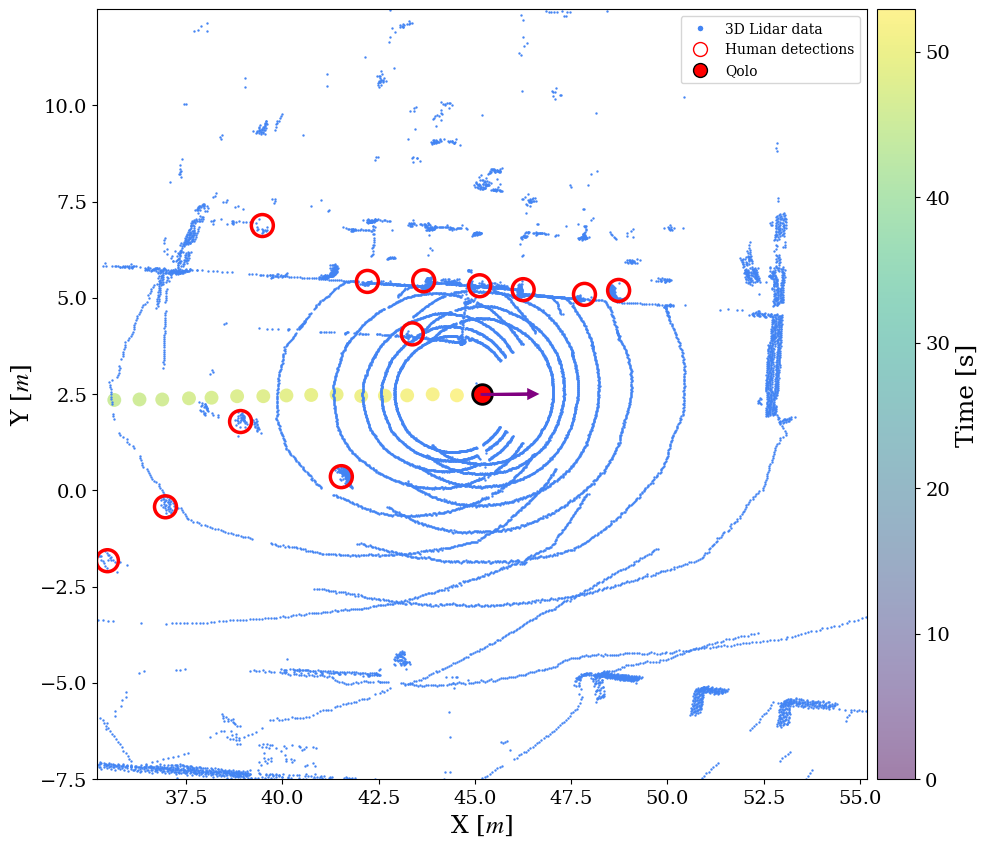

In [15]:
if lidar_2D is not None:
    lidar_2D_keys = list(lidar_2D.keys())

#Pose
tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
pose_stampe_path = os.path.join(
    tf_dir, seq + pose_suffix
)
lidar_pose_stamped = np.load(
    pose_stampe_path, allow_pickle=True
).item()

#Plot
fig_xy = plt.figure(figsize=(15, 10))
fig_xy = display_frame_pose_more(
    fig_xy, 
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    bbox=trks_merged,
    bbox_other=None,
    with_cloud=True,
    with_id=False,
    filtering=True,
    filter_dist=10,
    filter_height=False,
    filter_height_add=0.2,
    transform_pc=False,
)

# Assuming fig_xy is your figure object that has been returned from a function
ax = fig_xy.axes[0]  # Retrieve the Axes object if there is only one subplot

# pos = lidar_pose_stamped['position'][fr_idx,:]
# quat = lidar_pose_stamped['orientation'][fr_idx,:]
# if dataset == 'CROWDBOT':
#     if '/scan_multi' in lidar_2D_keys:
#         print('merged')
#         l_2D = laserscan_to_xy_global(lidar_2D['/scan_multi']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/scan_multi')
#         ax.scatter(l_2D[:,0], l_2D[:,1], color='#FF0000', s=3)
#     if '/front_lidar/scan_modified' in lidar_2D_keys:
#         print('modified')
#         l_2D = laserscan_to_xy_global(lidar_2D['/front_lidar/scan_modified']['ranges'], laser_fov_deg=253.38, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/front_lidar/scan_modified')
#         l_2D_1 = laserscan_to_xy_global(lidar_2D['/rear_lidar/scan_modified']['ranges'], laser_fov_deg=236.18, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/rear_lidar/scan_modified')
#         ax.scatter(l_2D[:,0], l_2D[:,1], color='green', s=2) # #DC143C
#     if '/front_lidar/scan' in lidar_2D_keys:
#         print('default')
#         l_2D = laserscan_to_xy_global(lidar_2D['/front_lidar/scan']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/front_lidar/scan')
#         l_2D_1 = laserscan_to_xy_global(lidar_2D['/rear_lidar/scan']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/rear_lidar/scan')
#         ax.scatter(l_2D[:,0], l_2D[:,1], color='#DC143C', s=2)
#         ax.scatter(l_2D_1[:,0], l_2D_1[:,1], color='#8B0000', s=2)
# elif dataset == 'JRDB':
#     l_2D = laserscan_to_xy_global(lidar_2D[lidar_2D_keys[0]]['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic=lidar_2D_keys[0])
#     ax.scatter(l_2D[:,0], l_2D[:,1], color='#FF0000', s=2)
# elif dataset == 'SiT':
#     l_2D = laserscan_to_xy_global(lidar_2D[lidar_2D_keys[0]]['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic=lidar_2D_keys[0])
#     ax.scatter(l_2D[:,0], l_2D[:,1], color='#FF0000', s=2)
# else:
#     pass

# Define the custom legend entries based on the details provided
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='3D Lidar data',
           markerfacecolor=(66.0 / 256, 133.0 / 256, 244.0 / 256), markersize=5),
    Line2D([0], [0], marker='o', color='w', label='Human detections',
           markerfacecolor='None', markeredgecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Qolo',
           markerfacecolor='red', markeredgecolor='black', markersize=10),
]

# Create the legend, adding the custom handler for the arrow
ax.legend(handles=legend_elements, loc='upper right',)
plt.show()

### Single frame in 3D

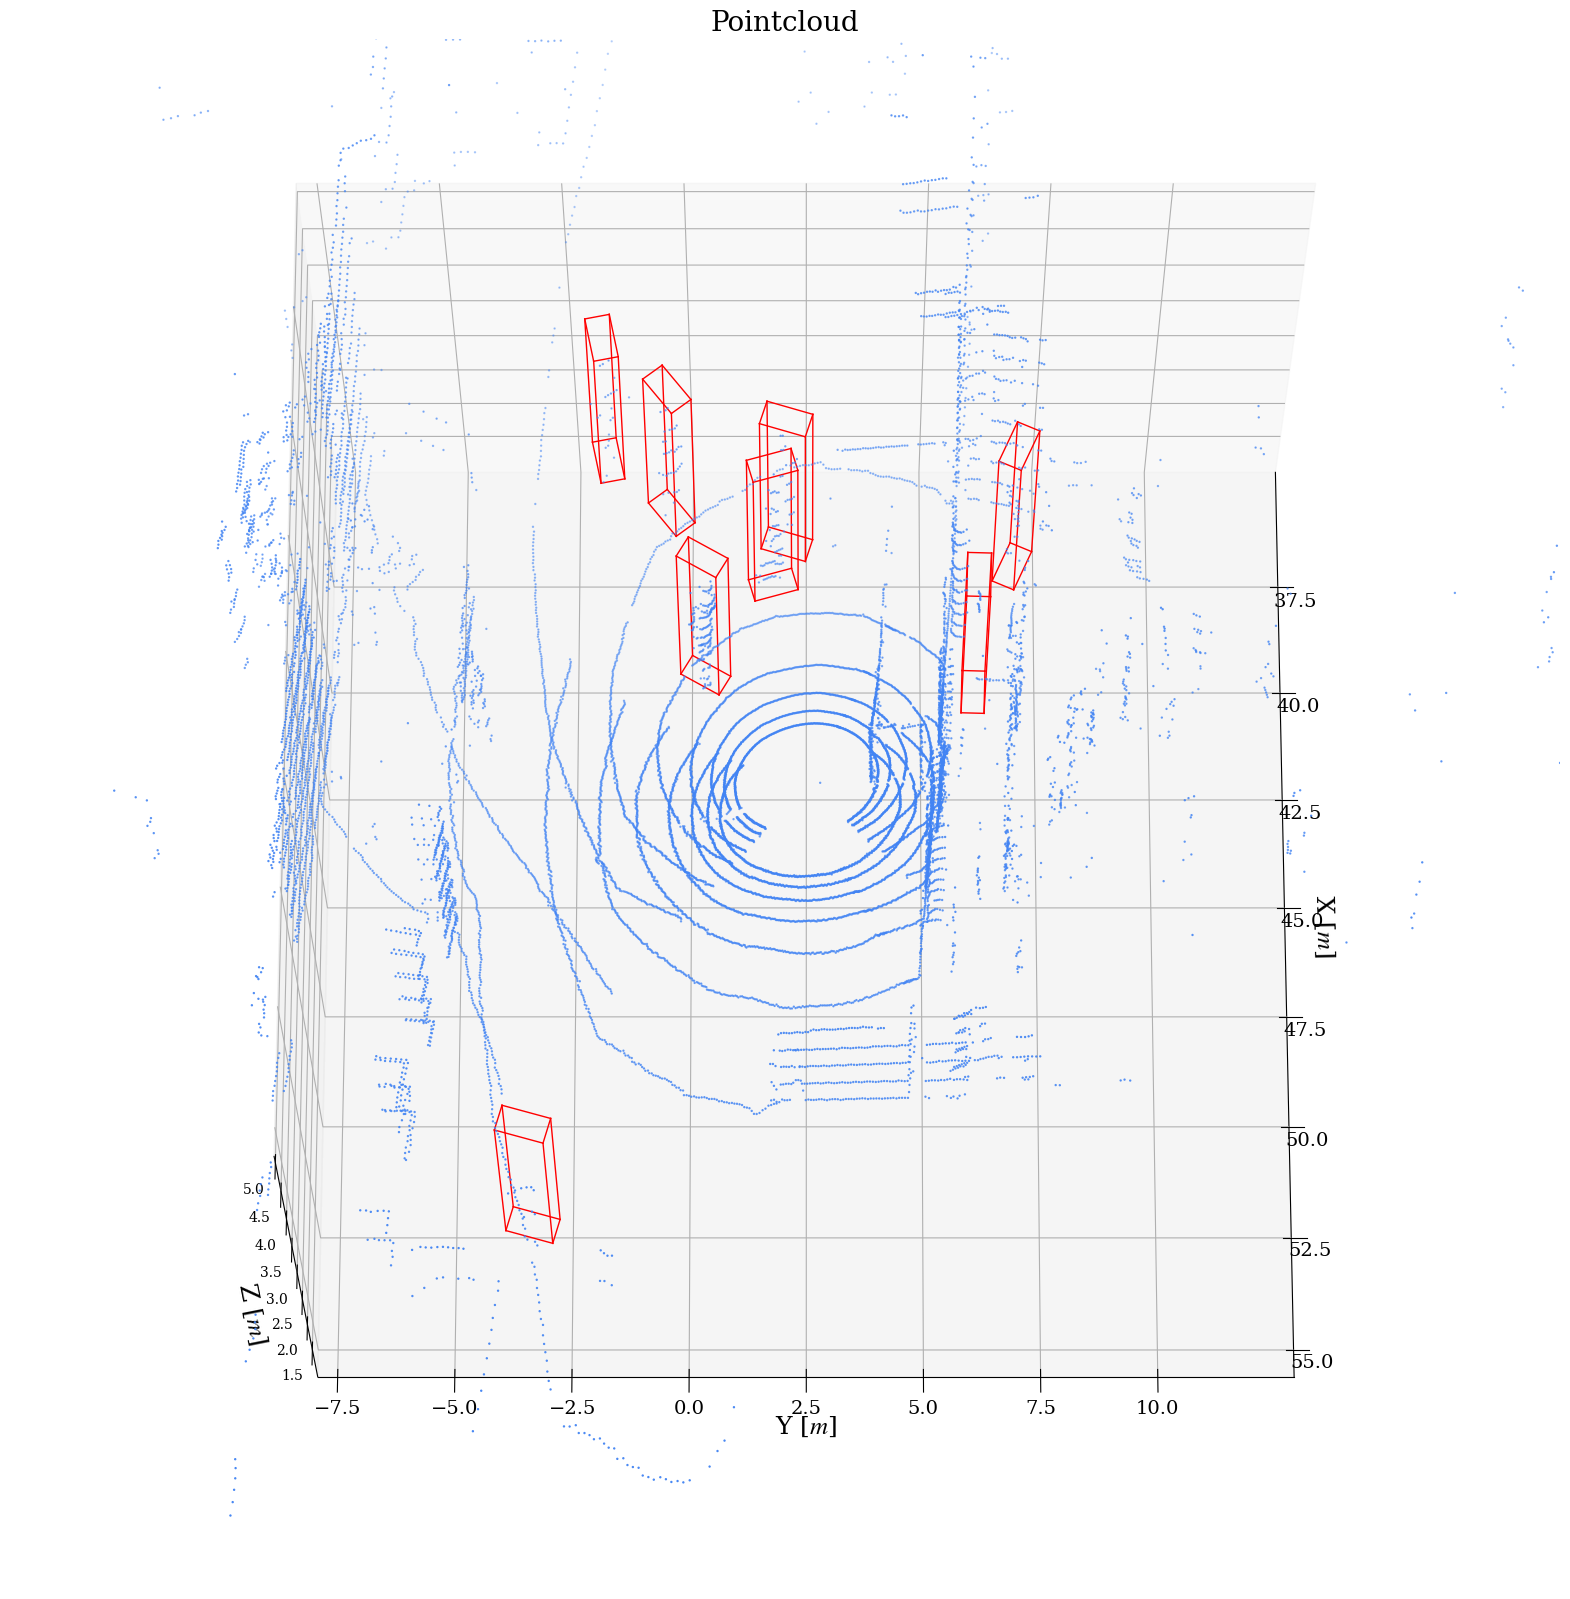

In [16]:
pos = lidar_pose_stamped['position'][fr_idx]
quat = lidar_pose_stamped['orientation'][fr_idx]

fig_xy = plt.figure(figsize=(20, 40))
fig_xy = display_frame(
    fig=fig_xy, 
    pc=lidar.T, 
    pos=pos, 
    quat=quat, 
    bbox=trks,
    bbox_other=None, 
    proj='3d', 
    filtering=True, 
    filter_dist=10,
    filter_height=False,
    filter_height_add=0.2,
    transform_pc_global=False,
    transform_pc_local=False,
    turn_off_grid=False,
)
plt.show()


## Tracking analysis

### Extract tracking results

#### Functions

In [17]:
# Function to load a dictionary from a .npz file
def load_dict(filepath):
    if os.path.exists(filepath):
        data = np.load(filepath, allow_pickle=True)
        return {int(k): v.item() for k, v in data.items()}
    return {}

# Function to save a dictionary to a .npz file
def save_dict(filepath, dictionary):
    np.savez(filepath, **{str(k): v for k, v in dictionary.items()})


def detect_and_correct_jitter_adaptive(
    peds_dict,
    jitter_threshold=3.0,
    jitter_reduction_factor=1 / 8,
    jitter_max_length=5,
    sudden_change_threshold=0.2,
    warning_min=20,
    warning_threshold_ratio=1.,
    distance_limit=10,
    velocity_threshold=0.4,
):
    """
    Detect and correct jitter incidents with adaptive jitter_threshold and optimized event skipping.

    Parameters:
    - peds_dict: Dictionary of pedestrian data, where each pedestrian's data contains:
        - 'vel_non_smooth': Nx3 array of velocities (x, y, z).
        - 'fr_idx_list': List of frame indices corresponding to the velocity data.
    - jitter_threshold: Initial threshold for detecting drops/increases in the sum of velocities.
    - jitter_reduction_factor: Fraction of the current jitter_threshold to reduce in each iteration.
    - jitter_max_length: Maximum length (in frames) for a jitter region.
    - sudden_change_threshold: Threshold for detecting sudden changes in individual traces.

    Updates:
    - Modifies 'vel_non_smooth' in the peds_dict to correct jitter regions.
    """
    frame_velocities = {}

    traces_start = set()  # Set to store frames where traces start
    traces_end = set()    # Set to store frames where traces end

    # Step 1: Aggregate sum of velocities across all frames
    for ped_id, ped_data in peds_dict.items():
        fr_idxs = ped_data['fr_idx_list']
        vel_non_smooth = ped_data['vel_non_smooth']
        vel_norm_xy = np.linalg.norm(vel_non_smooth[:, :2], axis=1)
        dist_to_device = ped_data['distance_to_device']

        # Filter frames based on distance to device
        valid_frames = [(frame, vel_norm, device_dist) for frame, vel_norm, device_dist in zip(fr_idxs, vel_norm_xy, dist_to_device) if device_dist < distance_limit]

        if len(valid_frames) > 0:
            # Extract the first and last valid frames for traces_start and traces_end
            if valid_frames[0][1] > velocity_threshold:
                traces_start.add(valid_frames[0][0])  # First valid frame
            if valid_frames[-1][1] > velocity_threshold:
                traces_end.add(valid_frames[-1][0])  # Last valid frame

        # Accumulate velocities for valid frames
        for frame, vel_norm, device_dist in valid_frames:
            frame_velocities[frame] = frame_velocities.get(frame, 0) + vel_norm

    sorted_frames = sorted(frame_velocities.keys())
    summed_velocities = np.array([frame_velocities[frame] for frame in sorted_frames])

    # Step 2: Adaptive jitter threshold with optimized skipping
    retained_jitter_events = []  # Store jitter events from previous iterations

    while True:
        jitter_events = retained_jitter_events[:]  # Start with previously found events
        warnings = 0
        warning_starts = []
        i = 0

        # Precompute a binary mask for covered frames
        covered_frames = np.zeros(len(sorted_frames), dtype=bool)
        for jitter_start, jitter_end in jitter_events:
            start_idx = np.searchsorted(sorted_frames, jitter_start)
            end_idx = np.searchsorted(sorted_frames, jitter_end,)
            covered_frames[start_idx:end_idx] = True

        while i < len(summed_velocities) - 1:
            # Skip frames already covered by retained events
            if covered_frames[i]:
                i += 1
                continue
            
            # Detect start of jitter (drop > jitter_threshold)
            # ---- potential jitter start (must be consecutive frames) ----
            is_consecutive = (sorted_frames[i + 1] - sorted_frames[i] == 1)
            is_drop        = (summed_velocities[i] - summed_velocities[i + 1] > jitter_threshold)
            if is_consecutive and is_drop and (sorted_frames[i] not in traces_end):

                jitter_start = i
                jitter_end = None
                start_frame  = sorted_frames[i]

               # ---- look ahead while real frame gap ≤ jitter_max_length ----
                j = 1
                while (i + j < len(summed_velocities) and
                    sorted_frames[i + j] - start_frame <= jitter_max_length):

                    consecutive = (sorted_frames[i + j] - sorted_frames[i + j - 1] == 1)
                    recovery    = (summed_velocities[i + j] - summed_velocities[i + j - 1] > jitter_threshold)

                    if consecutive and recovery and (sorted_frames[i + j] not in traces_start):
                        jitter_end = i + j
                        break
                    j += 1

                # ---- fallback: weaker spike within gap limit ----
                if jitter_end is None:
                    k = 1
                    while (i + k < len(summed_velocities) and
                        sorted_frames[i + k] - start_frame <= jitter_max_length):

                        consecutive = (sorted_frames[i + k] - sorted_frames[i + k - 1] == 1)
                        weak_spike  = (summed_velocities[i + k] - summed_velocities[i + k - 1] > jitter_threshold / 2)

                        if consecutive and weak_spike and (sorted_frames[i + k] not in traces_start):
                            jitter_end = i + k
                            break
                        k += 1

                # ---- register or warn -------------------------------------
                if jitter_end is None:
                    warnings += 1
                    warning_starts.append(sorted_frames[jitter_start])
                    i += 1
                else:
                    js_frame = sorted_frames[jitter_start]
                    je_frame = sorted_frames[jitter_end]
                    jitter_events.append((js_frame, je_frame))

                    s_idx = np.searchsorted(sorted_frames, js_frame)
                    e_idx = np.searchsorted(sorted_frames, je_frame, side='right')
                    covered_frames[s_idx:e_idx] = True
                    i = jitter_end
            else:
                i += 1

        # Adaptive threshold adjustment
        if warnings > warning_min and warnings > len(jitter_events) * warning_threshold_ratio:
            print(f"Stopping threshold adjustment: warnings={warnings}, events={len(jitter_events)}")
            print(f"Final jitter_threshold: {jitter_threshold:.3f}")
            break  # Stop decreasing threshold
        else:
            jitter_threshold -= jitter_threshold * jitter_reduction_factor
            retained_jitter_events = jitter_events  # Retain events for next iteration

    # Step 3: Correct affected pedestrian traces
    for jitter_start_frame, jitter_end_frame in jitter_events:
        for ped_id, ped_data in peds_dict.items():
            fr_idxs = ped_data['fr_idx_list']
            vel_non_smooth = ped_data['vel_non_smooth']

            # Find indices corresponding to jitter region
            start_idx = np.searchsorted(fr_idxs, jitter_start_frame)
            end_idx = np.searchsorted(fr_idxs, jitter_end_frame, side='right')

            if start_idx < end_idx:
                # Check for sudden changes in pedestrian trace
                region = vel_non_smooth[start_idx:end_idx, :2]
                diffs = np.abs(np.diff(np.linalg.norm(region, axis=1)))

                if np.any(diffs > sudden_change_threshold):
                    # Interpolate velocities across the jitter region
                    valid_frames = np.concatenate([fr_idxs[:start_idx], fr_idxs[end_idx:]])
                    valid_values = np.concatenate([vel_non_smooth[:start_idx], vel_non_smooth[end_idx:]], axis=0)

                    interpolator = interp1d(
                        valid_frames, valid_values, axis=0, kind="linear", fill_value="extrapolate"
                    )
                    vel_non_smooth[start_idx:end_idx] = interpolator(fr_idxs[start_idx:end_idx])

    print(f"Jitter correction complete. Total jitter events detected: {len(jitter_events)}")

def classify_and_process_peds_dict(
    peds_dict,
    classification_window,
    refinement_window,
    min_dips,
    lower_threshold=0.2,
    extend_frames=10
):
    """
    Classify velocity into stationary and moving regions, refine classification,
    and zero-out stationary components directly in the peds_dict.

    Parameters:
    - peds_dict: Dictionary of pedestrian data, where each pedestrian's data contains:
        - 'vel_non_smooth': Nx3 array of velocity components (x, y, z).
    - classification_window: Window size in samples for initial classification based on dips.
    - refinement_window: Window size in samples for refining classification.
    - min_dips: Minimum number of dips below lower_threshold in classification window to classify as stationary.
    - lower_threshold: Velocity norm threshold below which values are considered dips.
    - extend_frames: Number of frames to extend moving blocks.

    Updates:
    - Modifies 'vel_non_smooth' in the peds_dict to zero-out stationary regions.
    """
    for ped_id, ped_data in peds_dict.items():
        vel_3d = ped_data['vel_non_smooth']
        n = vel_3d.shape[0]

        # Step 1: Compute the velocity norm using x and y components only
        vel_norm = np.sqrt(vel_3d[:, 0]**2 + vel_3d[:, 1]**2)

        # Step 2: Initial Classification Based on Dips
        dips = vel_norm < lower_threshold  # Boolean array for dips
        dips_count = np.convolve(dips.astype(int), np.ones(classification_window, dtype=int), mode='same')
        is_stationary = dips_count >= min_dips  # Classify as stationary if dips exceed the threshold

        # Step 3: Refinement of Classification into Blocks
        window = np.ones(refinement_window, dtype=int)
        stationary_sum = np.convolve(is_stationary.astype(int), window, mode='same')
        stationary_mean = stationary_sum / refinement_window
        refined_classification = stationary_mean > 0.5  # Majority voting: stationary if >50% points in the window are stationary

        # Step 4: Extend Moving Blocks
        transitions = np.diff(refined_classification.astype(int))  # +1 for stationary-to-moving, -1 for moving-to-stationary
        moving_starts = np.where(transitions == -1)[0] + 1  # Transition to moving
        moving_ends = np.where(transitions == 1)[0] + 1     # Transition to stationary

        # Handle edge cases
        if refined_classification[0] == False:  # Moving at the start
            moving_starts = np.insert(moving_starts, 0, 0)
        if refined_classification[-1] == False:  # Moving at the end
            moving_ends = np.append(moving_ends, n)

        # Extend each moving block
        for start, end in zip(moving_starts, moving_ends):
            start = max(0, start - extend_frames)
            end = min(n, end + extend_frames)
            refined_classification[start:end] = False  # Mark as moving

        # Step 5: Zero-out velocity components in stationary regions
        vel_3d[refined_classification, :] = 0  # Zero-out all components (x, y, z) for stationary regions

        # Update the peds_dict directly
        ped_data['vel_non_smooth'] = vel_3d

    print("Velocity classification and processing complete.")


def optimized_adaptive_savgol(
    signal,
    min_window,
    max_window,
    polyorder,
    sensitivity=1.0,
    local_frame_distance=10,
    num_windows=5,
    min_threshold=0.2,  # Minimum change (e.g., 0.2 m/s)
    max_threshold=0.6,  # Maximum change (e.g., 0.6 m/s)
):
    """
    Adaptive Savitzky-Golay filter with fixed thresholds for normalizing local change.
    
    Parameters:
    - signal: 1D array-like, the input signal to be smoothed.
    - min_window: Minimum window size for Savitzky-Golay filtering.
    - max_window: Maximum window size for Savitzky-Golay filtering.
    - polyorder: Polynomial order for Savitzky-Golay filtering.
    - sensitivity: Controls the scaling of the adaptive window sizes.
    - local_frame_distance: Number of frames to calculate local change.
    - num_windows: Number of discrete window sizes.
    - min_threshold: Change below this value uses max_window.
    - max_threshold: Change above this value uses min_window.
    
    Returns:
    - smoothed_signal: The smoothed signal.
    """
    # Calculate the local change over specified frame distance
    local_change = np.abs(signal[:-local_frame_distance] - signal[local_frame_distance:])
    pad_left = local_frame_distance // 2
    pad_right = local_frame_distance - pad_left  # Ensure total padding matches `local_frame_distance`
    local_change = np.pad(local_change, (pad_left, pad_right), mode='edge')
    
    # # Normalize the local change
    # normalized_change = local_change / np.max(local_change)

    # Clamp local_change to the range [min_threshold, max_threshold]
    clamped_change = np.clip((local_change - min_threshold) / (max_threshold - min_threshold), 0, 1)
    
    # Generate discrete window sizes
    if min_window != max_window:
        discrete_window_sizes = np.linspace(min_window, max_window, num_windows).astype(int)
        discrete_window_sizes = np.array([w if w % 2 == 1 else w + 1 for w in discrete_window_sizes])
    else:
        discrete_window_sizes = np.array([min_window])

    # Compute adaptive window sizes by mapping to the closest discrete size
    continuous_window_sizes = (max_window - min_window) * (1 - clamped_change ** sensitivity) + min_window
    window_sizes = np.array([min(discrete_window_sizes, key=lambda x: abs(x - size)) for size in continuous_window_sizes])
    
    # Precompute smoothed segments for discrete window sizes
    unique_window_sizes = np.unique(window_sizes)
    precomputed_segments = {}
    for w in unique_window_sizes:
        precomputed_segments[w] = savgol_filter(signal, w, polyorder)
    
    # Assign smoothed values using precomputed segments
    smoothed_signal = np.array([precomputed_segments[window_sizes[i]][i] for i in range(len(signal))])

    return smoothed_signal

def smoothing_adaptive(vals, min_window, max_window, polyorder, sensitivity, local_frame_distance, num_windows, min_threshold, max_threshold,):
    
    smooth_x_derivative = optimized_adaptive_savgol(vals[:, 0], 
                        min_window=min_window, max_window=max_window, polyorder=polyorder, sensitivity=sensitivity, 
                        local_frame_distance=local_frame_distance, num_windows=num_windows, min_threshold=min_threshold, max_threshold=max_threshold,)

    smooth_y_derivative = optimized_adaptive_savgol(vals[:, 1], 
                        min_window=min_window, max_window=max_window, polyorder=polyorder, sensitivity=sensitivity, 
                        local_frame_distance=local_frame_distance, num_windows=num_windows, min_threshold=min_threshold, max_threshold=max_threshold,)
    
    smooth_z_derivative = optimized_adaptive_savgol(vals[:, 2], 
                        min_window=min_window, max_window=max_window, polyorder=polyorder, sensitivity=sensitivity, 
                        local_frame_distance=local_frame_distance, num_windows=num_windows, min_threshold=min_threshold, max_threshold=max_threshold,)

    smooth_derivative = np.vstack((smooth_x_derivative, smooth_y_derivative, smooth_z_derivative)).T
    return smooth_derivative


def derivative_and_smoothing(vals, timestamp, smooth=True, window_length=21, polyorder=5,  mode='interp',):
    
    state = {
            "x": vals[:, 0],
            "y": vals[:, 1],
            "z": vals[:, 2],
            "timestamp": timestamp,
        }
    
    state_derivative = compute_motion_derivative(
            state, subset=["x", "y", "z"], 
        )
    
    xyz_derivative = np.vstack(
            (state_derivative["x"], state_derivative["y"], state_derivative["z"])
        ).T
    
    if not smooth:
        return xyz_derivative
    # print("Using Savitzky-Golay filter to smooth vel!")
    # apply filter to computed vel
    smooth_x_derivative = smooth1d(
        xyz_derivative[:, 0],
        filter='savgol',
        window=window_length,
        polyorder=polyorder,
        check_thres=False,
        mode=mode,
    )

    smooth_y_derivative = smooth1d(
        xyz_derivative[:, 1],
        filter='savgol',
        window=window_length,
        polyorder=polyorder,
        check_thres=False,
        mode=mode,
    )
    smooth_z_derivative = smooth1d(
        xyz_derivative[:, 2],
        filter='savgol',
        window=window_length,
        polyorder=polyorder,
        check_thres=False,
        mode=mode,
    )

    smooth_derivative = np.vstack((smooth_x_derivative, smooth_y_derivative, smooth_z_derivative)).T
    return smooth_derivative

def derivative_and_smoothing1d(vals, timestamp, smooth=True, window_length=21, polyorder=5,  mode='interp',):
    
    state = {
            "x": vals,
            "timestamp": timestamp,
        }
    
    state_derivative = compute_motion_derivative(
            state, subset=["x",], 
        )
    
    derivative = state_derivative["x"]
    
    if not smooth:
        return derivative
    # print("Using Savitzky-Golay filter to smooth vel!")
    # apply filter to computed vel
    smooth_derivative = smooth1d(
        derivative,
        filter='savgol',
        window=window_length,
        polyorder=polyorder,
        check_thres=False,
        mode=mode,
    )

    return smooth_derivative

def has_n_continuous_above_threshold(arr, threshold, n):

    magnitudes = np.linalg.norm(arr, axis=1)
    # Create a boolean array where each element is True if the corresponding element in arr is greater than threshold
    bool_arr = magnitudes > threshold
    
    # Initialize a counter for the current streak of values above the threshold
    current_streak = 0
    
    # Iterate through the boolean array
    for value in bool_arr:
        if value:
            current_streak += 1
            if current_streak >= n:
                return True
        else:
            current_streak = 0
    
    return False
    
def get_dynamic_angle_threshold(distance, min_distance, max_distance, min_angle, max_angle):
    """
    Scalar- or array-aware dynamic angle threshold:
    piecewise constant outside [min_distance, max_distance],
    linear in between. Returns float for scalar input, ndarray for array input.
    """
    d = np.asarray(distance, dtype=float)
    out = np.interp(
        d,
        [min_distance, max_distance],
        [max_angle,    min_angle],
        left=max_angle,
        right=min_angle
    )
    return out.item() if out.ndim == 0 else out

def angle_between_vectors(v1, v2):
    v1 = np.asarray(v1)
    v2 = np.asarray(v2)

    if v1.shape != v2.shape:
        raise ValueError(f"angle_between_vectors: v1 and v2 must have the same shape, got {v1.shape} vs {v2.shape}")

    if v1.ndim == 1:
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 < 1e-3 or norm_v2 < 1e-3:
            return 180.0
        unit_v1 = v1 / norm_v1
        unit_v2 = v2 / norm_v2
        dot_product = np.dot(unit_v1, unit_v2)
        dot_product = np.clip(dot_product, -1.0, 1.0)
        return np.degrees(np.arccos(dot_product))

    elif v1.ndim == 2:
        norm_v1 = np.linalg.norm(v1, axis=1)
        norm_v2 = np.linalg.norm(v2, axis=1)
        angles = np.full(v1.shape[0], 180.0, dtype=float)

        mask = (norm_v1 >= 1e-3) & (norm_v2 >= 1e-3)
        if np.any(mask):
            unit_v1 = v1[mask] / norm_v1[mask][:, None]
            unit_v2 = v2[mask] / norm_v2[mask][:, None]
            dot_product = np.einsum('ij,ij->i', unit_v1, unit_v2)
            dot_product = np.clip(dot_product, -1.0, 1.0)
            angles[mask] = np.degrees(np.arccos(dot_product))
        return angles

    else:
        raise ValueError("angle_between_vectors: inputs must be 1D or 2D")


def calculate_time_to_close_collision_edge(
        ped_position,             # (2,) – pedestrian centre
        ped_velocity,             # (2,) – pedestrian velocity
        other_position,           # (2,) – device/pedestrian centre
        other_velocity,           # (2,) – device/pedestrian velocity
        rect_length=None,         # float or None – rectangle length (local +x)
        rect_width=None,          # float or None – rectangle width  (local +y)
        rect_orientation=None,    # (4,) or None – quaternion (x, y, z, w)
        rect_length_offset=0.0,
        pedestrian_radius=0.2,    # float – pedestrian circle radius
        collision_threshold=0.0,  # float – desired clearance
        distance_center=False,    # bool – True: center-to-center TTC
        to_device=False,          # bool – True: other is a device (rectangle)
        eps=1e-3):               # float – zero-speed tolerance
    """
    TTC between a moving pedestrian and either another pedestrian (circle)
    or a device (oriented rectangle). You can choose center-to-center or
    edge-to-edge distance.

    Returns
    -------
    0.0          already within clearance
    t > 0        seconds until first threshold crossing
    float('inf') no future crossing

    Validation
    ----------
    - to_device=False (ped vs ped): ignores all rect_*.
    - to_device=True and distance_center=True: ignores all rect_*.
    - to_device=True and distance_center=False: requires rect_length,
      rect_width, and rect_orientation.
    """

    def _ttcc_to_distance_threshold(r0, v, Rthr):
        """Earliest t >= 0 such that ||r0 + v*t|| <= Rthr."""
        Rthr = float(Rthr)
        d0_sq = float(np.dot(r0, r0))
        R2 = Rthr * Rthr
        if d0_sq <= R2:
            return 0.0
        v2 = float(np.dot(v, v))
        if v2 <= eps:
            return float('inf')
        b = 2.0 * float(np.dot(r0, v))
        c = d0_sq - R2
        disc = b*b - 4.0*v2*c
        if disc < 0.0:
            return float('inf')
        sqrt_disc = float(np.sqrt(disc))
        t_enter = (-b - sqrt_disc) / (2.0*v2)
        t_exit  = (-b + sqrt_disc) / (2.0*v2)
        if t_exit <= 0.0:
            return float('inf')
        return max(t_enter, 0.0)

    # normalize inputs
    ped_position   = np.asarray(ped_position,   dtype=float)
    ped_velocity   = np.asarray(ped_velocity,   dtype=float)
    other_position = np.asarray(other_position, dtype=float)
    other_velocity = np.asarray(other_velocity, dtype=float)

    # relative motion in world frame
    r0_world = ped_position - other_position
    v_world  = ped_velocity - other_velocity

    # ---- ped vs ped ---------------------------------------------------------
    if not to_device:
        if distance_center:
            Rthr = collision_threshold
        else:
            Rthr = 2.0 * pedestrian_radius + collision_threshold
        return _ttcc_to_distance_threshold(r0_world, v_world, Rthr)

    # ---- ped vs device ------------------------------------------------------
    if distance_center:
        # center-to-center: rect_* not needed
        Rthr = collision_threshold
        return _ttcc_to_distance_threshold(r0_world, v_world, Rthr)

    # edge-to-edge vs oriented rectangle: require all rect_* together
    missing = [name for name, val in {
        'rect_length': rect_length,
        'rect_width': rect_width,
        'rect_orientation': rect_orientation
    }.items() if val is None]
    if missing:
        raise ValueError("When to_device=True and distance_center=False, provide: "
                         + ", ".join(missing) + ".")

    rect_orientation = np.asarray(rect_orientation, dtype=float)
    if rect_orientation.shape[-1] != 4:
        raise ValueError("rect_orientation must be a length-4 quaternion (x, y, z, w).")
    
    # SciPy expects [x, y, z, w]
    rot = R.from_quat(np.asarray(rect_orientation, dtype=float))
    # Intrinsic ZYX: yaw (z), pitch (y), roll (x)
    yaw, _, _ = rot.as_euler('zyx', degrees=False)
    c = np.cos(yaw)
    s = np.sin(yaw)
    # World->Local active 2D rotation for pure yaw
    R_loc = np.array([[c, s],
                     [-s,  c]], dtype=float)

    # # rotate world → rectangle local (row • Rᵀ)
    # Passive rotation so transposed
    r0 = r0_world @ R_loc.T
    v  = v_world  @ R_loc.T

    # asymmetric extents along local x using rect_length_offset (δ)
    grow = pedestrian_radius + collision_threshold
    half_len = 0.5 * float(rect_length)
    half_w   = 0.5 * float(rect_width)

    delta = float(rect_length_offset)
    if abs(delta) > half_len:
        raise ValueError("rect_length_offset magnitude exceeds half the length.")

    front_extent = half_len - delta   # +x side
    rear_extent  = half_len + delta   # -x side

    # grow the rectangle by the clearance (ped radius + threshold)
    x_min = -(rear_extent + grow)
    x_max = +(front_extent + grow)
    y_min = -(half_w + grow)
    y_max = +(half_w + grow)

    # already inside?
    if (x_min <= r0[0] <= x_max) and (y_min <= r0[1] <= y_max):
        return 0.0

    # slab test
    t_enter = -float('inf')
    t_exit  =  float('inf')
    bounds = ((x_min, x_max), (y_min, y_max))
    for i in (0, 1):
        lo, hi = bounds[i]
        if abs(v[i]) < eps:               # parallel to slab planes
            if (r0[i] < lo) or (r0[i] > hi):
                return float('inf')       # never enters this slab
            continue                      # always inside this slab
        t1 = (lo - r0[i]) / v[i]
        t2 = (hi - r0[i]) / v[i]
        t_axis_enter = min(t1, t2)
        t_axis_exit  = max(t1, t2)
        t_enter = max(t_enter, t_axis_enter)
        t_exit  = min(t_exit,  t_axis_exit)
        if t_enter - t_exit > eps:
            return float('inf')

    if t_exit <= 0.0:                      # overlap interval already past
        return float('inf')

    return t_enter

def add_device_interact_multiple(
    ped_data,
    lidar_pose_stamped, pedestrian_radius, device_length, device_width, device_length_offset,
    distance_threshold, min_distance, max_distance,
    min_angle, max_angle,
    ttcc_threshold, collision_threshold,
    interact_extension_frames,
    variants=None,
):
    """
    Adds multiple device_interact flags to `ped_data` based on different sensitivity profiles.
    Uses vectorized get_dynamic_angle_threshold; calculate_time_to_close_collision_edge remains scalar.
    """
    if variants is None:
        variants = []

    # ---- default profile from arguments ----
    default_profile = {
        "name": "interact",
        "distance_threshold": distance_threshold,
        "min_angle": min_angle,
        "max_angle": max_angle,
        "min_distance": min_distance,
        "max_distance": max_distance,
        "ttcc_threshold": ttcc_threshold,
    }

    # ---- overlay variants on defaults ----
    profiles = []
    for v in [default_profile] + variants:
        p = default_profile.copy()
        p.update(v)
        profiles.append(p)

    # ---- index & precompute arrays (profile-independent) ----
    idxs = np.asarray(ped_data['fr_idx_list'])
    N = len(idxs)

    dev_pos_xy = np.asarray(lidar_pose_stamped['position'])[idxs, :2]
    dev_quat   = np.asarray(lidar_pose_stamped['orientation'])[idxs]      # (N,4)
    x_vel      = np.asarray(lidar_pose_stamped['x_vel'])[idxs]            # (N,)

    ped_pos_xy = np.asarray(ped_data['pos_smooth'])[:N, :2]
    ped_vel_xy = np.asarray(ped_data['vel_smooth'])[:N, :2]

    # quaternion -> yaw, then direction & device velocity
    yaws    = R.from_quat(dev_quat).as_euler('xyz')[:, 2]
    dev_dir = np.column_stack((np.cos(yaws), np.sin(yaws)))               # (N,2)
    dev_vel = dev_dir * x_vel[:, None]                                    # (N,2)

    vec_to_dev = dev_pos_xy - ped_pos_xy                                  # (N,2)
    distances  = np.linalg.norm(vec_to_dev, axis=1)                       # (N,)

    distances_edge = np.empty(N, dtype=float)
    # If compute_min_distances expects yaw instead of quat, pass `yaws` here.
    for i in range(N):
        distances_edge[i] = compute_min_distances(
            ped_positions=ped_pos_xy[i],
            rect_pos=dev_pos_xy[i],
            rect_orientation=dev_quat[i],  # change to `yaws` if your function expects yaw
            rect_length=device_length,
            rect_width=device_width,
            pedestrian_radius=pedestrian_radius,
            rect_length_offset=device_length_offset
        )

    # batch angles in degrees (matches dynamic angle thresholds)
    angles_to_device = angle_between_vectors(ped_vel_xy, vec_to_dev)      # (N,)

    # ---- process each profile ----
    for profile in profiles:
        key = 'device_' + profile["name"]

        min_dist = profile["min_distance"]
        max_dist = profile["max_distance"]
        min_ang  = profile["min_angle"]
        max_ang  = profile["max_angle"]
        dist_thr = profile["distance_threshold"]
        ttcc_thr = profile["ttcc_threshold"]

        # vectorized dynamic thresholds for all samples
        dyn_thr_arr = get_dynamic_angle_threshold(
            distances_edge, min_dist, max_dist, min_ang, max_ang
        )

        # compute TTC per-sample (scalar function)
        ttcc_arr = np.empty(N, dtype=float)
        for i in range(N):
            ttcc_arr[i] = calculate_time_to_close_collision_edge(
                ped_position=ped_pos_xy[i],
                ped_velocity=ped_vel_xy[i],
                other_position=dev_pos_xy[i],
                other_velocity=dev_vel[i],
                rect_length=device_length,
                rect_width=device_width,
                rect_orientation=dev_quat[i],  # expects quaternion (x,y,z,w)
                rect_length_offset=device_length_offset,
                pedestrian_radius=pedestrian_radius,
                collision_threshold=collision_threshold,
                distance_center=False,
                to_device=True
            )

        # combine conditions vectorially
        # far = distances > dist_thr
        # interact_arr = np.where(
        #     far,
        #     (angles_to_device <= dyn_thr_arr) & (ttcc_arr <= ttcc_thr),
        #     (angles_to_device <= dyn_thr_arr) | (ttcc_arr <= ttcc_thr)
        # )
        interact_arr = (angles_to_device <= dyn_thr_arr) & (ttcc_arr <= ttcc_thr)
        # extend interactions over time (by frame index)
        i = 0
        while i < N:
            if interact_arr[i]:
                current_frame = idxs[i]
                i_next = i + 1
                while i_next < N and idxs[i_next] <= current_frame + interact_extension_frames:
                    interact_arr[i_next] = True
                    i_next += 1
                i = i_next
            else:
                i += 1

        ped_data[key] = interact_arr



def interpolate_orientation(ped_smooth_vel, vel_smooth_norm, orientation_vel_threshold, start_end_drop_frames):
    """
    Corrects and smooths the orientation angles computed from velocity components,
    disregarding values where vel_smooth_norm is below orientation_vel_threshold,
    and excluding start_end_drop_frames from valid frames for interpolation.

    Parameters:
        ped_smooth_vel (numpy.ndarray): The array of velocity components [N, 2] (x and y components).
        vel_smooth_norm (numpy.ndarray): The array of velocity magnitudes.
        orientation_vel_threshold (float): The velocity threshold below which orientations are disregarded.
        start_end_drop_frames (int): The number of frames to drop from the start and end of valid frames.

    Returns:
        numpy.ndarray: The interpolated and smoothed orientation angles in radians.
    """
    total_frames = len(ped_smooth_vel)

    # Step 1: Find valid indices based on velocity threshold
    valid_indices = np.where(vel_smooth_norm >= orientation_vel_threshold)[0]

    # Drop start_end_drop_frames from the valid indices
    valid_indices = valid_indices[
        (valid_indices >= start_end_drop_frames) & 
        (valid_indices < (total_frames - start_end_drop_frames))
    ]

    if len(valid_indices) == 0:
        # If no valid indices remain, return NaNs to match the input shape
        return np.full(total_frames, np.nan)

    # Step 2: Calculate orientation in radians
    x_vel = ped_smooth_vel[:, 0]
    y_vel = ped_smooth_vel[:, 1]
    orient_rad = np.arctan2(y_vel, x_vel)  # Orientation in radians [-pi, pi]

    # Step 3: Unwrap angles to ensure smooth transitions
    orient_unwrapped = np.unwrap(orient_rad)

    # Step 4: Adjust blocks to avoid jumps at gaps
    corrected_orient = orient_unwrapped.copy()
    for i in range(1, len(valid_indices)):
        prev_index = valid_indices[i - 1]
        curr_index = valid_indices[i]

        # Detect a gap in valid indices
        if curr_index - prev_index > 1:
            orient_before_gap = corrected_orient[prev_index]
            orient_after_gap = corrected_orient[curr_index]

            # Shift the next block to minimize the difference
            delta = orient_after_gap - orient_before_gap
            if delta > np.pi:
                shift = -2 * np.pi
            elif delta < -np.pi:
                shift = 2 * np.pi
            else:
                shift = 0
            corrected_orient[curr_index:] += shift

    # Step 5: Interpolate corrected orientations
    kind = 'cubic' if len(valid_indices) >= 4 else 'linear'
    orient_interp_func = interp1d(
        valid_indices,
        corrected_orient[valid_indices],
        kind=kind,
        bounds_error=False,
        fill_value=(corrected_orient[valid_indices[0]], corrected_orient[valid_indices[-1]])
    )

    # Step 6: Interpolate over all frames
    all_indices = np.arange(total_frames)
    interpolated_orient_rad = orient_interp_func(all_indices)
    # print(np.where(np.isnan(interpolated_orient_rad)))

    return interpolated_orient_rad

def position_start_end_modifications(abs_pose, timestamp_np, drop_frames, fit_frames):
    """
    Modify the start and end of the abs_pose array by removing frames, fitting linear regressors,
    and extending the position data with generated frames.

    Args:
    - abs_pose (np.ndarray): The absolute position array (Nx3 for x, y, z).
    - timestamp_np (np.ndarray): The timestamps corresponding to the abs_pose array.
    - drop_frames (int): Number of frames to drop from the start and end.
    - fit_frames (int): Number of frames to use for fitting linear regressors at the start and end.

    Returns:
    - abs_pose_modified (np.ndarray): Modified abs_pose with extensions added for all dimensions.
    """
    # 1. Copy abs_pose to avoid modifying the original data
    abs_pose_copy = np.copy(abs_pose)

    # 2. Cut off drop_frames from the beginning and end
    trimmed_pose = abs_pose_copy[drop_frames:-drop_frames, :]
    trimmed_timestamps = timestamp_np[drop_frames:-drop_frames]

    # Extract start and end data for all dimensions
    start_pose = trimmed_pose[:fit_frames, :]
    start_timestamps = trimmed_timestamps[:fit_frames]

    end_pose = trimmed_pose[-fit_frames:, :]
    end_timestamps = trimmed_timestamps[-fit_frames:]

    # Use the original timestamps for the extension
    start_extension_timestamps = timestamp_np[:drop_frames]
    end_extension_timestamps = timestamp_np[-drop_frames:]

    abs_pose_modified_list = []

    # 3. Loop through each dimension
    for dim in range(abs_pose.shape[1]):  # Process each dimension (x, y, z)
        # Fit a linear polynomial (degree 1) to the start
        start_coeffs = np.polyfit(start_timestamps, start_pose[:, dim], 1)
        start_fit = np.poly1d(start_coeffs)

        # Fit a linear polynomial (degree 1) to the end
        end_coeffs = np.polyfit(end_timestamps, end_pose[:, dim], 1)
        end_fit = np.poly1d(end_coeffs)

        # Generate extended positions for the start
        start_extension_pose = start_fit(start_extension_timestamps)
        # Add noise to start extension
        start_noise_std = np.std(start_pose[:, dim] - start_fit(start_timestamps))
        start_extension_pose += np.random.normal(0, start_noise_std, size=start_extension_pose.shape)

        # Generate extended positions for the end
        end_extension_pose = end_fit(end_extension_timestamps)
        # Add noise to end extension
        end_noise_std = np.std(end_pose[:, dim] - end_fit(end_timestamps))
        end_extension_pose += np.random.normal(0, end_noise_std, size=end_extension_pose.shape)

        # Combine extensions with the trimmed data for this dimension
        modified_dim = np.concatenate([start_extension_pose, trimmed_pose[:, dim], end_extension_pose])
        abs_pose_modified_list.append(modified_dim)

    # Combine modified dimensions back into Nx3 format
    abs_pose_modified = np.stack(abs_pose_modified_list, axis=1)

    return abs_pose_modified

def compute_min_distances(ped_positions, rect_pos, rect_orientation, rect_length, rect_width, pedestrian_radius, rect_length_offset=0.0,):
    """
    Computes the minimum edge-to-edge distances for all pedestrians in a frame to a rectangular device.

    ped_positions: (N, 2) array of [px, py]
    rect_pos:      (2,) array center of rotation / reference point (world XY)
    rect_orientation: quaternion [x, y, z, w] (SciPy)
    rect_length:   total length along local +x (meters)
    rect_width:    total width  along local +y (meters)
    pedestrian_radius: scalar radius (meters)
    rect_length_offset: δ (meters). If δ>0, reference is closer to FRONT:
    front_extent = half_length - δ
    rear_extent  = half_length + δ
    x_local is clamped to [-rear_extent, +front_extent]
    If δ=0, symmetric clamp [-half_length, +half_length].
    Returns: (N,) distances (edge-to-edge, can be negative if penetration; clamp if desired)
    """
    if ped_positions.shape[0] == 0:
        return np.array([])  # Return empty array if no pedestrians
    
    # Ensure ped_positions is a 2D array
    was_single = False
    if ped_positions.ndim == 1 and ped_positions.shape[0] == 2:
        ped_positions = ped_positions.reshape(1, 2)  # Convert (2,) to (1, 2)
        was_single = True

    # SciPy expects [x, y, z, w]
    rot = R.from_quat(np.asarray(rect_orientation, dtype=float))
    # Intrinsic ZYX: yaw (z), pitch (y), roll (x)
    yaw, _, _ = rot.as_euler('zyx', degrees=False)
    c = np.cos(yaw)
    s = np.sin(yaw)
    # World->Local active 2D rotation for pure yaw
    rotation_matrix = np.array([[c, s],
                     [-s,  c]], dtype=float)

    # Compute pedestrian positions in the rectangle's local frame
    local_coords = (ped_positions - rect_pos) @ rotation_matrix.T  # Efficient batch transformation

    # Half-lengths of the rectangle
    half_length = rect_length / 2
    half_width = rect_width / 2

    # Clip offset to avoid inverted extents (optional safety)
    delta = float(rect_length_offset)
    if abs(delta) > half_length:
        raise RuntimeError

    front_extent = half_length - delta
    rear_extent  = half_length + delta

    x_local = local_coords[:, 0]
    y_local = local_coords[:, 1]

    x_clamped = np.clip(x_local, -rear_extent,  +front_extent)
    y_clamped = np.clip(y_local, -half_width,   +half_width)

    # Distance from center to rectangle boundary in local frame
    center_to_rect = np.hypot(x_local - x_clamped, y_local - y_clamped)

    # Edge-to-edge distance
    distances = center_to_rect - float(pedestrian_radius)

    if was_single:
        return distances[0]
    return distances

def same_group_by_variation(ped1, ped2, min_len, max_group_variation):
    """
    Return True  → treat ped1 and ped2 as belonging to the same group
           False → treat them as separate

    Criterion:  max(distance) − min(distance) ≤ max_group_variation
                over the entire time interval where both tracks coexist.
    """

    # overlapping frame indices
    start_common = max(ped1['start_idx'], ped2['start_idx'])
    end_common   = min(ped1['end_idx'],   ped2['end_idx'])

    if end_common < start_common:                 # no overlap at all
        return False
    
    shared_frame_count = end_common - start_common + 1
    if shared_frame_count < min_len:
        return False  # Not enough shared frames

    # positions for the shared segment (x, y columns only)
    pos1 = np.asarray(ped1['pos_smooth'])[
        start_common - ped1['start_idx'] : end_common - ped1['start_idx'] + 1, :2
    ]
    pos2 = np.asarray(ped2['pos_smooth'])[
        start_common - ped2['start_idx'] : end_common - ped2['start_idx'] + 1, :2
    ]

    # pairwise Euclidean distances
    d = np.linalg.norm(pos1 - pos2, axis=1)

    # variation test
    return np.ptp(d) <= max_group_variation        # np.ptp = max − min


#### Extraction

In [18]:
consider_pose = True
peds_dict_dict = {}
peds_dict_2D_dict = {}
peds_dict_merged_dict = {}
peds_dict_gt_dict = {}
if dataset == 'CROWDBOT':
    # analyze_tracks = ['T3D', 'TMD', 'T2D'] # T2D for 2D detector and T3D for 3D detector and TMD for merged and TGD for ground truth - Crowdbot
    analyze_tracks = ['TMD']
elif dataset == 'JRDB':
    # analyze_tracks = ['T3D', 'TGD', 'T2D'] # T2D for 2D detector and T3D for 3D detector and TMD for merged and TGD for ground truth - JRDB
    analyze_tracks = ['TGD', 'TMD']
elif dataset == 'SiT':
    # analyze_tracks = ['TGD', 'TMD', 'T2D', 'T3D']
    analyze_tracks = ['TGD', 'TMD']
else:
    raise RuntimeError

# MOVEMENT DETECTED
n=[int(1. * freq) for freq in frequency] # 1s of data

target_len = [int(3.5 * freq) + 1 for freq in frequency] # 3.5s of data
crowd_density_nongt_target_len = [int(1.5 * freq) + 1 for freq in frequency] # data for including to crowd density
minimum_len = [int(1. * freq) + 1 for freq in frequency] # 1s of data

# TRACKER START END DROP FRAMES
start_end_linear_fit_frames = [int(freq) for freq in frequency]
start_end_drop_frames = [int(freq/2) for freq in frequency]

# DEVICE INTERACT
interact_extension_frames = [int(2*freq) for freq in frequency]

sensitivity_variants = [
    {
        "name": "interact_most_direct",
        "distance_threshold": 3,
        "min_angle": 25,
        "max_angle": 80,
        "min_distance": 0.5,
        "max_distance": 2.,
        "ttcc_threshold": 1.5,
        "collision_threshold": collision_threshold_interact - 0.3  # whatever you have
    },
    {
        "name": "interact_more_direct",
        "distance_threshold": 4,
        "min_angle": 30,
        "max_angle": 85,
        "min_distance": 0.5,
        "max_distance": 2.5,
        "ttcc_threshold": 2.,
        "collision_threshold": collision_threshold_interact - 0.2
    },
    {
        "name": "interact_direct",
        "distance_threshold": 4,
        "min_angle": 30,
        "max_angle": 85,
        "min_distance": 0.5,
        "max_distance": 2.5,
        "ttcc_threshold": 2.5,
        "collision_threshold": collision_threshold_interact - 0.1
    },
    {
        "name": "interact_anticipatory",
        "distance_threshold": 6,
        "min_angle": 40,
        "max_angle": 110,
        "min_distance": 0.5,
        "max_distance": 3.5,
        "ttcc_threshold": 3.5,
        "collision_threshold": collision_threshold_interact + 0.1
    },
    {
        "name": "interact_more_anticipatory",
        "distance_threshold": 6,
        "min_angle": 40,
        "max_angle": 110,
        "min_distance": 0.5,
        "max_distance": 3.5,
        "ttcc_threshold": 4.,
        "collision_threshold": collision_threshold_interact + 0.2
    },
    {
        "name": "interact_most_anticipatory",
        "distance_threshold": 7,
        "min_angle": 45,
        "max_angle": 115,
        "min_distance": 0.5,
        "max_distance": 4.0,
        "ttcc_threshold": 4.5,
        "collision_threshold": collision_threshold_interact + 0.3
    }
]

for seq_idx in range(cb_data.nr_seqs()):
    # if seq_idx not in [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 30, 37, 44, 52, 57]:
        # continue

    pos_smooth_len = int(2.5 * frequency[seq_idx]) # --- was 1.5
    # Ensure it's odd and greater than the calculated value
    if pos_smooth_len % 2 == 0:
        pos_smooth_len += 1
    else:
        pos_smooth_len += 2  # Ensure it's the next odd number if already odd
        
    pos_smooth_len_gt = int(2.5*frequency[seq_idx]) # Must be smaller equal target_len, --- was 1
    if pos_smooth_len_gt % 2 == 0:
        pos_smooth_len_gt += 1
    else:
        pos_smooth_len_gt += 2  # Ensure it's the next odd number if already odd

    vel_smooth_len = int(1 * frequency[seq_idx])
    if vel_smooth_len % 2 == 0:
        vel_smooth_len += 1
    else:
        vel_smooth_len += 2  # Ensure it's the next odd number if already odd

    seq = cb_data.seqs[seq_idx]
    print('Analyzing {}/{}: {}'.format(seq_idx+1, cb_data.nr_seqs(), seq))

    # peds_dict_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_{seq}.npz')
    # peds_dict_2D_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_2D_{seq}.npz')
    # peds_dict_merged_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_merged_{seq}.npz')
    # peds_dict_gt_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_gt_{seq}.npz')
    
    suffix = 'most_direct_to_most_anticipatory_sensitivity'
    # Define file paths for the current sequence
    peds_dict_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_{seq}_{suffix}.npz')
    peds_dict_2D_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_2D_{seq}_{suffix}.npz')
    peds_dict_merged_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_merged_{seq}_{suffix}.npz')
    peds_dict_gt_path = os.path.join(cb_data.ped_data_dirs[seq_idx], f'peds_dict_gt_{seq}_{suffix}.npz')
    
    # Load the dictionaries for the current sequence if they are specified in analyze_tracks
    if 'T3D' in analyze_tracks:
        if overwrite_tracks_generation:
            peds_dict_dict[seq_idx] = {}
        else:
            peds_dict_dict[seq_idx] = load_dict(peds_dict_path)
    if 'T2D' in analyze_tracks:
        if overwrite_tracks_generation:
            peds_dict_2D_dict[seq_idx] = {}
        else:
            peds_dict_2D_dict[seq_idx] = load_dict(peds_dict_2D_path)
    if 'TMD' in analyze_tracks:
        if overwrite_tracks_generation:
            peds_dict_merged_dict[seq_idx] = {}
        else:
            peds_dict_merged_dict[seq_idx] = load_dict(peds_dict_merged_path)
    if 'TGD' in analyze_tracks:
        if overwrite_tracks_generation:
                peds_dict_gt_dict[seq_idx] = {}
        else:
            peds_dict_gt_dict[seq_idx] = load_dict(peds_dict_gt_path)

    # Create a list of track types that still need to be processed
    missing_tracks = []
    if 'T3D' in analyze_tracks and not peds_dict_dict[seq_idx]:
        missing_tracks.append('T3D')
    if 'T2D' in analyze_tracks and not peds_dict_2D_dict[seq_idx]:
        missing_tracks.append('T2D')
    if 'TMD' in analyze_tracks and not peds_dict_merged_dict[seq_idx]:
        missing_tracks.append('TMD')
    if 'TGD' in analyze_tracks and not peds_dict_gt_dict[seq_idx]:
        missing_tracks.append('TGD')

    if not missing_tracks:
        continue
    
    if consider_pose:
        tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
        pose_stampe_path = os.path.join(
            tf_dir, seq + pose_suffix
        )
        lidar_pose_stamped = np.load(
            pose_stampe_path, allow_pickle=True
        ).item()
        
    trans_array = lidar_pose_stamped["position"]
    quat_array = lidar_pose_stamped["orientation"]
    timestamp_array = lidar_pose_stamped["timestamp"]
    x_vel_array = lidar_pose_stamped['x_vel']       # shape: (N,) where N is the number of frames

    # Convert all quaternions to Euler angles (yaw, pitch, roll)
    euler_angles = R.from_quat(quat_array).as_euler('xyz')  # shape: (N, 3)
    yaw_angles = euler_angles[:, 2]  # Extract the yaw (rotation around z-axis) from all frames

    # Calculate the velocity components in the global frame for all frames
    v_x_array = x_vel_array * np.cos(yaw_angles)
    v_y_array = x_vel_array * np.sin(yaw_angles)

    # Calculate the magnitude of the velocity vector for all frames
    device_velocity_array = np.sqrt(v_x_array**2 + v_y_array**2)

    seq_len = cb_data.nr_frames(seq_idx)
    # Load all tracks for the sequence at once
    trks_all, trks_gt_all, trks_merged_all, trks_2D_all = cb_data.get_all_tracks_for_sequence(seq_idx)


    for track_type in missing_tracks:
        print('Analyzing {}'.format(track_type))
        if track_type == 'TGD':
            psmooth_len = pos_smooth_len_gt
        else:
            psmooth_len = pos_smooth_len
        peds_dict = dict()
        id_viz = 0
        with tqdm.tqdm(total=seq_len) as t:
            for fr_idx in range(seq_len): 

                if track_type == 'T3D':
                    bbox = trks_all[fr_idx]
                elif track_type == 'T2D':
                    bbox = trks_2D_all[fr_idx]
                elif track_type == 'TMD':
                    bbox = trks_merged_all[fr_idx]
                elif track_type == 'TGD':
                    bbox = trks_gt_all[fr_idx]
                else:
                    raise ValueError
                ids = bbox[:, -1]
                
                # origin id in descending order
                sort_idx = np.argsort(ids)
                ids = ids[sort_idx]
                bbox_trans = bbox[sort_idx]
                positions_XY = bbox_trans[:, :2]
                
                for this_track_idx, id in enumerate(ids):
                    if dataset == 'JRDB' and track_type == 'TGD' and seq_idx in jrdb_invalid_gt_dict and id in jrdb_invalid_gt_dict[seq_idx]: # Invalid trace
                        continue 
                    if dataset == 'SiT' and track_type == 'TGD' and seq_idx in sit_invalid_gt_dict and id in sit_invalid_gt_dict[seq_idx]:
                        continue
                    if dataset == 'CROWDBOT' and track_type == 'TMD' and seq_idx in crowdbot_invalid_gt_dict and id in crowdbot_invalid_gt_dict[seq_idx]:
                        continue
                    if id not in peds_dict.keys():
                        # print("New pedestrian {} detected".format(id))
                        id = int(id)
                        ped_dict = {
                            'start_idx': fr_idx,
                            'fr_idx_list': [fr_idx],
                            'timestamp_list': [timestamp_array[fr_idx]],
                            'id_viz': id_viz,
                            'abs_pose_list': [(bbox_trans[this_track_idx, :3]).tolist()],
                            'bounding_box': [(bbox_trans[this_track_idx, :7]).tolist()],
                            'distance_to_device': [],  # Initialize list for distance to device
                            'crowd_density_comfort_ppsm': [],  # Initialize list for crowd density
                            'crowd_density_social_ppsm': [],  # Initialize list for crowd density
                            'crowd_density_group_comfort_ppsm': [],
                            'crowd_density_group_social_ppsm': [],
                            'crowd_group_comfort_unique_count_cum': [],
                            'minimum_distance': [],  # Initialize list for minimum distance
                            'minimum_distance_ped_id': [],
                            'device_velocity': [],
                        }
                        ped_dict.update({'length': len(ped_dict['fr_idx_list'])})
                        ped_dict.update({'end_idx': ped_dict['fr_idx_list'][-1]})
                        id_viz += 1
                    elif id in peds_dict.keys():
                        # print("Update pedestrian {} detected".format(id))
                        ped_dict = peds_dict[id]
                        ped_dict['fr_idx_list'].append(fr_idx)
                        ped_dict['timestamp_list'].append(timestamp_array[fr_idx])
                        # ped_dict['rel_pose_list'].append((bbox[idx, :3]).tolist())
                        ped_dict['abs_pose_list'].append((bbox_trans[this_track_idx, :3]).tolist())
                        ped_dict['bounding_box'].append((bbox_trans[this_track_idx, :7]).tolist())

                        ped_dict['length'] += 1
                        ped_dict['end_idx'] = fr_idx

                    current_position = positions_XY[this_track_idx]
                    device_position = trans_array[fr_idx, :2]
                    # Calculate distance to device for the current frame
                    distance_to_device = np.linalg.norm(current_position - device_position)
                    ped_dict['distance_to_device'].append(distance_to_device)
                    ped_dict['device_velocity'].append(device_velocity_array[fr_idx])

                    peds_dict.update({id: ped_dict})
                t.update()
        
        for ped_id, ped_dict in peds_dict.items():
            # Convert the frame indices to a NumPy array for efficient processing
            frame_indices = np.array(ped_dict['fr_idx_list'])
            
            # Find breaks in continuity (where the difference between consecutive frames is not 1)
            breaks = np.diff(frame_indices) != 1
            
            # Identify start and end indices of each continuous block
            block_starts = np.insert(np.where(breaks)[0] + 1, 0, 0)
            block_ends = np.append(np.where(breaks)[0], len(frame_indices) - 1)
            
            # Calculate the length of each block and find the longest
            block_lengths = block_ends - block_starts + 1
            longest_block_idx = np.argmax(block_lengths)
            
            # Extract start and end indices for the longest block
            start_idx, end_idx = block_starts[longest_block_idx], block_ends[longest_block_idx]
            longest_block_indices = frame_indices[start_idx:end_idx + 1]
            
            # Slice all relevant lists in the dictionary to only include the longest block
            ped_dict['fr_idx_list'] = longest_block_indices.tolist()
            ped_dict['timestamp_list'] = ped_dict['timestamp_list'][start_idx:end_idx + 1]
            ped_dict['abs_pose_list'] = ped_dict['abs_pose_list'][start_idx:end_idx + 1]
            ped_dict['bounding_box'] = ped_dict['bounding_box'][start_idx:end_idx + 1]
            ped_dict['distance_to_device'] = ped_dict['distance_to_device'][start_idx:end_idx + 1]
            ped_dict['device_velocity'] = ped_dict['device_velocity'][start_idx:end_idx + 1]
            
            # Update start, end indices, and length for the longest block
            ped_dict['start_idx'] = longest_block_indices[0]
            ped_dict['end_idx'] = longest_block_indices[-1]
            ped_dict['length'] = len(longest_block_indices)

        _, selected_ped_ids = get_len_less(peds_dict, target_len=minimum_len[seq_idx])
        for id in tqdm.tqdm(selected_ped_ids):
            ped = peds_dict[id]

            timestamp_np = np.array(ped['timestamp_list'])
            
            if track_type != 'TGD' and ped['length'] >= target_len[seq_idx]:
                abs_pose = position_start_end_modifications(np.array(ped['abs_pose_list']), timestamp_np, start_end_drop_frames[seq_idx], start_end_linear_fit_frames[seq_idx])
            else:
                abs_pose = np.array(ped['abs_pose_list'])

            ped_smooth_pos = smooth(
                            abs_pose,
                            filter='savgol',
                            window=min(psmooth_len, len(abs_pose)),
                            polyorder=3, # was 2
                        )

            peds_dict[id]['pos_smooth'] = ped_smooth_pos

            ped_nonsmooth_vel = derivative_and_smoothing(ped_smooth_pos, timestamp_np, smooth=False)
            peds_dict[id]['vel_non_smooth'] = ped_nonsmooth_vel

        selected_target_len_peds_dict = {id: peds_dict[id] for id in selected_ped_ids if peds_dict[id]['length'] >= target_len[seq_idx]}
        classify_and_process_peds_dict(selected_target_len_peds_dict, classification_window=int(frequency[seq_idx]), refinement_window=int(frequency[seq_idx]), min_dips=2, lower_threshold=0.3, extend_frames=int(frequency[seq_idx]))
        if dataset == 'JRDB':
            detect_and_correct_jitter_adaptive(selected_target_len_peds_dict, jitter_threshold=1., jitter_max_length=5, sudden_change_threshold=0.1, jitter_reduction_factor=1/6, warning_min=10, warning_threshold_ratio=2/3, distance_limit=7, velocity_threshold=0.2,)    

        for id in tqdm.tqdm(selected_ped_ids):
            
            ped_length = peds_dict[id]['length']
            ped_length_odd = ped_length if ped_length % 2 != 0 else ped_length - 1 # Make sure it's odd and smaller than ped_length

            ped_nonsmooth_vel = np.array(peds_dict[id]['vel_non_smooth'])
            timestamp_np = np.array(peds_dict[id]['timestamp_list'])

            vel_nonsmooth_norm = np.sqrt(np.square(ped_nonsmooth_vel[:, 0]) + np.square(ped_nonsmooth_vel[:, 1]))
            peds_dict[id]['vel_nonsmooth_norm'] = vel_nonsmooth_norm
            
            ped_smooth_vel = smoothing_adaptive(ped_nonsmooth_vel, min_window=min(ped_length_odd, vel_smooth_len), max_window=min(ped_length_odd, 2*vel_smooth_len+1), polyorder=3, sensitivity=1, local_frame_distance=min(ped_length_odd, int(frequency[seq_idx])), 
                                                               num_windows=5, min_threshold=0.2, max_threshold=0.6,)
            
            peds_dict[id]['vel_smooth'] = ped_smooth_vel

            ped_acc = derivative_and_smoothing(ped_smooth_vel, timestamp_np, smooth=False)
            peds_dict[id]['acc'] = ped_acc

            ped_jerk = derivative_and_smoothing(ped_acc, timestamp_np, smooth=False)
            peds_dict[id]['jerk'] = ped_jerk

            vel_smooth_norm = np.sqrt(np.square(ped_smooth_vel[:, 0]) + np.square(ped_smooth_vel[:, 1]))
            vel_smooth_norm = smooth1d(vel_smooth_norm, filter='savgol', window=min(ped_length_odd, vel_smooth_len), polyorder=3, check_thres=False)

            peds_dict[id]['vel_smooth_norm'] = vel_smooth_norm
            orient_rad = interpolate_orientation(ped_smooth_vel, vel_smooth_norm, velocity_for_angular_velocity_threshold, start_end_drop_frames[seq_idx])
            orient_rad = smooth1d(orient_rad, filter='savgol', window=min(ped_length_odd, vel_smooth_len), polyorder=3, check_thres=False)
            orient_deg = np.rad2deg(orient_rad)
            peds_dict[id]['orient_deg'] = orient_deg

            angular_velocity = derivative_and_smoothing1d(orient_rad, timestamp_np, smooth=False)
            peds_dict[id]['angular_velocity'] = angular_velocity
            angular_acceleration = derivative_and_smoothing1d(angular_velocity, timestamp_np, smooth=False)
            peds_dict[id]['angular_acceleration'] = angular_acceleration
            angular_jerk = derivative_and_smoothing1d(angular_acceleration, timestamp_np, smooth=False)
            peds_dict[id]['angular_jerk'] = angular_jerk

            acc_signed = np.gradient(vel_smooth_norm, timestamp_np)
            jerk_signed = np.gradient(acc_signed, timestamp_np)

            peds_dict[id]['acc_signed'] = acc_signed
            peds_dict[id]['jerk_signed'] = jerk_signed

            if ped_length >= target_len[seq_idx]:
                if has_n_continuous_above_threshold(peds_dict[id]['vel_smooth'], movement_detect_thresh, n[seq_idx]):
                    peds_dict[id]['movement_detected'] = True
                else:
                    peds_dict[id]['movement_detected'] = False

                add_device_interact_multiple(peds_dict[id], lidar_pose_stamped, pedestrian_radius, device_length, device_width, device_length_offset, distance_threshold_interact, min_distance_interact, max_distance_interact, min_angle_interact, max_angle_interact, ttcc_threshold_interact, collision_threshold_interact, interact_extension_frames[seq_idx], sensitivity_variants)
        
        if track_type == 'TGD':
            _, selected_ped_ids_density = get_len_less(peds_dict, target_len=minimum_len[seq_idx])
        else:
            _, selected_ped_ids_density = get_len_less(peds_dict, target_len=crowd_density_nongt_target_len[seq_idx])

        N = len(selected_ped_ids_density)
        group_matrix = np.eye(N, dtype=bool)  # Identity matrix (self-pairings always True)
        ped_id_to_index_group = {ped_id: i for i, ped_id in enumerate(selected_ped_ids_density)}

        for i in range(N - 1):  # Avoid redundant loops
            ped1 = peds_dict[selected_ped_ids_density[i]]
            for j in range(i + 1, N):  # Only compute upper triangle
                ped2 = peds_dict[selected_ped_ids_density[j]]

                # if belongs_to_same_group(ped1, ped2, minimum_len[seq_idx], max_group_distance=max_group_distance, max_group_variation=max_group_variation,):
                if same_group_by_variation(ped1, ped2, minimum_len[seq_idx], max_group_variation):
                    group_matrix[i, j] = group_matrix[j, i] = True  # Symmetric relation
        
        unique_intruders_seen_comfort = {pid: set() for pid in selected_ped_ids_density}
        
        # Iterate over each frame to compute crowd density and minimum distance in a single pass
        for fr_idx in range(seq_len):            
            ped_positions = []
            ped_ids = []
    
            for ped_id in selected_ped_ids_density:
                ped_data = peds_dict[ped_id]

                if ped_data['start_idx'] <= fr_idx <= ped_data['end_idx']:
                    # Compute the index in 'fr_idx_list'
                    idx_in_track = fr_idx - ped_data['start_idx']
                    
                    # Check if 'fr_idx_list' matches the expected frame index
                    if ped_data['fr_idx_list'][idx_in_track] != fr_idx:
                        raise ValueError(
                            f"Mismatch in frame index for pedestrian {ped_id} at frame {fr_idx}. "
                            f"Expected {fr_idx}, found {ped_data['fr_idx_list'][idx_in_track]}"
                        )

                    # Retrieve (x, y) position
                    pos = np.array(ped_data['pos_smooth'])[idx_in_track]
                    ped_positions.append(pos)
                    ped_ids.append(ped_id)
            ped_positions = np.array(ped_positions)
            ped_ids = np.array(ped_ids)

            if len(ped_positions) == 0:
                continue  # Skip frame if no valid pedestrians
            
            # For convenience, define the "edge-to-edge threshold" for pedestrian-pedestrian distance
            # If we want to see whether the edges are within r, we compare center-to-center dist d <= r + 2*R
            comfort_dist_threshold = comfort_band_radius + 2*pedestrian_radius
            social_dist_threshold  = social_band_radius  + 2*pedestrian_radius

            device_position = trans_array[fr_idx, :2]
            device_quaternion = quat_array[fr_idx]

            # Calculate pairwise distances between all selected pedestrians
            positions_XY = ped_positions[:, :2]  # X, Y positions
            pairwise_distances = np.linalg.norm(positions_XY[:, np.newaxis, :] - positions_XY[np.newaxis, :, :], axis=2)  # NxN distance matrix
            distances_to_device_edge = compute_min_distances(positions_XY, device_position, device_quaternion, device_length, device_width, pedestrian_radius, rect_length_offset=device_length_offset)
            group_idx_frame = np.array([ped_id_to_index_group[pid] for pid in ped_ids])

            for this_track_idx, ped_id in enumerate(ped_ids):
                ped_dict = peds_dict[ped_id]
                g_this = group_idx_frame[this_track_idx]
                same_grp = group_matrix[g_this, group_idx_frame]        # shape (M,), True if same group (incl. self)
                non_group_mask = ~same_grp                              # exclude own group (self will be False)

                # # Get distances of current pedestrian to others
                distances_center_to_center = pairwise_distances[this_track_idx]

                # Calculate crowd count (within density radius, excluding self)
                in_comfort_range = (distances_center_to_center <= comfort_dist_threshold) & (distances_center_to_center > 0)
                in_comfort_non_group = in_comfort_range & non_group_mask

                crowd_count_comfort = np.sum(in_comfort_range)
                crowd_count_group_comfort = np.sum(in_comfort_non_group)

                in_social_range = (distances_center_to_center <= social_dist_threshold) & (distances_center_to_center > 0)
                in_social_non_group  = in_social_range  & non_group_mask
                crowd_count_social = np.sum(in_social_range)
                crowd_count_group_social  = np.sum(in_social_non_group)

                # Get distance to the device
                distance_to_device_edge = distances_to_device_edge[this_track_idx]
                if distance_to_device_edge <= comfort_band_radius:
                    crowd_count_comfort += 1
                    crowd_count_group_comfort += 1
                if distance_to_device_edge <= social_band_radius:
                    crowd_count_social += 1
                    crowd_count_group_social += 1

                crowd_density_comfort_ppsm = crowd_count_comfort / comfort_area_pedestrian_band
                crowd_density_social_ppsm  = crowd_count_social  / social_area_pedestrian_band
                crowd_density_group_comfort_ppsm = crowd_count_group_comfort / comfort_area_pedestrian_band
                crowd_density_group_social_ppsm  = crowd_count_group_social  / social_area_pedestrian_band

                # intruders present this frame (IDs aligned to ped_ids)
                intruder_ids_this_frame = ped_ids[in_comfort_non_group]

                # update the running set and append cumulative unique count/density
                seen_set = unique_intruders_seen_comfort[ped_id]
                seen_set.update(x for x in intruder_ids_this_frame)

                cum_unique_count = len(seen_set)

                ped_dict['crowd_density_comfort_ppsm'].append(crowd_density_comfort_ppsm)
                ped_dict['crowd_density_social_ppsm'].append(crowd_density_social_ppsm)
                ped_dict['crowd_density_group_comfort_ppsm'].append(crowd_density_group_comfort_ppsm)
                ped_dict['crowd_density_group_social_ppsm'].append(crowd_density_group_social_ppsm)
                ped_dict['crowd_group_comfort_unique_count_cum'].append(cum_unique_count)

                # ---------------------------------------------------------------------------
                # 1) distances to other pedestrians (exclude self)
                # ---------------------------------------------------------------------------
                other_indices = [j for j in range(len(ped_ids)) if j != this_track_idx]
                other_ids  = ped_ids[other_indices]

                raw_other_dists = distances_center_to_center[other_indices]
                comp_other_dists = raw_other_dists - 2 * pedestrian_radius

                # find the closest pedestrian after compensation + group mask
                if len(comp_other_dists) > 0:

                    # CHANGED: build mask using precomputed group indices (faster & simpler)
                    g_others = group_idx_frame[other_indices]
                    not_same_group_mask = ~group_matrix[g_this, g_others]

                    if not_same_group_mask.any():
                        masked_dists = np.where(not_same_group_mask, comp_other_dists, np.inf)

                        # argmin neighbor id (or -1 if all inf)
                        argmin_pos = int(np.argmin(masked_dists))
                        if np.isfinite(masked_dists[argmin_pos]):
                            min_neighbor_id = int(other_ids[argmin_pos])
                            min_ped_dist = float(masked_dists[argmin_pos])
                        else:
                            min_neighbor_id = -1
                            min_ped_dist = np.inf

                        # keep only if closer than device edge? (your commented option)
                        # minimum_distance = min_ped_dist if (min_ped_dist < distance_to_device_edge) else np.inf
                        minimum_distance = min_ped_dist
                    else:
                        minimum_distance = np.inf
                        min_neighbor_id = -1
                else:
                    minimum_distance = np.inf
                    min_neighbor_id = -1

                ped_dict['minimum_distance'].append(minimum_distance)
                # NEW: record the id that produced the min this frame (-1 if none)
                ped_dict['minimum_distance_ped_id'].append(min_neighbor_id)

        for ped_id in selected_ped_ids_density:
            ped_main = peds_dict[ped_id]
            num_frames_track = len(ped_main['minimum_distance'])
            if num_frames_track == 0:
                ped_main['minimum_distance_interact'] = []
                continue

            interaction_mask_total = np.zeros(num_frames_track, dtype=bool)
            min_ids_series = np.asarray(ped_main['minimum_distance_ped_id'], dtype=int)

            # neighbors that ever were argmin (exclude -1)
            neighbors_who_won = {int(x) for x in min_ids_series if x != -1}

            for neighbor_id in neighbors_who_won:
                ped_neighbor = peds_dict.get(neighbor_id)
                if ped_neighbor is None:
                    continue

                # Common frames [start_common .. end_common] on global timeline
                start_common = max(ped_main['start_idx'], ped_neighbor['start_idx'])
                end_common   = min(ped_main['end_idx'],   ped_neighbor['end_idx'])
                if start_common > end_common:
                    continue

                # Indices within each track for the common span
                a0 = start_common - ped_main['start_idx'];     a1 = end_common - ped_main['start_idx']
                b0 = start_common - ped_neighbor['start_idx']; b1 = end_common - ped_neighbor['start_idx']

                # Pairwise edge-to-edge distance over common frames
                pos_main = np.asarray(ped_main['pos_smooth'])[a0:a1+1, :2]
                pos_nei  = np.asarray(ped_neighbor['pos_smooth'])[b0:b1+1, :2]
                dist_center = np.linalg.norm(pos_main - pos_nei, axis=1)
                dist_edge   = np.maximum(dist_center - 2*pedestrian_radius, 0.0)

                if dist_edge.size == 0:
                    continue

                # --- One global minimum + height band (meters) ---
                p = int(np.argmin(dist_edge))
                y0 = float(dist_edge[p])
                thr = y0 + float(delta_keep_abs)

                L_min = p
                while L_min > 0 and dist_edge[L_min-1] <= thr:
                    L_min -= 1
                R_min = p
                while R_min < dist_edge.size - 1 and dist_edge[R_min+1] <= thr:
                    R_min += 1

                keep_common = np.zeros_like(dist_edge, dtype=bool)
                keep_common[L_min:R_min+1] = True

                # --- Gate by argmin (this neighbor must be the closest at those frames) ---
                argmin_global = (min_ids_series == neighbor_id)
                argmin_common = argmin_global[a0:a1+1]           # restrict to the common span
                final_common  = keep_common & argmin_common
                if not final_common.any():
                    continue

                # --- Write back to ped_main (global indices) ---
                idx_global = np.arange(a0, a1+1, dtype=int)
                interaction_mask_total[idx_global[final_common]] = True

            ped_main['minimum_distance_interact'] = interaction_mask_total.tolist()


        if track_type == 'T3D':
            peds_dict_dict[seq_idx] = peds_dict
        elif track_type == 'T2D':
            peds_dict_2D_dict[seq_idx] = peds_dict
        elif track_type == 'TMD':
            peds_dict_merged_dict[seq_idx] = peds_dict
        elif track_type == 'TGD':
            peds_dict_gt_dict[seq_idx] = peds_dict
        else:
            raise ValueError
    
    # Save the dictionaries for the current sequence
    if 'T3D' in analyze_tracks:
        save_dict(peds_dict_path, peds_dict_dict[seq_idx])
    if 'T2D' in analyze_tracks:
        save_dict(peds_dict_2D_path, peds_dict_2D_dict[seq_idx])
    if 'TMD' in analyze_tracks:
        save_dict(peds_dict_merged_path, peds_dict_merged_dict[seq_idx])
    if 'TGD' in analyze_tracks:
        save_dict(peds_dict_gt_path, peds_dict_gt_dict[seq_idx])

Analyzing 1/98: defaced_2021-03-25-13-21-16_filtered_lidar_odom
Analyzing 2/98: defaced_2021-03-25-13-27-58_filtered_lidar_odom
Analyzing 3/98: defaced_2021-03-25-14-16-06_filtered_lidar_odom
Analyzing 4/98: defaced_2021-03-25-14-19-38_filtered_lidar_odom
Analyzing 5/98: defaced_2021-03-25-14-22-50_filtered_lidar_odom
Analyzing 6/98: defaced_2021-03-25-14-25-41_filtered_lidar_odom
Analyzing 7/98: defaced_2021-03-25-14-32-24_filtered_lidar_odom
Analyzing 8/98: defaced_2021-03-25-14-35-35_filtered_lidar_odom
Analyzing 9/98: defaced_2021-03-25-14-52-33_filtered_lidar_odom
Analyzing 10/98: defaced_2021-03-25-14-54-51_filtered_lidar_odom
Analyzing 11/98: defaced_2021-03-25-14-57-34_filtered_lidar_odom
Analyzing 12/98: defaced_2021-03-25-15-01-20_filtered_lidar_odom
Analyzing 13/98: defaced_2021-03-25-15-01-50_filtered_lidar_odom
Analyzing 14/98: defaced_2021-03-25-15-04-27_filtered_lidar_odom
Analyzing 15/98: defaced_2021-03-27-11-45-08_filtered_lidar_odom
Analyzing 16/98: defaced_2021-03-2

In [19]:
gt_analysis = False

if dataset == 'CROWDBOT':
    trim_tracklet_start_end = True
else:
    if use_JRDB_SiT_gt:
        trim_tracklet_start_end = False
    else:
        trim_tracklet_start_end = True

if dataset == 'CROWDBOT':
    pdd = peds_dict_merged_dict
elif dataset == 'JRDB':
    if use_JRDB_SiT_gt:
        pdd, gt_analysis = peds_dict_gt_dict, True
    else:
        pdd = peds_dict_merged_dict
elif dataset == 'SiT':
    if use_JRDB_SiT_gt:
        pdd, gt_analysis = peds_dict_gt_dict, True
    else:
        pdd = peds_dict_merged_dict
else:
    raise RuntimeError


# Initialize empty lists to store the results
device_density_comfort_ppsm = []
device_density_social_ppsm = []
device_density_passes_var_vel_comfort_ppsm = []
device_density_passes_var_vel_social_ppsm = []
device_passes_var_vel_comfort_unique_count_cum = []

device_count_social_ppsm = []
device_velocity_list = []
sequence_indices = []
frame_indices = []
valid_frame_list = []  # To store whether a frame is valid or not
minimum_distance_list = []  # To store the minimum distance for each frame
minimum_distance_ped_id_list = []
minimum_distance_interact_list = []

# Loop over all sequences
# for seq_idx in range(cb_data.nr_seqs()):
for seq_idx in pdd.keys():

    if jrdb_only_chosen_sequences_df and dataset == 'JRDB' and seq_idx not in jrdb_yes_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    elif crowdbot_only_chosen_sequences_df and dataset == 'CROWDBOT' and seq_idx in crowdbot_no_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    # elif sit_only_chosen_sequences_df and dataset == 'SiT' and seq_idx in sit_no_sequences:
    elif sit_only_chosen_sequences_df and dataset == 'SiT' and seq_idx not in sit_yes_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    else:
        pass
    # Define paths and load lidar pose stamped data
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(tf_dir, cb_data.seqs[seq_idx] + pose_suffix)
    lidar_pose_stamped = np.load(pose_stampe_path, allow_pickle=True).item()

    trans_array = lidar_pose_stamped["position"]
    quat_array = lidar_pose_stamped["orientation"]
    x_vel_array = lidar_pose_stamped['x_vel']       # shape: (N,) where N is the number of frames

    # Convert all quaternions to Euler angles (yaw, pitch, roll)
    euler_angles = R.from_quat(quat_array).as_euler('xyz')  # shape: (N, 3)
    yaw_angles = euler_angles[:, 2]  # Extract the yaw (rotation around z-axis) from all frames

    # Calculate the velocity components in the global frame for all frames
    v_x_array = x_vel_array * np.cos(yaw_angles)
    v_y_array = x_vel_array * np.sin(yaw_angles)

    # Calculate the magnitude of the velocity vector for all frames
    device_velocity_array = np.sqrt(v_x_array**2 + v_y_array**2)

    # Get valid and invalid indices using the function
    if dataset == 'SiT':
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=20, end_of_turn_threshold_factor=0.1, turn_angle_threshold=90,)    
    else:
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=10, end_of_turn_threshold_factor=0.1, turn_angle_threshold=60,) 

    seq_len_dev = cb_data.nr_frames(seq_idx)
    min_ped_id_seq_dev = [None] * seq_len_dev
    min_dist_seq_dev   = np.full(seq_len_dev, np.inf, dtype=float)

    # NEW: cumulative unique intruders count (comfort, passes_var_vel) for this sequence
    seen_intruders_comfort_dev = set()

    # Precompute lists of pedestrian distances for each frame in sequence
    frame_distances = {fr_idx: [] for fr_idx in range(seq_len_dev)}
    frame_positions = {fr_idx: [] for fr_idx in range(seq_len_dev)}
    frame_ped_ids = {fr_idx: [] for fr_idx in range(seq_len_dev)}
    frame_positions_passes_var_vel = {fr_idx: [] for fr_idx in range(seq_len_dev)}
    frame_ped_ids_passes_var_vel = {fr_idx: [] for fr_idx in range(seq_len_dev)}


    if gt_analysis:
        _, selected_ped_ids_density = get_len_less(pdd[seq_idx], target_len=minimum_len[seq_idx])
        for ped_id in selected_ped_ids_density:
            ped_data = pdd[seq_idx][ped_id]
            passes_var_dev = np.ptp(ped_data['distance_to_device']) >= max_group_variation
            for fr_idx, distance, position, velocity in zip(ped_data['fr_idx_list'], ped_data['distance_to_device'], ped_data['pos_smooth'], ped_data['vel_smooth_norm']):
                # frame_distances[fr_idx].append(distance)
                frame_positions[fr_idx].append(position[:2])
                frame_ped_ids[fr_idx].append(ped_id)
                if velocity >= moving_velocity_thresh and passes_var_dev: # Only consider pedestrians that come closes than max_track_separation
                    frame_positions_passes_var_vel[fr_idx].append(position[:2])
                    frame_ped_ids_passes_var_vel[fr_idx].append(ped_id)
    else:
        _, selected_ped_ids_density = get_len_less(pdd[seq_idx], target_len=crowd_density_nongt_target_len[seq_idx])
        for ped_id in selected_ped_ids_density:
            ped_data = pdd[seq_idx][ped_id]
            passes_var_dev = np.ptp(ped_data['distance_to_device']) >= max_group_variation
            for fr_idx, distance, position, velocity in zip(ped_data['fr_idx_list'], ped_data['distance_to_device'], ped_data['pos_smooth'], ped_data['vel_smooth_norm']):
                # frame_distances[fr_idx].append(distance)
                frame_positions[fr_idx].append(position[:2])
                frame_ped_ids[fr_idx].append(ped_id)
                if velocity >= moving_velocity_thresh and passes_var_dev: # Only consider pedestrians that come closes than max_track_separation
                    frame_positions_passes_var_vel[fr_idx].append(position[:2])
                    frame_ped_ids_passes_var_vel[fr_idx].append(ped_id)

    # Convert distances to numpy arrays for faster calculations
    for fr_idx in range(cb_data.nr_frames(seq_idx)):
        device_position = trans_array[fr_idx, :2]
        device_quaternion = quat_array[fr_idx]
        positions_XY = np.array(frame_positions[fr_idx])
        positions_XY_passes_var_vel = np.array(frame_positions_passes_var_vel[fr_idx])
        distances_to_device_compensated = compute_min_distances(positions_XY, device_position, device_quaternion, device_length, device_width,  pedestrian_radius, rect_length_offset=device_length_offset) 
        distances_to_device_compensated_passes_var_vel = compute_min_distances(positions_XY_passes_var_vel, device_position, device_quaternion,  device_length, device_width,  pedestrian_radius, rect_length_offset=device_length_offset)

        in_comfort_range = distances_to_device_compensated <= comfort_band_radius
        in_social_range = distances_to_device_compensated <= social_band_radius
        density_count_comfort = np.sum(in_comfort_range)
        density_count_social  = np.sum(in_social_range)

        ids_mv = np.array(frame_ped_ids_passes_var_vel[fr_idx], dtype=int)

        if distances_to_device_compensated_passes_var_vel.size > 0:

            in_comfort_passes_var_vel = (distances_to_device_compensated_passes_var_vel <= comfort_band_radius)
            in_social_passes_var_vel  = (distances_to_device_compensated_passes_var_vel <= social_band_radius)

            density_count_passes_var_vel_comfort = int(np.sum(in_comfort_passes_var_vel))
            density_count_passes_var_vel_social  = int(np.sum(in_social_passes_var_vel))

            # NEW: update cumulative unique intruder set (comfort only)
            intruders_comfort_ids = ids_mv[in_comfort_passes_var_vel]
            seen_intruders_comfort_dev.update(int(x) for x in intruders_comfort_ids)

            min_dist_idx = np.argmin(distances_to_device_compensated_passes_var_vel)
            min_dist_ped_id = frame_ped_ids_passes_var_vel[fr_idx][min_dist_idx]
            min_dist = distances_to_device_compensated_passes_var_vel[min_dist_idx]   
        else:
            density_count_passes_var_vel_comfort = 0
            density_count_passes_var_vel_social  = 0
            min_dist = float('inf')
            min_dist_ped_id = None

        # Calculate crowd density in people per square meter (ppsm)
        device_density_comfort = density_count_comfort / comfort_area_device_band
        device_density_social  = density_count_social  / social_area_device_band
        device_density_passes_var_vel_comfort = density_count_passes_var_vel_comfort / comfort_area_device_band
        device_density_passes_var_vel_social= density_count_passes_var_vel_social / social_area_device_band

        # NEW: append the cumulative unique count for this frame
        device_passes_var_vel_comfort_unique_count_cum.append(len(seen_intruders_comfort_dev))
        
        # Store results
        device_density_comfort_ppsm.append(device_density_comfort)
        device_density_social_ppsm.append(device_density_social)
        device_density_passes_var_vel_comfort_ppsm.append(device_density_passes_var_vel_comfort)
        device_density_passes_var_vel_social_ppsm.append(device_density_passes_var_vel_social)
        device_count_social_ppsm.append(density_count_social)
        sequence_indices.append(seq_idx)
        frame_indices.append(fr_idx)
        minimum_distance_list.append(min_dist)
        minimum_distance_ped_id_list.append(min_dist_ped_id)
        valid_frame_list.append(fr_idx in valid_indices)

        # NEW: fill per-sequence arrays for device argmin/values
        min_ped_id_seq_dev[fr_idx] = min_dist_ped_id
        min_dist_seq_dev[fr_idx]   = min_dist

    device_velocity_list.extend(device_velocity_array)

    # Per-sequence mask (device timeline 0..seq_len_dev-1)
    device_min_interact_seq_dev = np.zeros(seq_len_dev, dtype=bool)

    # Neighbors that ever were the device argmin in this sequence
    neighbors_who_won_device_dev = {pid for pid in min_ped_id_seq_dev if pid is not None}

    for neighbor_id in neighbors_who_won_device_dev:
        ped_neighbor = pdd[seq_idx].get(neighbor_id)
        if ped_neighbor is None:
            continue

        # --- Common frames: device is present on [0 .. seq_len_dev-1]; neighbor on fr_idx_list
        ped_frames_dev = np.asarray(ped_neighbor['fr_idx_list'], dtype=int)
        in_bounds_dev  = (ped_frames_dev >= 0) & (ped_frames_dev < seq_len_dev)
        frames_common_dev = ped_frames_dev[in_bounds_dev]
        if frames_common_dev.size < 3:
            continue

        # --- Positions aligned to frames_common_dev
        idx_in_ped_dev    = frames_common_dev - ped_neighbor['start_idx']  # aligns because fr_idx_list is explicit
        ped_xy_common_dev = np.asarray(ped_neighbor['pos_smooth'])[idx_in_ped_dev, :2]
        dev_xy_common_dev = trans_array[frames_common_dev, :2]
        dev_quat_common_dev = quat_array[frames_common_dev]

        # Edge-to-edge distance series device↔neighbor over frames_win_dev
        dist_edge_common_dev = np.empty(frames_common_dev.size, dtype=float)
        for k_dev, fr_dev in enumerate(frames_common_dev):
            dist_edge_common_dev[k_dev] = compute_min_distances(
                ped_xy_common_dev[k_dev],              # (2,)
                dev_xy_common_dev[k_dev],              # (2,)
                dev_quat_common_dev[k_dev],            # (4,)
                device_length,
                device_width,
                pedestrian_radius,
                rect_length_offset=device_length_offset
            )

        # --- One global minimum + height band Δ (meters) around it ---
        min_index_dev = int(np.argmin(dist_edge_common_dev))
        min_value_dev = float(dist_edge_common_dev[min_index_dev])
        distance_threshold_dev = min_value_dev + float(delta_keep_abs)

        left_index_dev = min_index_dev
        while (left_index_dev > 0) and (dist_edge_common_dev[left_index_dev - 1] <= distance_threshold_dev):
            left_index_dev -= 1

        right_index_dev = min_index_dev
        last_idx_local = dist_edge_common_dev.size - 1
        while (right_index_dev < last_idx_local) and (dist_edge_common_dev[right_index_dev + 1] <= distance_threshold_dev):
            right_index_dev += 1

        keep_common_dev = np.zeros(dist_edge_common_dev.size, dtype=bool)
        keep_common_dev[left_index_dev:right_index_dev + 1] = True

        # --- Gate by "this neighbor is the argmin" at those frames ---
        argmin_at_common = (np.asarray(min_ped_id_seq_dev, dtype=object)[frames_common_dev] == neighbor_id)
        final_mask_dev = keep_common_dev & argmin_at_common
        if final_mask_dev.any():
            device_min_interact_seq_dev[frames_common_dev[final_mask_dev]] = True



    # Append device mask for this sequence (same order as frame_indices / minimum_distance_list appends)
    minimum_distance_interact_list.extend(device_min_interact_seq_dev.tolist())

# Create a DataFrame with the results
device_metrics_df = pd.DataFrame({
    'seq_idx': sequence_indices,
    'fr_idx': frame_indices,
    'device_density_comfort_ppsm': device_density_comfort_ppsm,
    'device_density_social_ppsm': device_density_social_ppsm,
    'device_density_passes_var_vel_comfort_ppsm': device_density_passes_var_vel_comfort_ppsm,
    'device_density_passes_var_vel_social_ppsm': device_density_passes_var_vel_social_ppsm,
    'device_passes_var_vel_comfort_unique_count_cum': device_passes_var_vel_comfort_unique_count_cum,
    'device_count_social_ppsm': device_count_social_ppsm,
    'device_velocity': device_velocity_list,
    'minimum_distance': minimum_distance_list,  # Add the minimum_distance column
    'minimum_distance_ped_id': minimum_distance_ped_id_list,
    'minimum_distance_interact': minimum_distance_interact_list,
    'valid_frame': valid_frame_list  # Add the valid_frame column
})


Skipped sequence no. 11 for CROWDBOT
Skipped sequence no. 86 for CROWDBOT
Skipped sequence no. 88 for CROWDBOT
Skipped sequence no. 96 for CROWDBOT
Skipped sequence no. 97 for CROWDBOT


### Plot and video of tracking results

#### Plot

merged
modified


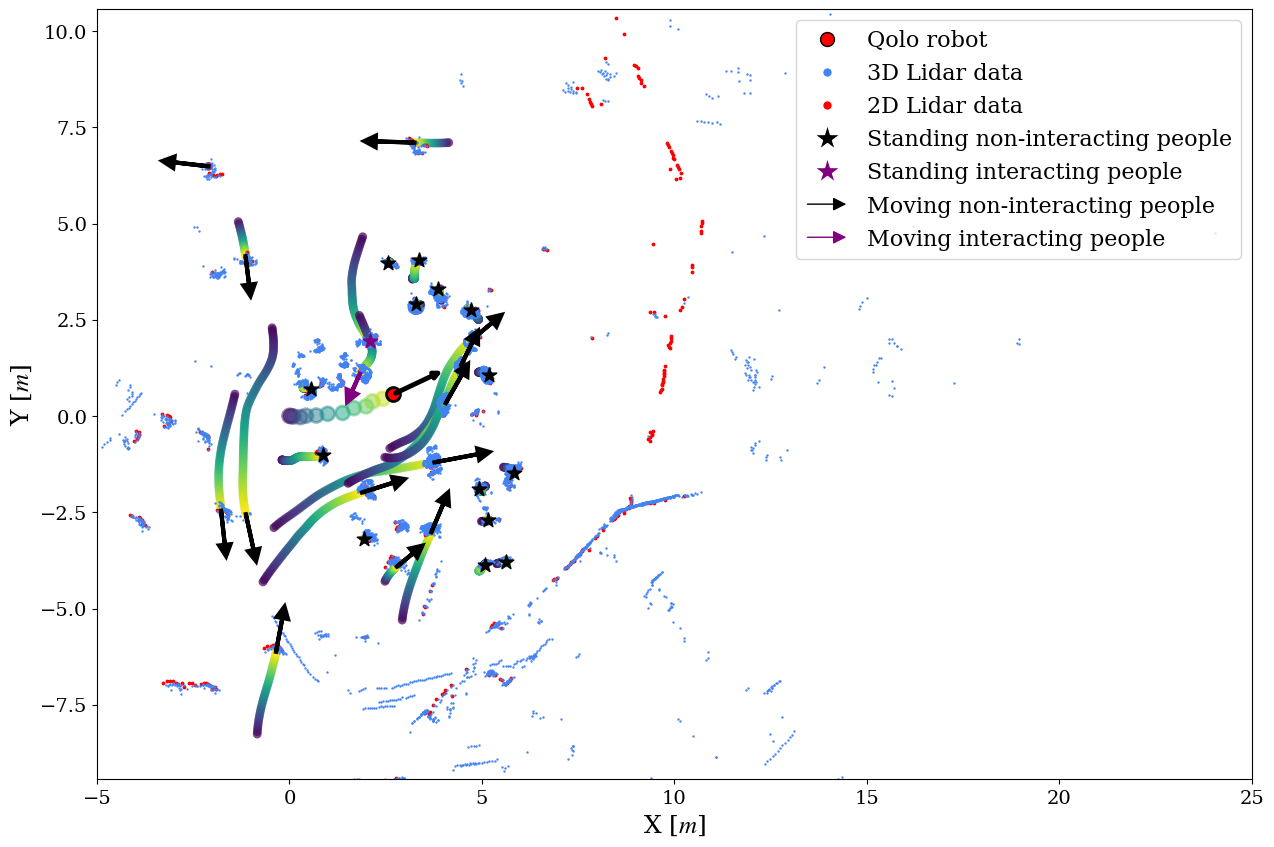

In [20]:
seq_idx, fr_idx = 15, 120

seq = cb_data.seqs[seq_idx]

lidar, lidar_nonground, lidar_2D, dets_gt, trks_gt, dets, dets_conf, trks, dets_2D, dets_2D_conf, trks_2D, dets_far, dets_far_conf, dets_2D_close, dets_2D_conf_close, trks_merged = cb_data[seq_idx, fr_idx]

consider_pose = True
if consider_pose:
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(
        tf_dir, seq + pose_suffix
    )
    lidar_pose_stamped = np.load(
        pose_stampe_path, allow_pickle=True
    ).item()

fig_xy = plt.figure(figsize=(16, 10))
fig_xy = display_frame_pose_traj(
    fig_xy, 
    peds_dict=pdd[seq_idx],
    peds_dict_other=None,
    pose_stamped=lidar_pose_stamped,
    fr_idx=fr_idx,
    pc=lidar.T,  
    ground_processor=None,
    with_cloud=True,
    with_id=False,
    filter_height=True,
    filter_height_add=0.1,
    plot_standing=True,
    plot_interacting=True,
    plot_vanishing=False,
    pc_pedestrian=False,
    max_dist=1,
    target_len=target_len[seq_idx],
    display_velocity_magnitudes=True,
    with_colorbar=False,
    device_interact_type=device_interact_type,
    pedestrian_interact_type=pedestrian_interact_type,
)

# Assuming fig_xy is your figure object that has been returned from a function
ax = fig_xy.axes[0]  # Retrieve the Axes object if there is only one subplot



pos = lidar_pose_stamped['position'][fr_idx,:]
quat = lidar_pose_stamped['orientation'][fr_idx,:]

# Define the circle parameters
radius = 5
circle = plt.Circle((pos[0], pos[1]), radius, color='magenta', fill=False)
# ax.add_artist(circle)
# Label the circle
# ax.text(pos[0], pos[1] + radius + 0.2, '5m radius', color='magenta', fontsize=8, ha='center')

if dataset == 'CROWDBOT':
    if '/scan_multi' in lidar_2D_keys:
        print('merged')
        l_2D = laserscan_to_xy_global(lidar_2D['/scan_multi']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/scan_multi')
        ax.scatter(l_2D[:,0], l_2D[:,1], color='#FF0000', s=3)
    if '/front_lidar/scan_modified' in lidar_2D_keys:
        print('modified')
        l_2D = laserscan_to_xy_global(lidar_2D['/front_lidar/scan_modified']['ranges'], laser_fov_deg=253.38, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/front_lidar/scan_modified')
        l_2D_1 = laserscan_to_xy_global(lidar_2D['/rear_lidar/scan_modified']['ranges'], laser_fov_deg=236.18, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/rear_lidar/scan_modified')
        # ax.scatter(l_2D[:,0], l_2D[:,1], color='green', s=2) # #DC143C
        # ax.scatter(l_2D_1[:,0], l_2D_1[:,1], color='#8B0000', s=5)
    if '/front_lidar/scan' in lidar_2D_keys:
        print('default')
        l_2D = laserscan_to_xy_global(lidar_2D['/front_lidar/scan']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/front_lidar/scan')
        l_2D_1 = laserscan_to_xy_global(lidar_2D['/rear_lidar/scan']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/rear_lidar/scan')
        # ax.scatter(l_2D[:,0], l_2D[:,1], color='#DC143C', s=2)
        # ax.scatter(l_2D_1[:,0], l_2D_1[:,1], color='#8B0000', s=2)
elif dataset == 'JRDB':
    trans_lasermulti_to_base = [0.0, 0.0, 0.0]
    quat_lasermulti_to_base = [0.0, 0.0, 0., 1.]
    pos_multi = pos + trans_lasermulti_to_base
    quat_multi = quaternion_multiply(quat_lasermulti_to_base, quat)
    l_2D = laserscan_to_xy_global(lidar_2D[lidar_2D_keys[0]]['ranges'], laser_fov_deg=360, max_dist=25, pos=pos_multi, quat=quat_multi, dataset=dataset, topic=lidar_2D_keys[0])
    ax.scatter(l_2D[:,0], l_2D[:,1], color='#FF0000', s=2)
else:
    pass

# Define the custom legend entries based on the details provided
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Qolo robot',
           markerfacecolor='red', markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='3D Lidar data',
           markerfacecolor=gs_blue_tuple, markersize=7),
    Line2D([0], [0], marker='o', color='w', label='2D Lidar data',
           markerfacecolor='red', markersize=7),
    Line2D([0], [0], marker='*', color='w', label='Standing non-interacting people',
           markerfacecolor='black', markersize=20),
    Line2D([0], [0], marker='*', color='w', label='Standing interacting people',
           markerfacecolor='purple', markersize=20),
    # Line2D([0], [0], marker='*', color='w', label='Ground truth standing people',
    #        markerfacecolor='red', markersize=10),
    FancyArrowPatch((0,0), (1,1), color='black', arrowstyle='-|>', mutation_scale=20, label='Moving non-interacting people'),
    FancyArrowPatch((0,0), (1,1), color='purple', arrowstyle='-|>', mutation_scale=20, label='Moving interacting people'),
    # FancyArrowPatch((0,0), (1,1), color='red', arrowstyle='-|>', mutation_scale=20, label='Ground truth moving people'),
]

# Create the legend, adding the custom handler for the arrow
ax.legend(handles=legend_elements, loc='upper right', handler_map={FancyArrowPatch: HandlerPatch(patch_func=make_legend_arrow),}, fontsize=16)
ax.set_xlim(-5, 25)

plt.show()

#### Video

In [21]:
# # Use a non-interactive backend
# gc.collect()
# plt.close('all')
# plt.switch_backend('Agg')

# def process_frame_full(args):
#     seq_idx, fr_idx, lidar_pose_stamped, device_count, peds_dict, peds_dict_other, lidar_2D_keys, cb_data, dataset, pedestrian_centered, result_seq_dict, with_id, plot_standing, plot_interacting, target_len = args
#     mpl.font_manager._get_font.cache_clear()
#     lidar, lidar_nonground, lidar_2D, = cb_data.get_lidar_data(seq_idx, fr_idx)

#     fig_xy = plt.figure(figsize=(16, 8))
#     canvas = FigureCanvas(fig_xy)  # Create a canvas for the figure
    
#     fig_xy = display_frame_pose_traj(
#         fig_xy, 
#         peds_dict=peds_dict,
#         peds_dict_other=peds_dict_other,
#         pose_stamped=lidar_pose_stamped,
#         fr_idx=fr_idx,
#         pc=lidar.T,  
#         ground_processor=None,
#         with_cloud=True,
#         with_colorbar=False,
#         with_id=with_id,
#         filter_height=True,
#         filter_height_add=0.05,
#         moving_velocity_thresh=0.4,
#         plot_standing=plot_standing,
#         plot_interacting=plot_interacting,
#         center_on_top_peds=pedestrian_centered,
#         result_seq_dict=result_seq_dict,
#         target_len=target_len,
#         display_velocity_magnitudes=True,
#         device_interact_type=device_interact_type,
#         pedestrian_interact_type=pedestrian_interact_type,
#     )

#     ax = fig_xy.axes[0]  # Retrieve the Axes object if there is only one subplot
#     pos = lidar_pose_stamped['position'][fr_idx,:]
#     quat = lidar_pose_stamped['orientation'][fr_idx,:]

#     # Define the circle parameters
#     radius = 4
#     circle = plt.Circle((pos[0], pos[1]), radius, color='magenta', fill=False)
#     ax.add_artist(circle)
#     # Label the circle
#     # ax.text(pos[0], pos[1] + radius + 0.2, f'2.5m circle - {device_count} people', color='magenta', fontsize=8, ha='center')
#     ax.text(pos[0], pos[1] + radius + 0.2, f'4m circle', color='magenta', fontsize=8, ha='center')
    
#     if dataset == 'CROWDBOT':
#         if '/scan_multi' in lidar_2D_keys:
#             l_2D = laserscan_to_xy_global(lidar_2D['/scan_multi']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/scan_multi')
#             ax.scatter(l_2D[:,0], l_2D[:,1], color='#FF0000', s=4)
#         if '/front_lidar/scan_modified' in lidar_2D_keys:
#             l_2D = laserscan_to_xy_global(lidar_2D['/front_lidar/scan_modified']['ranges'], laser_fov_deg=253.38, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/front_lidar/scan_modified')
#             l_2D_1 = laserscan_to_xy_global(lidar_2D['/rear_lidar/scan_modified']['ranges'], laser_fov_deg=236.18, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/rear_lidar/scan_modified')
#             ax.scatter(l_2D[:,0], l_2D[:,1], color='#DC143C', s=2)
#             ax.scatter(l_2D_1[:,0], l_2D_1[:,1], color='#8B0000', s=2)
#         if '/front_lidar/scan' in lidar_2D_keys:
#             l_2D = laserscan_to_xy_global(lidar_2D['/front_lidar/scan']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/front_lidar/scan')
#             l_2D_1 = laserscan_to_xy_global(lidar_2D['/rear_lidar/scan']['ranges'], laser_fov_deg=360, max_dist=25, pos=pos, quat=quat, dataset=dataset, topic='/rear_lidar/scan')
#     elif dataset == 'JRDB':
#         trans_lasermulti_to_base = [0.0, 0.0, 0.0]
#         quat_lasermulti_to_base = [0.0, 0.0, 0., 1.]
#         pos_multi = pos + trans_lasermulti_to_base
#         quat_multi = quaternion_multiply(quat_lasermulti_to_base, quat)
#         l_2D = laserscan_to_xy_global(lidar_2D[lidar_2D_keys[0]]['ranges'], laser_fov_deg=360, max_dist=25, pos=pos_multi, quat=quat_multi, dataset=dataset, topic=lidar_2D_keys[0])
#         ax.scatter(l_2D[:,0], l_2D[:,1], color='#FF0000', s=2)
#     else:
#         pass

#     # Define labels for black and red markers
#     if dataset == 'JRDB':
#         black_label = 'Ground Truth'
#     elif dataset == 'CROWDBOT':
#         black_label = 'Merged'
#     elif dataset == 'SiT':
#         black_label = 'Ground Truth'
#     else:
#         raise RuntimeError
#     red_label = '3D'

#     # Initialize the list of legend elements
#     legend_elements = [
#         Line2D([0], [0], marker='o', color='w', label='Qolo',
#             markerfacecolor='red', markeredgecolor='black', markersize=10),
#         Line2D([0], [0], marker='o', color='w', label='3D Lidar data',
#             markerfacecolor=gs_blue_tuple, markersize=10),
#         Line2D([0], [0], marker='o', color='w', label='2D Lidar data',
#             markerfacecolor='red', markersize=10),
#         Line2D([0], [0], marker='*', color='w', label=f'{black_label} standing people',
#             markerfacecolor='black', markersize=10),
#         FancyArrowPatch((0, 0), (1, 1), color='black', arrowstyle='-|>',
#                         mutation_scale=20, label=f'{black_label} moving people'),
#     ]

#     # Conditionally add the red markers if peds_dict_other is not None
#     if peds_dict_other is not None:
#         legend_elements.append(Line2D([0], [0], marker='*', color='w', label=f'{red_label} standing people',
#                                     markerfacecolor='red', markersize=10))
#         legend_elements.append(FancyArrowPatch((0, 0), (1, 1), color='red', arrowstyle='-|>',
#                                             mutation_scale=20, label=f'{red_label} moving people'))

#     legend_elements.append(Line2D([0], [0], marker='*', color='w', label='Standing people min_dist>1',
#                                 markerfacecolor='red', markersize=10))
#     legend_elements.append(FancyArrowPatch((0, 0), (1, 1), color='red', arrowstyle='-|>',
#                                         mutation_scale=20, label='Moving people min_dist>1'))

#     # Conditionally add the orange hexagon marker if pedestrian_centered is True
#     if pedestrian_centered:
#         legend_elements.append(Line2D([0], [0], marker='h', color='w', label='Selected pedestrians for interaction',
#                                     markerfacecolor='orange', markersize=10))


#     # Create the legend, adding the custom handler for the arrow
#     ax.legend(handles=legend_elements, loc='upper right', handler_map={FancyArrowPatch: HandlerPatch(patch_func=make_legend_arrow),})
#     # Apply tight layout to reduce margins
#     fig_xy.tight_layout()

#     canvas.draw()  # Render the figure using the canvas
#     img = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
#     img = img.reshape(int(fig_xy.get_size_inches()[1] * fig_xy.dpi), int(fig_xy.get_size_inches()[0] * fig_xy.dpi), 3)
#     img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     plt.close(fig_xy)

#     return img_bgr

# # Define your sequence index and other necessary parameters
# for seq_idx in [0]:
#     gc.collect()
#     seq = cb_data.seqs[seq_idx]

#     if consider_pose:
#         tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
#         pose_stampe_path = os.path.join(tf_dir, seq + pose_suffix)
#         lidar_pose_stamped = np.load(pose_stampe_path, allow_pickle=True).item()

#     if dataset == 'SiT':
#         step_viz = 1
#     else:
#         step_viz = 2

#     # Run the video creation function
#     create_video(process_frame_function=process_frame_full, seq_idx=seq_idx, target_len=target_len[seq_idx], cb_data=cb_data, lidar_pose_stamped=lidar_pose_stamped, device_metrics_df=device_metrics_df, pdd=pdd, pdd_other=None, lidar_2D_keys=lidar_2D_keys, dataset=dataset, video_name=f'Crowdbot_defaced_all_videos_default/ped_tracks_seq{seq_idx}_{dataset}_pos_{pos_smooth_len}_vel_{vel_smooth_len}_merged.mp4', step_viz=step_viz, plot_interacting=True, with_id=True, plot_standing=True, trim_pdd=True, start_end_drop_frames=start_end_drop_frames[seq_idx], num_workers=4)
# # Switch back to the interactive backend for Jupyter notebooks
# plt.switch_backend('module://ipykernel.pylab.backend_inline')

### Device Centered Analysis and Filtering

In [22]:
# Initialize a dictionary for all groups
groups_data = {
    'Interacting Pedestrians': {'indices_fn': lambda pd: (np.array(pd['distance_to_device']) <= non_interacting_distance_limit) & (np.array(pd[device_interact_type]))},
    f'Non-interacting Pedestrians under {non_interacting_distance_limit}m': {'indices_fn': lambda pd: (np.array(pd['distance_to_device']) <= non_interacting_distance_limit) & (~np.array(pd[device_interact_type]))},
}

def initialize_group_data():
    """Initializes empty lists for storing group data before converting them to a DataFrame."""
    return {
        'abs_pos_x': [],
        'abs_pos_y': [],
        'smooth_pos_x': [],
        'smooth_pos_y': [],
        'vel_nonsmooth_norm': [],
        'vel_smooth_norm': [],
        'acc': [],
        'jerk': [],
        'angular_velocity': [],
        'angular_acceleration': [],
        'angular_jerk': [],
        'orientation_deg': [],
        'distance_to_device': [],
        'device_velocity': [],
        'crowd_density_comfort_ppsm': [],
        'crowd_density_social_ppsm': [],
        'crowd_density_group_comfort_ppsm': [],
        'crowd_density_group_social_ppsm': [],
        'crowd_group_comfort_unique_count_cum': [],
        'minimum_distance': [],
        'minimum_distance_interact': [],
        'seq_idx': [],
        'frame_idx': [],
        'ped_id': [],
        'ped_viz_id': []
    }

# Initialize lists for each group's data
for group_name in groups_data:
    groups_data[group_name]['data'] = initialize_group_data()

# Temporary storage for 'Similar Distribution Interacting' group
temp_data = initialize_group_data()
temp_added = False


# Create an empty list to collect all valid data
all_valid_data = initialize_group_data()

# Initialize empty dictionary to hold group membership columns (will be filled later)
group_membership = {group_name: [] for group_name in groups_data.keys()}

# for seq_idx in range(cb_data.nr_seqs()):
for seq_idx in pdd.keys():
    if jrdb_only_chosen_sequences_df and dataset == 'JRDB' and seq_idx not in jrdb_yes_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    elif crowdbot_only_chosen_sequences_df and dataset == 'CROWDBOT' and seq_idx in crowdbot_no_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    # elif sit_only_chosen_sequences_df and dataset == 'SiT' and seq_idx in sit_no_sequences:
    elif sit_only_chosen_sequences_df and dataset == 'SiT' and seq_idx not in sit_yes_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    else:
        pass
    # Load lidar_pose_stamped for the current sequence
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(tf_dir, cb_data.seqs[seq_idx] + pose_suffix)
    lidar_pose_stamped = np.load(pose_stampe_path, allow_pickle=True).item()

    # Calculate invalid indices for the sequence
    if dataset == 'SiT':
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=20, end_of_turn_threshold_factor=0.1, turn_angle_threshold=90,)    
    else:
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=10, end_of_turn_threshold_factor=0.1, turn_angle_threshold=60,)   

    if trim_tracklet_start_end:
        peds_dict = trim_peds_dict(pdd[seq_idx], start_end_drop_frames[seq_idx]) # USE ONLY TRIMMED TRACKLETS (START AND END IS CUT OFF)
        targ_len = target_len[seq_idx] - start_end_drop_frames[seq_idx]*2
    else:
        peds_dict = pdd[seq_idx]
        targ_len = target_len[seq_idx]

    _, selected_ped_ids = get_len_less(peds_dict, target_len=targ_len)

    for ped_id in peds_dict:

        if ped_id not in selected_ped_ids:
            continue
        ped_dict = peds_dict[ped_id]
        if not ped_dict.get('movement_detected', False):
            continue

        # Pre-extract data as NumPy arrays for efficiency
        abs_pos_x = np.array(ped_dict.get('abs_pose_list', []))[:,0]
        abs_pos_y = np.array(ped_dict.get('abs_pose_list', []))[:,1]
        smooth_pos_x = np.array(ped_dict.get('pos_smooth', []))[:,0]
        smooth_pos_y = np.array(ped_dict.get('pos_smooth', []))[:,1]
        vel_nonsmooth_norm = np.array(ped_dict.get('vel_nonsmooth_norm', []))
        vel_smooth_norm = np.array(ped_dict.get('vel_smooth_norm', []))
        acc_signed = np.array(ped_dict.get('acc_signed', []))
        jerk_signed = np.array(ped_dict.get('jerk_signed', []))
        angular_velocity = np.array(ped_dict.get('angular_velocity', []))
        angular_acceleration = np.array(ped_dict.get('angular_acceleration', []))
        angular_jerk = np.array(ped_dict.get('angular_jerk', []))
        orientation_deg = np.array(ped_dict.get('orient_deg', []))
        distance_to_device = np.array(ped_dict.get('distance_to_device', []))
        device_velocity = np.array(ped_dict.get('device_velocity', []))
        crowd_density_comfort_ppsm = np.array(ped_dict.get('crowd_density_comfort_ppsm', []))
        crowd_density_social_ppsm = np.array(ped_dict.get('crowd_density_social_ppsm', []))
        crowd_density_group_comfort_ppsm = np.array(ped_dict.get('crowd_density_group_comfort_ppsm', []))
        crowd_density_group_social_ppsm = np.array(ped_dict.get('crowd_density_group_social_ppsm', []))
        crowd_group_comfort_unique_count_cum = np.array(ped_dict.get('crowd_group_comfort_unique_count_cum', []))
        minimum_distance = np.array(ped_dict.get('minimum_distance', []))
        minimum_distance_interact = np.array(ped_dict.get('minimum_distance_interact', []))
        frame_idx = np.array(ped_dict.get('fr_idx_list', []))
        ped_viz_id = ped_dict.get('id_viz', None)

        if len(vel_smooth_norm) == 0:
            continue

        # Store the valid data into the all_valid_data structure
        valid_frame_indices = np.setdiff1d(frame_idx, invalid_indices)
        valid_indices = np.isin(frame_idx, valid_frame_indices)

        all_valid_data['abs_pos_x'].append(abs_pos_x[valid_indices])
        all_valid_data['abs_pos_y'].append(abs_pos_y[valid_indices])
        all_valid_data['smooth_pos_x'].append(smooth_pos_x[valid_indices])
        all_valid_data['smooth_pos_y'].append(smooth_pos_y[valid_indices])
        all_valid_data['vel_nonsmooth_norm'].append(vel_nonsmooth_norm[valid_indices])
        all_valid_data['vel_smooth_norm'].append(vel_smooth_norm[valid_indices])
        all_valid_data['acc'].append(acc_signed[valid_indices])
        all_valid_data['jerk'].append(jerk_signed[valid_indices])
        all_valid_data['angular_velocity'].append(angular_velocity[valid_indices])
        all_valid_data['angular_acceleration'].append(angular_acceleration[valid_indices])
        all_valid_data['angular_jerk'].append(angular_jerk[valid_indices])
        all_valid_data['orientation_deg'].append(orientation_deg[valid_indices])
        all_valid_data['distance_to_device'].append(distance_to_device[valid_indices])
        all_valid_data['device_velocity'].append(device_velocity[valid_indices])
        all_valid_data['crowd_density_comfort_ppsm'].append(crowd_density_comfort_ppsm[valid_indices])
        all_valid_data['crowd_density_social_ppsm'].append(crowd_density_social_ppsm[valid_indices])
        all_valid_data['crowd_density_group_comfort_ppsm'].append(crowd_density_group_comfort_ppsm[valid_indices])
        all_valid_data['crowd_density_group_social_ppsm'].append(crowd_density_group_social_ppsm[valid_indices])
        all_valid_data['crowd_group_comfort_unique_count_cum'].append(crowd_group_comfort_unique_count_cum[valid_indices])
        all_valid_data['minimum_distance'].append(minimum_distance[valid_indices])
        all_valid_data['minimum_distance_interact'].append(minimum_distance_interact[valid_indices])
        all_valid_data['frame_idx'].append(frame_idx[valid_indices])
        all_valid_data['ped_id'].append(np.full(np.count_nonzero(valid_indices), ped_id))
        all_valid_data['ped_viz_id'].append(np.full(np.count_nonzero(valid_indices), ped_dict.get('id_viz', None)))
        all_valid_data['seq_idx'].append(np.full(np.count_nonzero(valid_indices), seq_idx))

        for group_name, group_info in groups_data.items():
            indices = group_info['indices_fn'](ped_dict)
            frame_indices = np.array(ped_dict['fr_idx_list'])
            valid_frame_indices = np.setdiff1d(frame_indices[indices], invalid_indices)
            indices = np.isin(frame_indices, valid_frame_indices)

            valid_group_indices = np.isin(frame_idx[valid_indices], frame_idx[indices])
            # Add True/False values to the group membership column for all data points
            group_membership[group_name].append(valid_group_indices)
            # Add group membership columns (boolean) to all_valid_dataframe

            if not np.any(indices):  # Skip empty indices
                continue
            
            if group_name.find('Similar Distribution Interacting') == -1:
                # Append data to lists for the group
                group_data = groups_data[group_name]['data']
                group_data['abs_pos_x'].append(abs_pos_x[indices])
                group_data['abs_pos_y'].append(abs_pos_y[indices])
                group_data['smooth_pos_x'].append(smooth_pos_x[indices])
                group_data['smooth_pos_y'].append(smooth_pos_y[indices])
                group_data['vel_nonsmooth_norm'].append(vel_nonsmooth_norm[indices])
                group_data['vel_smooth_norm'].append(vel_smooth_norm[indices])
                group_data['acc'].append(acc_signed[indices])
                group_data['jerk'].append(jerk_signed[indices])
                group_data['angular_velocity'].append(angular_velocity[indices])
                group_data['angular_acceleration'].append(angular_acceleration[indices])
                group_data['angular_jerk'].append(angular_jerk[indices])
                group_data['orientation_deg'].append(orientation_deg[indices])
                group_data['distance_to_device'].append(distance_to_device[indices])  
                group_data['device_velocity'].append(device_velocity[indices])  
                group_data['crowd_density_comfort_ppsm'].append(crowd_density_comfort_ppsm[indices])
                group_data['crowd_density_social_ppsm'].append(crowd_density_social_ppsm[indices])
                group_data['crowd_density_group_comfort_ppsm'].append(crowd_density_group_comfort_ppsm[indices])
                group_data['crowd_density_group_social_ppsm'].append(crowd_density_group_social_ppsm[indices])
                group_data['crowd_group_comfort_unique_count_cum'].append(crowd_group_comfort_unique_count_cum[indices])
                group_data['minimum_distance'].append(minimum_distance[indices])
                group_data['minimum_distance_interact'].append(minimum_distance_interact[indices])
                group_data['seq_idx'].append(np.full(indices.sum(), seq_idx))
                group_data['frame_idx'].append(frame_idx[indices])
                group_data['ped_id'].append(np.full(indices.sum(), ped_id))
                group_data['ped_viz_id'].append(np.full(indices.sum(), ped_viz_id))
            elif group_name.find('Similar Distribution Interacting') != -1 and not temp_added:
                temp_added = True
                # Store the data in temp_data for stratified sampling later
                temp_data['abs_pos_x'].append(abs_pos_x[indices])
                temp_data['abs_pos_y'].append(abs_pos_y[indices])
                temp_data['smooth_pos_x'].append(smooth_pos_x[indices])
                temp_data['smooth_pos_y'].append(smooth_pos_y[indices])
                temp_data['vel_nonsmooth_norm'].append(vel_nonsmooth_norm[indices])
                temp_data['vel_smooth_norm'].append(vel_smooth_norm[indices])
                temp_data['acc'].append(acc_signed[indices])
                temp_data['jerk'].append(jerk_signed[indices])
                temp_data['angular_velocity'].append(angular_velocity[indices])
                temp_data['angular_acceleration'].append(angular_acceleration[indices])
                temp_data['angular_jerk'].append(angular_jerk[indices])
                temp_data['orientation_deg'].append(orientation_deg[indices])
                temp_data['distance_to_device'].append(distance_to_device[indices])
                temp_data['device_velocity'].append(device_velocity[indices])
                temp_data['crowd_density_comfort_ppsm'].append(crowd_density_comfort_ppsm[indices])
                temp_data['crowd_density_social_ppsm'].append(crowd_density_social_ppsm[indices])
                temp_data['crowd_density_group_comfort_ppsm'].append(crowd_density_group_comfort_ppsm[indices])
                temp_data['crowd_density_group_social_ppsm'].append(crowd_density_group_social_ppsm[indices])
                temp_data['crowd_group_comfort_unique_count_cum'].append(crowd_group_comfort_unique_count_cum[indices])
                temp_data['minimum_distance'].append(minimum_distance[indices])
                temp_data['minimum_distance_interact'].append(minimum_distance_interact[indices])
                temp_data['seq_idx'].append(np.full(indices.sum(), seq_idx))
                temp_data['frame_idx'].append(frame_idx[indices])
                temp_data['ped_id'].append(np.full(indices.sum(), ped_id))
                temp_data['ped_viz_id'].append(np.full(indices.sum(), ped_viz_id))
            else:
                pass
        temp_added = False

# Finalize data processing by converting lists to arrays and then DataFrames
for group_name, group_info in groups_data.items():
    for metric, data_list in group_info['data'].items():
        group_info['data'][metric] = np.concatenate(data_list) if data_list else np.array([], dtype=np.float64)
    # Convert to DataFrame
    groups_data[group_name]['data'] = pd.DataFrame(groups_data[group_name]['data'])

# After looping, concatenate all valid data into a DataFrame
for metric, data_list in all_valid_data.items():
    all_valid_data[metric] = np.concatenate(data_list) if data_list else np.array([], dtype=np.float64)

# Create the all_valid_dataframe
all_valid_dataframe = pd.DataFrame(all_valid_data)

# Add group membership columns (boolean) to all_valid_dataframe
for group_name, membership_data in group_membership.items():
    all_valid_dataframe[group_name] = np.concatenate(membership_data)


Skipped sequence no. 11 for CROWDBOT
Skipped sequence no. 86 for CROWDBOT
Skipped sequence no. 88 for CROWDBOT
Skipped sequence no. 96 for CROWDBOT
Skipped sequence no. 97 for CROWDBOT


In [23]:
#-----------------PEDESTRIAN DATAFRAME FILTERING-----------------------------------------------------
all_valid_vel_filtered = all_valid_dataframe[
    (all_valid_dataframe['device_velocity'] >= device_velocity_thresh)
     & (all_valid_dataframe['vel_smooth_norm'] >= moving_velocity_thresh)
]

# pick the right "no-frames" dict for this dataset
no_frames_map = {
    'CROWDBOT': crowdbot_device_no_frames_dict,
    'JRDB':     jrdb_device_no_frames_dict,
    'SiT':      sit_device_no_frames_dict,
}

no_frames = no_frames_map.get(dataset, {})
# build one boolean mask: (seq_idx == key) & (frame_idx in any [start, end])
mask = pd.Series(False, index=all_valid_vel_filtered.index)

if filter_frames_pedestrians:
    for key, intervals in no_frames.items():
        key_mask = (all_valid_vel_filtered['seq_idx'] == key)
        if not key_mask.any():
            continue
        for start, end in intervals:
            # between is inclusive on both ends
            mask |= key_mask & all_valid_vel_filtered['frame_idx'].between(start, end)

    # drop the masked rows
    all_valid_vel_filtered = all_valid_vel_filtered.loc[~mask]

# --- Step 1: Group by Pedestrian and Calculate Densities ---
grouped = all_valid_vel_filtered.groupby(['seq_idx', 'ped_id']).agg(
    max_crowd_density=('crowd_density_social_ppsm', 'max'),
    avg_crowd_density=('crowd_density_social_ppsm', 'mean')
).reset_index()


# Apply cluster assignment
grouped['density_cluster'] = grouped.apply(
    lambda row: assign_cluster(row['max_crowd_density'], row['avg_crowd_density'], density_cluster_centroid),
    axis=1
)

# --- Step 3: Merge Cluster Assignments Back to All Rows ---
all_valid_vel_filtered = all_valid_vel_filtered.merge(
    grouped[['seq_idx', 'ped_id', 'max_crowd_density', 'avg_crowd_density', 'density_cluster']],
    on=['seq_idx', 'ped_id'],
    how='left'
)

# Filter for interacting and non-interacting pedestrians
all_interact_noninteract_vel_filtered = all_valid_vel_filtered[
    (all_valid_vel_filtered['Interacting Pedestrians'] == True) |
    (all_valid_vel_filtered[f'Non-interacting Pedestrians under {non_interacting_distance_limit}m'] == True)
]

print(f"Number of rows either interacting or under {non_interacting_distance_limit}m : ", all_interact_noninteract_vel_filtered.shape[0])

# --- Step 2: Identify Valid (seq_idx, ped_id) Pairs ---
valid_ped_seq_pairs = []
min_frames_list = []

# Iterate over each sequence index and its corresponding frequency
for seq_idx, seq_frequency in enumerate(frequency):
    # Calculate min_frames for this specific sequence
    min_frames = int(seq_frequency * 1.5)
    min_frames_list.append(min_frames)

    # Calculate interacting and non-interacting counts for the current sequence
    interacting_counts_seq = all_interact_noninteract_vel_filtered[
        (all_interact_noninteract_vel_filtered['seq_idx'] == seq_idx) &
        (all_interact_noninteract_vel_filtered['Interacting Pedestrians'] == True)
    ].groupby('ped_id').size()

    non_interacting_counts_seq = all_interact_noninteract_vel_filtered[
        (all_interact_noninteract_vel_filtered['seq_idx'] == seq_idx) &
        (all_interact_noninteract_vel_filtered['Interacting Pedestrians'] == False)
    ].groupby('ped_id').size()

    # Filter ped_id pairs that meet the min_frames requirement
    valid_pairs_seq = interacting_counts_seq[interacting_counts_seq >= min_frames].index.intersection(
        non_interacting_counts_seq[non_interacting_counts_seq >= min_frames].index
    )

    # Append valid pairs to the list
    valid_ped_seq_pairs.extend([(seq_idx, ped_id) for ped_id in valid_pairs_seq])

# Filter the dataframe for the valid (seq_idx, ped_id) pairs
filtered_valid_df = all_interact_noninteract_vel_filtered[all_interact_noninteract_vel_filtered.set_index(['seq_idx', 'ped_id']).index.isin(valid_ped_seq_pairs)]
# --- Step 3: Calculate Normalized Differences and Track-Level Crowd Density ---
normalized_differences = []

# Iterate over valid pairs to calculate differences and track-level crowd density
for seq_idx, ped_id in valid_ped_seq_pairs:
    ped_data = all_interact_noninteract_vel_filtered[
        (all_interact_noninteract_vel_filtered['seq_idx'] == seq_idx) &
        (all_interact_noninteract_vel_filtered['ped_id'] == ped_id)
    ]
    ped_data_angular = ped_data[ped_data['vel_smooth_norm'] >= velocity_for_angular_velocity_threshold]

    # Calculate track-level crowd density
    avg_crowd_density = ped_data['crowd_density_social_ppsm'].mean()

    # Separate interacting and non-interacting data
    interacting_data = ped_data[ped_data['Interacting Pedestrians'] == True]
    non_interacting_data = ped_data[ped_data['Interacting Pedestrians'] == False]

    interacting_data_angular = ped_data_angular[ped_data_angular['Interacting Pedestrians'] == True]
    non_interacting_data_angular = ped_data_angular[ped_data_angular['Interacting Pedestrians'] == False]

    # Calculate mean values (absolute)
    mean_interacting_acc = abs(interacting_data['acc']).mean()
    mean_non_interacting_acc = abs(non_interacting_data['acc']).mean()
    mean_acc = abs(ped_data['acc']).mean()

    # Calculate mean values (absolute)
    mean_interacting_jerk = abs(interacting_data['jerk']).mean()
    mean_non_interacting_jerk = abs(non_interacting_data['jerk']).mean()
    mean_jerk = abs(ped_data['jerk']).mean()

    mean_interacting_angular_velocity = abs(interacting_data_angular['angular_velocity']).mean()
    mean_non_interacting_angular_velocity = abs(non_interacting_data_angular['angular_velocity']).mean()
    mean_angular_velocity = abs(ped_data_angular['angular_velocity']).mean()

    # Calculate differences (absolute values)
    acc_difference = mean_interacting_acc - mean_non_interacting_acc
    jerk_difference = mean_interacting_jerk - mean_non_interacting_jerk
    angular_velocity_difference = mean_interacting_angular_velocity - mean_non_interacting_angular_velocity

    # Normalize the differences
    acc_normalized = acc_difference / mean_acc if mean_acc != 0 else float('nan')
    jerk_normalized = jerk_difference / mean_jerk if mean_jerk != 0 else float('nan')
    angular_velocity_normalized = angular_velocity_difference / mean_angular_velocity if mean_angular_velocity != 0 else float('nan')

    normalized_differences.append({
        'seq_idx': seq_idx,
        'ped_id': ped_id,
        'acc_normalized': acc_normalized,
        'jerk_normalized': jerk_normalized,
        'angular_velocity_normalized': angular_velocity_normalized,
        'track_crowd_density': avg_crowd_density  # Add track-level crowd density
    })

# Convert to DataFrame
normalized_differences_df = pd.DataFrame(normalized_differences)

#-----------------DEVICE DATAFRAME FILTERING-----------------------------------------------------
# Step 1: Group the data by seq_idx and frame_idx
grouped_frames = all_valid_dataframe.groupby(['seq_idx', 'frame_idx'])

# Step 5: Calculate mean densities
device_metrics_valid_df = device_metrics_df[device_metrics_df['valid_frame'] == True]


# Apply velocity threshold and create new filtered dataframes
if dataset == 'SiT' or dataset == 'CROWDBOT': 
    device_metrics_valid_vel_df = device_metrics_valid_df[(device_metrics_valid_df['device_velocity'] >= moving_velocity_thresh)
                                                    #    & (device_metrics_valid_df['minimum_distance'] < minimum_distance_thresh)
                                                    ]
else: # No velocity filtering for JRDB as it's mostly static
    device_metrics_valid_vel_df = device_metrics_valid_df

# build one boolean mask: (seq_idx == key) & (frame_idx in any [start, end])
mask = pd.Series(False, index=device_metrics_valid_vel_df.index)

if filter_frames_device:
    for key, intervals in no_frames.items():
        key_mask = (device_metrics_valid_vel_df['seq_idx'] == key)
        if not key_mask.any():
            continue
        for start, end in intervals:
            # between is inclusive on both ends
            mask |= key_mask & device_metrics_valid_vel_df['fr_idx'].between(start, end)
    # drop the masked rows
    device_metrics_valid_vel_df = device_metrics_valid_vel_df.loc[~mask]

# --- Step 1: Group by seq_idx to calculate max and average densities ---
device_seq_grouped = device_metrics_valid_vel_df.groupby('seq_idx').agg(
    max_crowd_density=('device_density_social_ppsm', 'max'),
    avg_crowd_density=('device_density_social_ppsm', 'mean')
).reset_index()

# Apply cluster assignment for each seq_idx
device_seq_grouped['density_cluster'] = device_seq_grouped.apply(
    lambda row: assign_cluster(row['max_crowd_density'], row['avg_crowd_density'], density_cluster_centroid),
    axis=1
)

# --- Step 3: Merge Cluster Assignments Back to device_metrics_df ---
device_metrics_valid_vel_df = device_metrics_valid_vel_df.merge(
    device_seq_grouped[['seq_idx', 'density_cluster']],
    on='seq_idx',
    how='left'
)

cluster_counts = device_seq_grouped['density_cluster'].value_counts().sort_index()
print("Number of sequences per cluster:")
for cluster_id, count in cluster_counts.items():
    print(f"\nCluster {cluster_id}: {count} sequences")
    cluster_seq = device_seq_grouped.loc[device_seq_grouped['density_cluster'] == cluster_id, 'seq_idx'].tolist()
    print(f"seq_idx: {', '.join(map(str, cluster_seq))}")

Number of rows either interacting or under 5m :  1131251
Number of sequences per cluster:

Cluster 0: 48 sequences
seq_idx: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 60, 62, 64, 66, 69, 79, 81

Cluster 1: 42 sequences
seq_idx: 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 30, 39, 56, 59, 61, 63, 65, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 84, 85, 87, 89, 90, 91, 92, 94, 95

Cluster 2: 3 sequences
seq_idx: 82, 83, 93


In [24]:
# unique pairs as a DataFrame …
unique_pairs = all_valid_vel_filtered[['seq_idx', 'frame_idx']].drop_duplicates()

# … and how many there are
num_unique_pairs = unique_pairs.shape[0]          # or: len(unique_pairs)

print(num_unique_pairs)

218701


### Main Comparisons

In [25]:
with pd.option_context('display.max_columns', None, 'display.max_rows', 100, 'display.width', 1000,):
    print(all_valid_vel_filtered)

         abs_pos_x  abs_pos_y  smooth_pos_x  smooth_pos_y  vel_nonsmooth_norm  vel_smooth_norm       acc      jerk  angular_velocity  angular_acceleration  angular_jerk  orientation_deg  distance_to_device  device_velocity  crowd_density_comfort_ppsm  crowd_density_social_ppsm  crowd_density_group_comfort_ppsm  crowd_density_group_social_ppsm  crowd_group_comfort_unique_count_cum  minimum_distance  minimum_distance_interact  seq_idx  frame_idx  ped_id  ped_viz_id  Interacting Pedestrians  Non-interacting Pedestrians under 5m  max_crowd_density  avg_crowd_density  density_cluster
0        -3.408708  -1.534229     -3.402856     -1.582296            0.967415         0.969579  0.114471 -0.181072          0.030046              0.067653     -0.333868       -22.652718            3.727314         0.000262                         0.0                   0.000000                               0.0                         0.000000                                     0          7.083721              

/tmp/ipykernel_184249/3909371601.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
/tmp/ipykernel_184249/3909371601.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize)


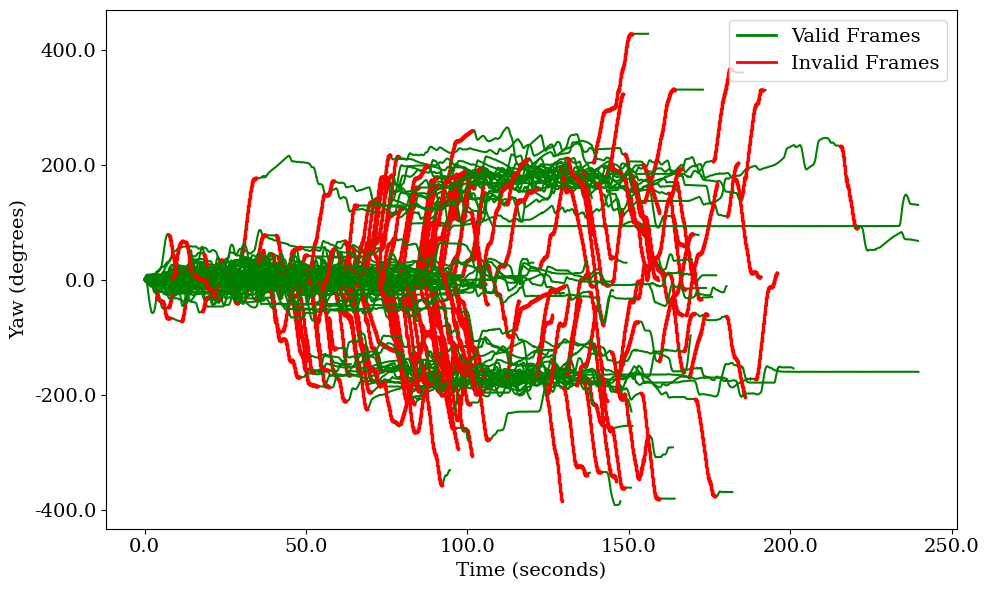

In [26]:
fontsize=14
# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through each sequence index
for seq_idx in range(cb_data.nr_seqs()):
# for seq_idx in range(3):
    # Load the lidar_pose_stamped data for the current sequence
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(tf_dir, cb_data.seqs[seq_idx] + pose_suffix)
    lidar_pose_stamped = np.load(pose_stampe_path, allow_pickle=True).item()

    # Get valid and invalid indices using the function
    if dataset == 'SiT':
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=20, end_of_turn_threshold_factor=0.1, turn_angle_threshold=90,)    
    else:
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=10, end_of_turn_threshold_factor=0.1, turn_angle_threshold=60,)       

    # Ensure indices are integer types
    valid_indices = valid_indices.astype(int)
    invalid_indices = invalid_indices.astype(int)

    # Convert quaternions to Euler angles and unwrap yaw angles
    quaternions = np.array(lidar_pose_stamped['orientation'])
    euler_angles = R.from_quat(quaternions).as_euler('xyz', degrees=True)
    yaw_angles = np.unwrap(euler_angles[:, 2])

    # Calculate time in seconds for the current sequence
    time_in_seconds = np.arange(len(yaw_angles)) / frequency[seq_idx]

    # Plot the valid yaw angles for the current sequence
    ax.plot(time_in_seconds, yaw_angles, color='green', linewidth=1.5)

    # Plot the invalid yaw angles for the current sequence
    ax.plot(time_in_seconds[invalid_indices], yaw_angles[invalid_indices], 'o', color='red', markersize=1.5)

# Define custom handles for valid and invalid frames in the legend
legend_handles = [
    Line2D([0], [0], color='green', lw=2, label='Valid Frames'),
    Line2D([0], [0], color='red', lw=2, label='Invalid Frames')  # Use line for invalid frames instead of points
]

# Add the legend to the plot
ax.legend(handles=legend_handles, loc='upper right', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticks(), fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), fontsize=fontsize)

# Update layout for titles and labels
# ax.set_title(f'Yaw (Z-Rotation) over Time with Valid and Invalid Frames for All Sequences - {dataset}')
ax.set_xlabel('Time (seconds)', fontsize=fontsize)
ax.set_ylabel('Yaw (degrees)', fontsize=fontsize)

# Show the plot
plt.tight_layout()
plt.show()


--- Pedestrians per Cluster ---
Low Density: 6812 pedestrians
Medium Density: 4903 pedestrians
High Density: 466 pedestrians

--- Sorted Cluster Centers ---
Low Density -> Max: 0.3133, Avg: 0.1535
Medium Density -> Max: 0.7858, Avg: 0.3883
High Density -> Max: 1.2412, Avg: 0.6766


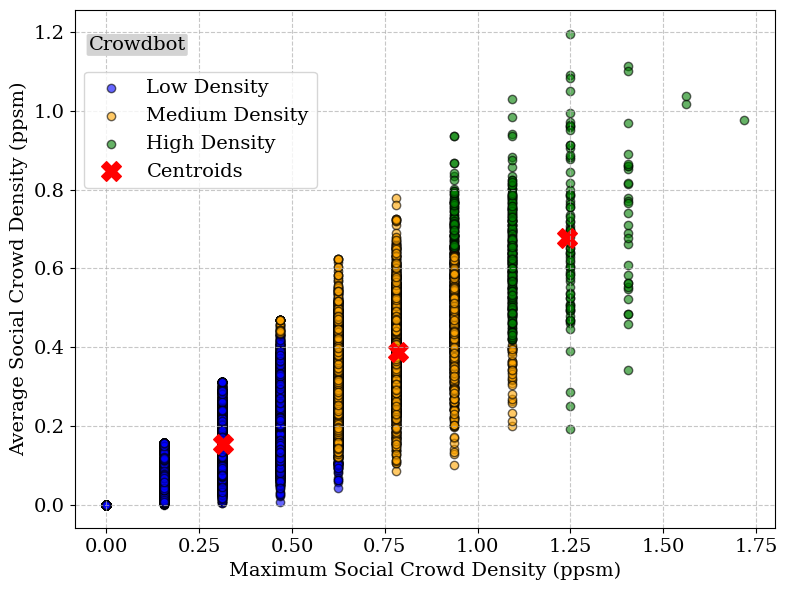

In [27]:
fontsize=14

all_int_nonint_max_avg_density = all_interact_noninteract_vel_filtered[['seq_idx', 'ped_id', 'max_crowd_density', 'avg_crowd_density']].drop_duplicates(subset=['seq_idx', 'ped_id'])
min_count_threshold = 20

# --- Step 2: Find and Exclude Outliers ---
density_counts = all_int_nonint_max_avg_density['max_crowd_density'].value_counts()
densities_to_exclude = density_counts[density_counts < min_count_threshold].index.tolist()
if 0 not in densities_to_exclude:
    densities_to_exclude.append(0)

excluded = all_int_nonint_max_avg_density[all_int_nonint_max_avg_density['max_crowd_density'].isin(densities_to_exclude)].copy()
included = all_int_nonint_max_avg_density[~all_int_nonint_max_avg_density['max_crowd_density'].isin(densities_to_exclude)].copy()

# --- Step 3: Compute Weights ---
value_counts = included['max_crowd_density'].value_counts()
included.loc[:, 'weight'] = included['max_crowd_density'].map(lambda x: 1 / value_counts[x])

# --- Step 4: Fit KMeans ---
X_included = included[['max_crowd_density', 'avg_crowd_density']]
weights = included['weight']

kmeans = KMeans(
    n_clusters=3, 
    init='k-means++', 
    random_state=96, 
    n_init=15, 
    max_iter=1000
)
kmeans.fit(X_included, sample_weight=weights)
included.loc[:, 'cluster'] = kmeans.labels_

# --- Step 5: Assign Excluded Points to Nearest Centroid ---
X_excluded = excluded[['max_crowd_density', 'avg_crowd_density']]
excluded.loc[:, 'cluster'] = kmeans.predict(X_excluded)

# --- Step 6: Combine Results ---
final_results = pd.concat([included, excluded], ignore_index=True)

# --- Step 7: Map Clusters to Density Labels ---
# Sort clusters by centroid position
centroids = kmeans.cluster_centers_
centroid_order = np.argsort(centroids[:, 0])  # Sort by max_crowd_density
cluster_to_density = {centroid_order[0]: 'Low Density', centroid_order[1]: 'Medium Density', centroid_order[2]: 'High Density'}
final_results['density_label'] = final_results['cluster'].map(cluster_to_density)

# Print number of points per cluster
print("\n--- Pedestrians per Cluster ---")
for cluster_id, label in cluster_to_density.items():
    count = (final_results['cluster'] == cluster_id).sum()
    print(f"{label}: {count} pedestrians")

# Print sorted cluster centers
print("\n--- Sorted Cluster Centers ---")
for this_track_idx in centroid_order:
    print(f"{cluster_to_density[this_track_idx]} -> Max: {centroids[this_track_idx, 0]:.4f}, Avg: {centroids[this_track_idx, 1]:.4f}")

# --- Step 8: Plot Results ---
plt.figure(figsize=(8, 6))
colors = {
    'Low Density': 'blue',
    'Medium Density': 'orange',
    'High Density': 'green'
}

for label, color in colors.items():
    subset = final_results[final_results['density_label'] == label]
    plt.scatter(
        subset['max_crowd_density'], 
        subset['avg_crowd_density'], 
        label=label, 
        c=color, 
        alpha=0.6, 
        edgecolors='k'
    )

# Plot centroids
plt.scatter(
    centroids[:, 0], 
    centroids[:, 1], 
    s=200, 
    c='red', 
    marker='X', 
    label='Centroids'
)

ax = plt.gca()                # current Axes object

if dataset == 'CROWDBOT':
    ax.text(0.02, 0.95,               # (x, y) in [0, 1] axes coords – 0.02 ≈ left edge
            'Crowdbot',
            transform=ax.transAxes,
            fontsize=fontsize,
            ha='left', va='top',
            bbox=dict(facecolor='lightgrey',
                    edgecolor='none',
                    boxstyle='round,pad=0.1'))

# plt.title('KMeans Clustering by Crowd Density (with Weights & Labels)')
plt.xlabel('Maximum Social Crowd Density (ppsm)', fontsize=fontsize)
plt.ylabel('Average Social Crowd Density (ppsm)', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
ax.legend(loc='upper left',
          bbox_to_anchor=(0.00, 0.90),     # (x, y) in axes-fraction coords
          bbox_transform=ax.transAxes,     # use the same coordinate system
          fontsize=fontsize)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Pedestrian Centered Analysis and Filtering

In [28]:
# Resultant dictionary
result_dict = {}
# Create an empty list to store pedestrian metrics
top_peds_metrics_list = []
minimum_top_length = 6

def add_pedestrian_distance_interact_multiple(
    ped_data,
    other_ped_data,
    ped_idx,
    other_idx,
    common_frames,
    distance_threshold,
    min_distance,
    max_distance,
    min_angle,
    max_angle,
    ttcc_threshold,
    collision_threshold,
    interact_extension_frames,
    pedestrian_radius,
    variants=None
):
    """
    Adds pedestrian interaction flags for default parameters and for sensitivity profiles.
    Optimizations:
      - vectorized dynamic angle threshold (get_dynamic_angle_threshold)
      - batch angle computation (angle_between_vectors supports 2D)
      - TTC remains scalar, evaluated once per sample per profile
    """
    if variants is None:
        variants = []

    # default profile
    default_profile = {
        "name": "interact",
        "distance_threshold": distance_threshold,
        "min_angle": min_angle,
        "max_angle": max_angle,
        "min_distance": min_distance,
        "max_distance": max_distance,
        "ttcc_threshold": ttcc_threshold,
        "collision_threshold": collision_threshold
    }

    # allow variants to override a subset of keys (minimal change, safer)
    all_profiles = []
    for v in [default_profile] + variants:
        p = default_profile.copy()
        p.update(v)
        all_profiles.append(p)

    # ---------------------------
    # Precompute profile-independent arrays
    # ---------------------------
    n = len(common_frames)

    ped_positions   = np.array([ped_data['pos_smooth'][ped_idx[i]][:2]   for i in range(n)], dtype=float)
    other_positions = np.array([other_ped_data['pos_smooth'][other_idx[i]][:2] for i in range(n)], dtype=float)

    ped_velocities   = np.array([ped_data['vel_smooth'][ped_idx[i]][:2]   for i in range(n)], dtype=float)
    other_velocities = np.array([other_ped_data['vel_smooth'][other_idx[i]][:2] for i in range(n)], dtype=float)

    # distances (center-to-center) and edge-to-edge distance
    distances      = np.linalg.norm(ped_positions - other_positions, axis=1)
    distances_edge = distances - 2.0 * pedestrian_radius

    # keep this return (unchanged)
    ped_velocities_norm = np.linalg.norm(ped_velocities, axis=1)

    # vector from "other" to "ped"
    vector_to_ped = ped_positions - other_positions

    angles_to_ped = angle_between_vectors(other_velocities, vector_to_ped)

    interact_results = {}

    # ---------------------------
    # Per-profile pass
    # ---------------------------
    for profile in all_profiles:
        key = 'pedestrian_' + profile["name"]

        dist_thr = profile["distance_threshold"]
        ttcc_thr = profile["ttcc_threshold"]

        # dynamic angle threshold for all frames (vectorized)
        dyn_thr_arr = get_dynamic_angle_threshold(
            distances_edge,
            profile["min_distance"], profile["max_distance"],
            profile["min_angle"],    profile["max_angle"]
        )

        # TTC per frame (scalar function; depends on collision_threshold per profile)
        ttcc_arr = np.empty(n, dtype=float)
        for i in range(n):
            ttcc_arr[i] = calculate_time_to_close_collision_edge(
                ped_position=ped_positions[i],
                ped_velocity=ped_velocities[i],
                other_position=other_positions[i],
                other_velocity=other_velocities[i],
                pedestrian_radius=pedestrian_radius,
                collision_threshold=profile["collision_threshold"],
                # ped vs ped case (defaults: distance_center=False, to_device=False)
            )

        interact_arr = (angles_to_ped <= dyn_thr_arr) & (ttcc_arr <= ttcc_thr)

        # Extend interactions over time using common_frames
        i = 0
        while i < n:
            if interact_arr[i]:
                current_frame = common_frames[i]
                i_next = i + 1
                while i_next < n and common_frames[i_next] <= current_frame + interact_extension_frames:
                    interact_arr[i_next] = True
                    i_next += 1
                i = i_next
            else:
                i += 1

        interact_results[key] = interact_arr.tolist()

    return distances.tolist(), ped_velocities_norm.tolist(), interact_results



# Main loop for processing sequences
for seq_idx in pdd.keys():

    # Define paths and load lidar pose stamped data
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(tf_dir, cb_data.seqs[seq_idx] + pose_suffix)
    lidar_pose_stamped = np.load(pose_stampe_path, allow_pickle=True).item()

    # Get valid and invalid indices using the function
    if dataset == 'SiT':
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=20, end_of_turn_threshold_factor=0.1, turn_angle_threshold=90,)    
    else:
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=10, end_of_turn_threshold_factor=0.1, turn_angle_threshold=60,) 

        
    length_threshold = int(minimum_top_length*frequency[seq_idx])

    required_frames = cb_data.nr_frames(seq_idx)

    if trim_tracklet_start_end:
        peds_dict = trim_peds_dict(pdd[seq_idx], start_end_drop_frames[seq_idx]) # USE ONLY TRIMMED TRACKLETS (START AND END IS CUT OFF)
        targ_len = target_len[seq_idx] - start_end_drop_frames[seq_idx]*2
    else:
        peds_dict = pdd[seq_idx]
        targ_len = target_len[seq_idx]
        
    _, ped_ids_more = get_len_less(peds_dict, length_threshold)

    # Initialize a list to store qualifying pedestrians
    qualified_peds = []

    # Add this once per sequence (before the pedestrians loops)
    require_different_group = True
    same_group_cache = {}  # key: (min_id, max_id) -> bool

    # Iterate through pedestrians and process efficiently
    for ped_id in ped_ids_more:
        ped_data = peds_dict[ped_id]

        # Extract relevant data as numpy arrays
        distances = np.array(ped_data['distance_to_device'])
        interactions = np.array(ped_data[device_interact_type])
        vel_norm = np.array(ped_data['vel_smooth_norm'])

        # Create masks for non-interacting frames within the distance limit
        non_interacting_mask = (distances <= non_interacting_distance_limit) & (~interactions)

        # Count total non-interacting frames
        non_interacting_count = np.sum(non_interacting_mask)

        # Count high-velocity non-interacting frames
        high_vel_non_interacting_count = np.sum(non_interacting_mask & (vel_norm > velocity_for_angular_velocity_threshold))

        # Check conditions for including this pedestrian
        if non_interacting_count > length_threshold and ped_data['movement_detected']:
            qualified_peds.append((ped_id, ped_data, non_interacting_count, high_vel_non_interacting_count))

    # Sort pedestrians by the count of high-velocity non-interacting frames
    # If two pedestrians have the same count, prioritize by total non-interacting count
    qualified_peds.sort(key=lambda x: (x[3], x[2]), reverse=True)

    # Calculate the number of pedestrians needed to meet or exceed the required frames
    total_frames = 0
    pedestrian_num = 0
    for ped in qualified_peds:
        ped_id = ped[0]  # ped[0] is the pedestrian ID
        total_frames += peds_dict[ped_id]['length']  # Use total frames for this pedestrian
        pedestrian_num += 1
        if total_frames >= required_frames:
            break

    # Select the top pedestrians
    # print(seq_idx, pedestrian_num)
    top_peds = qualified_peds[:min(pedestrian_num, len(qualified_peds))]

    _, selected_ped_ids = get_len_less(peds_dict, target_len=targ_len)

    for ped_id, ped_data, _, _ in top_peds:

        fr_idx_list = ped_data['fr_idx_list']  # Frame indices for the pedestrian
        comfort_density_ppsm = ped_data['crowd_density_comfort_ppsm']  # Crowd density for each frame
        social_density_ppsm = ped_data['crowd_density_social_ppsm']  # Crowd density for each frame
        smooth_velocity = ped_data['vel_smooth_norm']  # Smooth velocity norm
        minimum_distance = ped_data['minimum_distance']  # Minimum distance from the centered pedestrian
        centered_pedestrian_id_viz = ped_data['id_viz']  # Visual ID of the centered pedestrian

        # Create a dictionary for the entire ped_id at once
        data_dict = {
            'seq_idx': [seq_idx] * len(fr_idx_list),
            'fr_idx': fr_idx_list,
            'centered_pedestrian_id': [ped_id] * len(fr_idx_list),
            'centered_pedestrian_id_viz': [centered_pedestrian_id_viz] * len(fr_idx_list),
            'centered_pedestrian_comfort_density_ppsm': comfort_density_ppsm,
            'centered_pedestrian_social_density_ppsm': social_density_ppsm,
            'centered_pedestrian_velocity': smooth_velocity,
            'centered_pedestrian_minimum_distance': minimum_distance,
            'valid_frame': [fr_idx in valid_indices for fr_idx in fr_idx_list]
        }

        # Convert dictionary to dataframe and append to the list
        top_peds_metrics_list.append(pd.DataFrame(data_dict))

        result_dict[seq_idx] = result_dict.get(seq_idx, {})
        result_dict[seq_idx][ped_id] = {}

        fr_idx_list = np.array(ped_data['fr_idx_list'])

        for other_ped_id in selected_ped_ids:
            if other_ped_id == ped_id:
                continue

            other_ped_data = peds_dict[other_ped_id]
            if not other_ped_data.get('movement_detected', False):
                continue

            # --- NEW: skip if same group (with caching to avoid recomputation) ---
            if require_different_group:
                pair_key = (ped_id, other_ped_id) if ped_id < other_ped_id else (other_ped_id, ped_id)
                sg = same_group_cache.get(pair_key)
                if sg is None:
                    sg = same_group_by_variation(other_ped_data, ped_data, minimum_len[seq_idx], max_group_variation)
                    same_group_cache[pair_key] = sg
                if sg:
                    continue
            # --- end NEW ---

            other_fr_idx_list = np.array(other_ped_data['fr_idx_list'])

            # Find common frames in the filtered lists
            common_frames, ped_idx, other_idx = np.intersect1d(fr_idx_list, other_fr_idx_list, return_indices=True)

            if common_frames.size == 0:
                continue

            distances, pedestrian_velocity_norm, pedestrian_interact_dict = add_pedestrian_distance_interact_multiple(
                ped_data=ped_data,
                other_ped_data=other_ped_data,
                ped_idx=ped_idx,
                other_idx=other_idx,
                common_frames=common_frames,
                distance_threshold=distance_threshold_interact,
                min_distance=min_distance_interact,
                max_distance=max_distance_interact,
                min_angle=min_angle_interact,
                max_angle=max_angle_interact,
                ttcc_threshold=ttcc_threshold_interact,
                collision_threshold=collision_threshold_interact,
                interact_extension_frames=interact_extension_frames[seq_idx],
                pedestrian_radius=pedestrian_radius,
                variants=sensitivity_variants,
            )

            result_dict[seq_idx][ped_id][other_ped_id] = {
                'distance_to_pedestrian': distances,
                'pedestrian_velocity': pedestrian_velocity_norm,
                'common_frames': common_frames.tolist()  # Save common frames as well
            }

            result_dict[seq_idx][ped_id][other_ped_id].update(pedestrian_interact_dict)

# Concatenate all dataframes into one
top_peds_metrics_df = pd.concat(top_peds_metrics_list, ignore_index=True)

In [29]:
# Initialize group data for pedestrian-centered interaction
def initialize_group_data_ped():
    """Initializes an empty dictionary structure for storing group data."""
    return {
        'abs_pos_x': [],
        'abs_pos_y': [],
        'smooth_pos_x': [],
        'smooth_pos_y': [],
        'vel_nonsmooth_norm': [],
        'vel_smooth_norm': [],
        'acc': [],
        'jerk': [],
        'angular_velocity': [],
        'angular_velocity': [],
        'angular_acceleration': [],
        'angular_jerk': [],
        'orientation_deg': [],
        'distance_to_pedestrian': [],
        'pedestrian_velocity': [],
        'crowd_density_comfort_ppsm': [],
        'crowd_density_social_ppsm': [],
        'minimum_distance': [],
        'centered_ped_id': [],           # Renamed from ped_id to centered_ped_id
        'interacting_ped_id': [],        # Renamed from other_ped_id to interacting_ped_id
        'centered_ped_viz_id': [],       # Added centered_ped_viz_id
        'interacting_ped_viz_id': [],    # Added interacting_ped_viz_id
        'seq_idx': []        ,            # Keep seq_idx
        'frame_idx': [],
    }

# Initialize a dictionary for all groups
groups_data = {
    'Pedestrian-Centered Interacting': {'data': initialize_group_data_ped()},
    f'Pedestrian-Centered Non-Interacting under {non_interacting_distance_limit}m': {'data': initialize_group_data_ped()},
}

# Create an empty list to collect all valid data
all_valid_data_pedestrian = initialize_group_data_ped()

# Initialize empty dictionary to hold group membership columns (will be filled later)
group_membership = {group_name: [] for group_name in groups_data.keys()}

# Iterate over each sequence and process the data
for seq_idx, seq_data in tqdm.tqdm(result_dict.items(), desc="Processing sequences"):

    if jrdb_only_chosen_sequences_df and dataset == 'JRDB' and seq_idx not in jrdb_yes_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    elif crowdbot_only_chosen_sequences_df and dataset == 'CROWDBOT' and seq_idx in crowdbot_no_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    # elif sit_only_chosen_sequences_df and dataset == 'SiT' and seq_idx in sit_no_sequences:
    elif sit_only_chosen_sequences_df and dataset == 'SiT' and seq_idx not in sit_yes_sequences:
        print(f'Skipped sequence no. {seq_idx} for {dataset}')
        continue
    else:
        pass

        # Load lidar_pose_stamped for the current sequence
    tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
    pose_stampe_path = os.path.join(tf_dir, cb_data.seqs[seq_idx] + pose_suffix)
    lidar_pose_stamped = np.load(pose_stampe_path, allow_pickle=True).item()

    # Calculate invalid indices for the sequence
    if dataset == 'SiT':
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=20, end_of_turn_threshold_factor=0.1, turn_angle_threshold=90,)    
    else:
        valid_indices, invalid_indices = find_valid_invalid_frames(lidar_pose_stamped, frequency=frequency[seq_idx], window_size=int(2*frequency[seq_idx]), threshold_degrees_per_sec=10, end_of_turn_threshold_factor=0.1, turn_angle_threshold=60,)   

    if trim_tracklet_start_end:
        peds_dict = trim_peds_dict(pdd[seq_idx], start_end_drop_frames[seq_idx]) # USE ONLY TRIMMED TRACKLETS (START AND END IS CUT OFF)
        targ_len = target_len[seq_idx] - start_end_drop_frames[seq_idx]*2
    else:
        peds_dict = pdd[seq_idx]
        targ_len = target_len[seq_idx]

    for ped_id, ped_data in seq_data.items():
        for other_ped_id, interaction_data in ped_data.items():
            # Retrieve common_frames
            common_frames = np.array(interaction_data['common_frames'])

            top_ped_data = peds_dict[ped_id]
            
            # Retrieve the other pedestrian's data from the original pdd
            other_ped_data = peds_dict[other_ped_id]
            other_fr_idx_list = np.array(other_ped_data['fr_idx_list'])

            valid_mask = np.isin(other_fr_idx_list, valid_indices)
            other_fr_idx_list_valid = other_fr_idx_list[valid_mask]  # Valid list
            # Find indices in the original other_fr_idx_list corresponding to common_frames
            other_all_common_valid_indices = np.array([np.where(other_fr_idx_list == frame)[0][0] for frame in common_frames if frame in other_fr_idx_list_valid])
            # Find indices of valid frames within common_frames
            other_interacting_common_valid_indices = np.array([idx for idx, frame in enumerate(common_frames) if frame in other_fr_idx_list_valid])

            assert other_all_common_valid_indices.size == other_interacting_common_valid_indices.size

            if other_all_common_valid_indices.size == 0:
                continue


            # Pre-extract data as NumPy arrays for efficiency
            abs_pos_x = np.array(other_ped_data.get('abs_pose_list', []))[other_all_common_valid_indices,0]
            abs_pos_y = np.array(other_ped_data.get('abs_pose_list', []))[other_all_common_valid_indices,1]
            smooth_pos_x = np.array(other_ped_data.get('pos_smooth', []))[other_all_common_valid_indices,0]
            smooth_pos_y = np.array(other_ped_data.get('pos_smooth', []))[other_all_common_valid_indices,1]
            vel_nonsmooth_norm = np.array(other_ped_data.get('vel_nonsmooth_norm', []))[other_all_common_valid_indices]
            vel_smooth_norm = np.array(other_ped_data.get('vel_smooth_norm', []))[other_all_common_valid_indices]
            acc_signed = np.array(other_ped_data.get('acc_signed', []))[other_all_common_valid_indices]
            jerk_signed = np.array(other_ped_data.get('jerk_signed', []))[other_all_common_valid_indices]
            angular_velocity = np.array(other_ped_data.get('angular_velocity', []))[other_all_common_valid_indices]
            angular_acceleration = np.array(other_ped_data.get('angular_acceleration', []))[other_all_common_valid_indices]
            angular_jerk = np.array(other_ped_data.get('angular_jerk', []))[other_all_common_valid_indices]
            orientation_deg = np.array(other_ped_data.get('orient_deg', []))[other_all_common_valid_indices]
            crowd_density_comfort_ppsm = np.array(other_ped_data.get('crowd_density_comfort_ppsm', []))[other_all_common_valid_indices]
            crowd_density_social_ppsm = np.array(other_ped_data.get('crowd_density_social_ppsm', []))[other_all_common_valid_indices]
            minimum_distance = np.array(other_ped_data.get('minimum_distance', []))[other_all_common_valid_indices]
            frame_idx = np.array(other_ped_data.get('fr_idx_list', []))[other_all_common_valid_indices]
            distance_to_device = np.array(other_ped_data.get('distance_to_device', []))[other_all_common_valid_indices]
            distance_to_pedestrian = np.array(interaction_data.get('distance_to_pedestrian', []))[other_interacting_common_valid_indices]
            pedestrian_velocity = np.array(interaction_data.get('pedestrian_velocity', []))[other_interacting_common_valid_indices]


            pedestrian_interact = np.array(interaction_data[pedestrian_interact_type])[other_interacting_common_valid_indices]
            common_frames = common_frames[other_interacting_common_valid_indices]

            
            # Retrieve the visualization IDs (viz_id) for the centered and interacting pedestrians
            centered_ped_viz_id = np.array(top_ped_data.get('id_viz', None))
            interacting_ped_viz_id = np.array(other_ped_data.get('id_viz', None))

            all_valid_data_pedestrian['abs_pos_x'].append(abs_pos_x)
            all_valid_data_pedestrian['abs_pos_y'].append(abs_pos_y)
            all_valid_data_pedestrian['smooth_pos_x'].append(smooth_pos_x)
            all_valid_data_pedestrian['smooth_pos_y'].append(smooth_pos_y)
            all_valid_data_pedestrian['vel_nonsmooth_norm'].append(vel_nonsmooth_norm)
            all_valid_data_pedestrian['vel_smooth_norm'].append(vel_smooth_norm)
            all_valid_data_pedestrian['acc'].append(acc_signed)
            all_valid_data_pedestrian['jerk'].append(jerk_signed)
            all_valid_data_pedestrian['angular_velocity'].append(angular_velocity)
            all_valid_data_pedestrian['angular_acceleration'].append(angular_acceleration)
            all_valid_data_pedestrian['angular_jerk'].append(angular_jerk)
            all_valid_data_pedestrian['orientation_deg'].append(orientation_deg)
            all_valid_data_pedestrian['distance_to_pedestrian'].append(distance_to_pedestrian)
            all_valid_data_pedestrian['pedestrian_velocity'].append(pedestrian_velocity)
            all_valid_data_pedestrian['crowd_density_comfort_ppsm'].append(crowd_density_comfort_ppsm)
            all_valid_data_pedestrian['crowd_density_social_ppsm'].append(crowd_density_social_ppsm)
            all_valid_data_pedestrian['minimum_distance'].append(minimum_distance)
            all_valid_data_pedestrian['frame_idx'].append(frame_idx)
            all_valid_data_pedestrian['centered_ped_id'].append(np.full(len(common_frames), ped_id))
            all_valid_data_pedestrian['interacting_ped_id'].append(np.full(len(common_frames), other_ped_id))
            all_valid_data_pedestrian['centered_ped_viz_id'].append(np.full(len(common_frames), centered_ped_viz_id))
            all_valid_data_pedestrian['interacting_ped_viz_id'].append(np.full(len(common_frames), interacting_ped_viz_id))
            all_valid_data_pedestrian['seq_idx'].append(np.full(len(common_frames), seq_idx))  # Repeat seq_idx
            

            # Identify interacting and non-interacting pedestrians under distance limit
            interacting_indices = (pedestrian_interact) & (distance_to_device <= non_interacting_distance_limit)
            non_interacting_indices = ((~pedestrian_interact) & (distance_to_device <= non_interacting_distance_limit))

            # Define the group mappings
            group_mappings = {
                'Pedestrian-Centered Interacting': interacting_indices,
                f'Pedestrian-Centered Non-Interacting under {non_interacting_distance_limit}m': non_interacting_indices,
            }

            if len(vel_smooth_norm) == 0:
                continue

            # Process each group
            for group_name, indices in group_mappings.items():
                
                group_membership[group_name].append(indices)

                if not np.any(indices):
                    continue

                # Aggregate data into the respective group without splitting or filtering
                group_data = groups_data[group_name]['data']

                group_data['abs_pos_x'].append(abs_pos_x[indices])
                group_data['abs_pos_y'].append(abs_pos_y[indices])
                group_data['smooth_pos_x'].append(smooth_pos_x[indices])
                group_data['smooth_pos_y'].append(smooth_pos_y[indices])
                group_data['vel_nonsmooth_norm'].append(vel_nonsmooth_norm[indices])
                group_data['vel_smooth_norm'].append(vel_smooth_norm[indices])
                group_data['acc'].append(acc_signed[indices])
                group_data['jerk'].append(jerk_signed[indices])
                group_data['angular_velocity'].append(angular_velocity[indices])
                group_data['angular_acceleration'].append(angular_acceleration[indices])
                group_data['angular_jerk'].append(angular_jerk[indices])
                group_data['orientation_deg'].append(orientation_deg[indices])
                group_data['distance_to_pedestrian'].append(distance_to_pedestrian[indices])
                group_data['pedestrian_velocity'].append(pedestrian_velocity[indices])
                group_data['crowd_density_comfort_ppsm'].append(crowd_density_comfort_ppsm[indices])
                group_data['crowd_density_social_ppsm'].append(crowd_density_social_ppsm[indices])
                group_data['minimum_distance'].append(minimum_distance[indices])
                group_data['frame_idx'].append(frame_idx[indices])
                group_data['centered_ped_id'].append(np.full(indices.sum(), ped_id))
                group_data['interacting_ped_id'].append(np.full(indices.sum(), other_ped_id))
                group_data['centered_ped_viz_id'].append(np.full(indices.sum(), centered_ped_viz_id))
                group_data['interacting_ped_viz_id'].append(np.full(indices.sum(), interacting_ped_viz_id))
                group_data['seq_idx'].append(np.full(indices.sum(), seq_idx))  # Repeat seq_idx

# Finalize data processing by converting lists to DataFrames
for group_name, group_info in groups_data.items():
    for metric, data_list in group_info['data'].items():
        groups_data[group_name]['data'][metric] = np.concatenate(data_list) if data_list else np.array([], dtype=np.float64)

    # Convert lists to DataFrame
    groups_data[group_name]['data'] = pd.DataFrame(groups_data[group_name]['data'])

# After looping, concatenate all valid data into a DataFrame
for metric, data_list in all_valid_data_pedestrian.items():
    all_valid_data_pedestrian[metric] = np.concatenate(data_list) if data_list else np.array([], dtype=np.float64)

# Create the all_valid_dataframe
all_valid_dataframe_pedestrian = pd.DataFrame(all_valid_data_pedestrian)

# Add group membership columns (boolean) to all_valid_dataframe
for group_name, membership_data in group_membership.items():
    all_valid_dataframe_pedestrian[group_name] = np.concatenate(membership_data)


Processing sequences:   0%|          | 0/98 [00:00<?, ?it/s]

Processing sequences:  13%|█▎        | 13/98 [00:01<00:06, 13.20it/s]

Skipped sequence no. 11 for CROWDBOT


Processing sequences:  92%|█████████▏| 90/98 [00:13<00:00, 15.35it/s]

Skipped sequence no. 86 for CROWDBOT
Skipped sequence no. 88 for CROWDBOT


Processing sequences: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]


Skipped sequence no. 96 for CROWDBOT
Skipped sequence no. 97 for CROWDBOT


In [30]:
all_valid_pedestrian_vel_filtered = all_valid_dataframe_pedestrian[
    (all_valid_dataframe_pedestrian['pedestrian_velocity'] >= device_velocity_thresh)
     &(all_valid_dataframe_pedestrian['vel_smooth_norm'] >= moving_velocity_thresh)
    #  & (all_valid_dataframe_pedestrian['minimum_distance'] < minimum_distance_thresh)
]

# --- Step 1: Extract Unique (seq_idx, ped_id) Pairs from all_valid_vel_filtered ---
valid_density_clusters = all_valid_vel_filtered[['seq_idx', 'ped_id', 'density_cluster']].drop_duplicates()

# Rename 'ped_id' to 'interacting_ped_id' for merging with all_valid_pedestrian_vel_filtered
valid_density_clusters = valid_density_clusters.rename(columns={'ped_id': 'interacting_ped_id'})

# --- Step 2: Merge Density Cluster Assignments ---
all_valid_pedestrian_vel_filtered = all_valid_pedestrian_vel_filtered.merge(
    valid_density_clusters,
    on=['seq_idx', 'interacting_ped_id'],
    how='left'
)

# --- Step 3: Check for Missing Assignments and Raise an Error if Found ---
if all_valid_pedestrian_vel_filtered['density_cluster'].isna().any():
    missing_pairs = all_valid_pedestrian_vel_filtered.loc[
        all_valid_pedestrian_vel_filtered['density_cluster'].isna(), 
        ['seq_idx', 'interacting_ped_id']
    ].drop_duplicates()
    
    raise ValueError(f"Missing density cluster assignments for the following (seq_idx, interacting_ped_id) pairs:\n{missing_pairs.to_string(index=False)}")

# Filter for interacting or non-interacting pedestrians within the distance limit
all_interact_noninteract_pedestrian_vel_filtered = all_valid_pedestrian_vel_filtered[
    (all_valid_pedestrian_vel_filtered['Pedestrian-Centered Interacting'] == True) |
    (all_valid_pedestrian_vel_filtered[f'Pedestrian-Centered Non-Interacting under {non_interacting_distance_limit}m'] == True)
]

all_interact_pedestrian = all_valid_pedestrian_vel_filtered[all_valid_pedestrian_vel_filtered['Pedestrian-Centered Interacting'] == True]

# 1. Choose only valid frames from top_peds_metrics_df
top_peds_metrics_valid_df = top_peds_metrics_df[top_peds_metrics_df['valid_frame'] == True]

print(f"Number of rows either interacting or under {non_interacting_distance_limit}m: ", all_interact_noninteract_pedestrian_vel_filtered.shape[0])

# --- Step 2: Identify Valid (seq_idx, interacting_ped_viz_id, centered_ped_id) Pairs ---
valid_ped_seq_pairs = []
min_frames_list = []

# Iterate over each sequence index and its corresponding frequency
for seq_idx, seq_frequency in enumerate(frequency):
    min_frames = int(seq_frequency * 1.5)  # Calculate min_frames for this specific sequence
    min_frames_list.append(min_frames)

    # Calculate interacting and non-interacting counts for the current sequence, grouped by interacting_ped_viz_id and centered_ped_id
    interacting_counts_seq = all_interact_noninteract_pedestrian_vel_filtered[
        (all_interact_noninteract_pedestrian_vel_filtered['seq_idx'] == seq_idx) &
        (all_interact_noninteract_pedestrian_vel_filtered['Pedestrian-Centered Interacting'] == True)
    ].groupby(['interacting_ped_viz_id', 'centered_ped_id']).size()

    non_interacting_counts_seq = all_interact_noninteract_pedestrian_vel_filtered[
        (all_interact_noninteract_pedestrian_vel_filtered['seq_idx'] == seq_idx) &
        (all_interact_noninteract_pedestrian_vel_filtered['Pedestrian-Centered Interacting'] == False)
    ].groupby(['interacting_ped_viz_id', 'centered_ped_id']).size()


    # Filter (interacting_ped_viz_id, centered_ped_id) pairs that meet the min_frames requirement for both interacting and non-interacting
    valid_pairs_seq = interacting_counts_seq[interacting_counts_seq >= min_frames].index.intersection(
        non_interacting_counts_seq[non_interacting_counts_seq >= min_frames].index
    )

    # Append the valid pairs for this sequence to the list
    valid_ped_seq_pairs.extend([(seq_idx, interacting_ped_viz_id, centered_ped_id) for interacting_ped_viz_id, centered_ped_id in valid_pairs_seq])

# --- Step 3: Calculate Normalized Differences and Track-Level Crowd Density ---
normalized_differences_pedestrian = []

for seq_idx, interacting_ped_viz_id, centered_ped_id in valid_ped_seq_pairs:
# for seq_idx, interacting_ped_viz_id in valid_ped_seq_pairs:
    min_frames = min_frames_list[seq_idx]  # Minimum frame threshold for angular velocity calculations

    ped_data = all_interact_noninteract_pedestrian_vel_filtered[
        (all_interact_noninteract_pedestrian_vel_filtered['seq_idx'] == seq_idx) 
        & (all_interact_noninteract_pedestrian_vel_filtered['interacting_ped_viz_id'] == interacting_ped_viz_id) 
        & (all_interact_noninteract_pedestrian_vel_filtered['centered_ped_id'] == centered_ped_id)
    ]

    # duplicates_exist = ped_data['frame_idx'].duplicated().any()
    # print("Are there duplicates in frame_idx?", duplicates_exist)

    ped_data_angular = ped_data[ped_data['vel_smooth_norm'] >= velocity_for_angular_velocity_threshold]

    # Calculate track-level crowd density
    avg_crowd_density = ped_data['crowd_density_social_ppsm'].mean()

    # Separate interacting and non-interacting data
    interacting_data = ped_data[ped_data['Pedestrian-Centered Interacting'] == True]
    non_interacting_data = ped_data[ped_data['Pedestrian-Centered Interacting'] == False]

    interacting_data_angular = ped_data_angular[ped_data_angular['Pedestrian-Centered Interacting'] == True]
    non_interacting_data_angular = ped_data_angular[ped_data_angular['Pedestrian-Centered Interacting'] == False]

    # Calculate mean values (absolute)
    mean_interacting_jerk = abs(interacting_data['jerk']).mean()
    mean_non_interacting_jerk = abs(non_interacting_data['jerk']).mean()

    # Calculate mean values (absolute)
    mean_interacting_acc = abs(interacting_data['acc']).mean()
    mean_non_interacting_acc = abs(non_interacting_data['acc']).mean()

    # Check if interacting and non-interacting data meet the minimum frame thresholds
    interacting_meets_threshold = interacting_data_angular.shape[0] >= min_frames
    non_interacting_meets_threshold = non_interacting_data_angular.shape[0] >= min_frames

    mean_interacting_angular_velocity = abs(interacting_data_angular['angular_velocity']).mean() if interacting_meets_threshold else float('nan')
    mean_non_interacting_angular_velocity = abs(non_interacting_data_angular['angular_velocity']).mean() if non_interacting_meets_threshold else float('nan')

    # Calculate differences (absolute values)
    jerk_difference = mean_interacting_jerk - mean_non_interacting_jerk
    acc_difference = mean_interacting_acc - mean_non_interacting_acc
    angular_velocity_difference = mean_interacting_angular_velocity - mean_non_interacting_angular_velocity

    # Calculate mean over the entire pedestrian data for normalization
    mean_jerk = abs(ped_data['jerk']).mean()
    mean_acc = abs(ped_data['acc']).mean()
    mean_angular_velocity = abs(ped_data_angular['angular_velocity']).mean()

    # Normalize the differences by dividing by the mean of the metric
    jerk_normalized = jerk_difference / mean_jerk if mean_jerk != 0 else float('nan')
    acc_normalized = acc_difference / mean_acc if mean_jerk != 0 else float('nan')
    angular_velocity_normalized = angular_velocity_difference / mean_angular_velocity if mean_angular_velocity != 0 else float('nan')

    normalized_differences_pedestrian.append({
        'seq_idx': seq_idx,
        'interacting_ped_viz_id': interacting_ped_viz_id,
        'centered_ped_id': centered_ped_id,
        'jerk_normalized': jerk_normalized,
        'acc_normalized': acc_normalized,
        'angular_velocity_normalized': angular_velocity_normalized,
        'track_crowd_density': avg_crowd_density  # Track-level crowd density
    })

# Convert to DataFrame
normalized_differences_pedestrian_df = pd.DataFrame(normalized_differences_pedestrian)

Number of rows either interacting or under 5m:  961786


In [31]:
# gc.collect()
# plt.close('all')
# plt.switch_backend('Agg')


# for seq_idx in [15,]:
#     seq = cb_data.seqs[seq_idx]

#     if consider_pose:
#         tf_dir = os.path.join(cb_data.source_data_dirs[seq_idx], pose_folder)
#         pose_stampe_path = os.path.join(tf_dir, seq + pose_suffix)
#         lidar_pose_stamped = np.load(pose_stampe_path, allow_pickle=True).item()

#     if dataset == 'SiT':
#         step_viz = 1
#     else:
#         step_viz = 2

#     create_video(process_frame_function=process_frame_full, seq_idx=seq_idx, target_len=target_len[seq_idx], cb_data=cb_data, lidar_pose_stamped=lidar_pose_stamped, device_metrics_df=device_metrics_df, pdd=pdd, pdd_other=None, lidar_2D_keys=lidar_2D_keys, dataset=dataset, video_name=f'Crowdbot_direct4m_videos/pedestrian_centered_seq{seq_idx}_{dataset}_pos_{pos_smooth_len}_vel_{vel_smooth_len}_merged{variant_type}.mp4', step_viz=step_viz, pedestrian_centered=True, result_seq_dict=result_dict[seq_idx], plot_interacting=True, with_id=True, plot_standing=False, trim_pdd=True, start_end_drop_frames=start_end_drop_frames[seq_idx])
# # Switch back to the interactive backend for Jupyter notebooks
# plt.switch_backend('module://ipykernel.pylab.backend_inline')

In [32]:
with pd.option_context('display.max_columns', None, 'display.width', 3000):
    print(all_valid_pedestrian_vel_filtered)

         abs_pos_x  abs_pos_y  smooth_pos_x  smooth_pos_y  vel_nonsmooth_norm  vel_smooth_norm       acc      jerk  angular_velocity  angular_acceleration  angular_jerk  orientation_deg  distance_to_pedestrian  pedestrian_velocity  crowd_density_comfort_ppsm  crowd_density_social_ppsm  minimum_distance  centered_ped_id  interacting_ped_id  centered_ped_viz_id  interacting_ped_viz_id  seq_idx  frame_idx  Pedestrian-Centered Interacting  Pedestrian-Centered Non-Interacting under 5m  density_cluster
0        45.953413  -2.842534     45.954851     -2.874896            1.212559         1.218182  0.000980 -0.125806         -0.077131              0.195743      0.203104       172.243678                3.329010             0.861282                    0.000000                   0.000000          7.897192            11405               11264                  576                     525        0       1960                            False                                          True              

### Dataset-aggregated comparisons

In [33]:
if dataset == 'SiT':
    SiT_all_valid_vel_filtered = all_valid_vel_filtered
    SiT_all_interact_noninteract_vel_filtered = all_interact_noninteract_vel_filtered
    SiT_normalized_differences_df = normalized_differences_df
    SiT_device_metrics_valid_vel_df = device_metrics_valid_vel_df
    SiT_all_interact_pedestrian = all_interact_pedestrian
    SiT_all_valid_pedestrian_vel_filtered = all_valid_pedestrian_vel_filtered
    SiT_normalized_differences_pedestrian_df = normalized_differences_pedestrian_df
    SiT_top_peds_metrics_valid_df = top_peds_metrics_valid_df
    SiT_frequency = frequency
elif dataset == 'JRDB':
    JRDB_all_valid_vel_filtered = all_valid_vel_filtered
    JRDB_all_interact_noninteract_vel_filtered = all_interact_noninteract_vel_filtered
    JRDB_normalized_differences_df = normalized_differences_df
    JRDB_device_metrics_valid_vel_df = device_metrics_valid_vel_df
    JRDB_all_interact_pedestrian = all_interact_pedestrian
    JRDB_all_valid_pedestrian_vel_filtered = all_valid_pedestrian_vel_filtered
    JRDB_normalized_differences_pedestrian_df = normalized_differences_pedestrian_df
    JRDB_top_peds_metrics_valid_df = top_peds_metrics_valid_df
    JRDB_frequency = frequency
elif dataset == 'CROWDBOT':
    CROWDBOT_all_valid_vel_filtered = all_valid_vel_filtered
    CROWDBOT_all_interact_noninteract_vel_filtered = all_interact_noninteract_vel_filtered
    CROWDBOT_normalized_differences_df = normalized_differences_df
    CROWDBOT_device_metrics_valid_vel_df = device_metrics_valid_vel_df
    CROWDBOT_all_interact_pedestrian = all_interact_pedestrian
    CROWDBOT_all_valid_pedestrian_vel_filtered = all_valid_pedestrian_vel_filtered
    CROWDBOT_normalized_differences_pedestrian_df = normalized_differences_pedestrian_df
    CROWDBOT_top_peds_metrics_valid_df = top_peds_metrics_valid_df
    CROWDBOT_frequency = frequency
else:
    raise ValueError

#### Publication plots

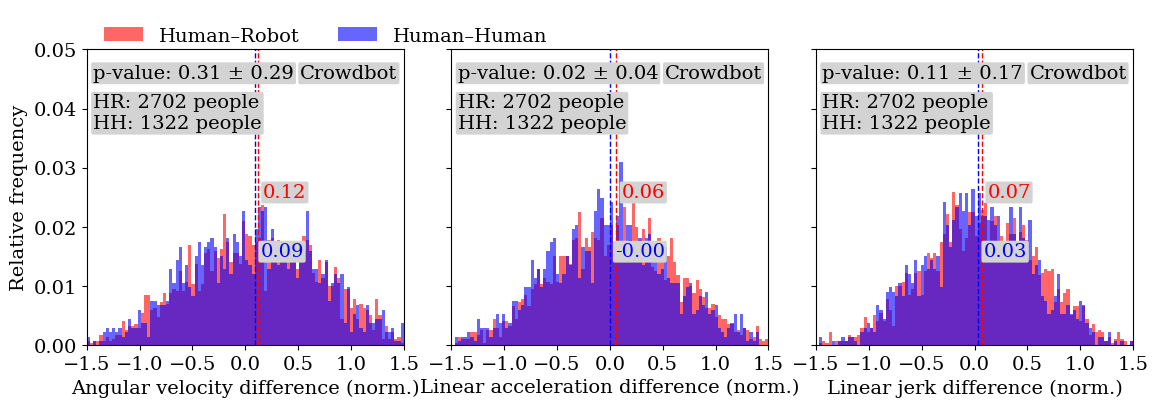

In [34]:
# --- Constants ---
num_bins = 100
fontsize = 14
x_ticks = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
metrics = [
    ("angular_velocity_normalized", (-1.5, 1.5), "Angular velocity"),
    ("acc_normalized", (-1.5, 1.5), "Linear acceleration"),
    ("jerk_normalized", (-1.5, 1.5), "Linear jerk"),
]

density_limit = 0.05  # Crowdbot
dataset_name = "Crowdbot"

# --- Load Crowdbot Data ---
pd_data = CROWDBOT_normalized_differences_df
pp_data = CROWDBOT_normalized_differences_pedestrian_df
pd_filtered = pd_data.copy()
pp_filtered = pp_data.copy()

# --- Create figure ---
fig, axs = plt.subplots(1, 3, figsize=(13.5, 4), sharey=True)

for col, (colname, xlim, label) in enumerate(metrics):
    bins = np.linspace(xlim[0], xlim[1], num_bins + 1)  # Equal bin edges from 0 to 1
    pd_vals = pd_filtered[colname].dropna()
    pp_vals = pp_filtered[colname].dropna()

    pd_mean = pd_vals.mean()
    pp_mean = pp_vals.mean()

    mean_pval, std_pval = bootstrap_mannwhitneyu(pd_vals, pp_vals, n_iterations=100, seed=9331)

    # Histograms
    # axs[col].hist(pd_vals, bins=bins, alpha=0.6, color='red', density=True, label='Human-Robot')
    # axs[col].hist(pp_vals, bins=bins, alpha=0.6, color='blue', density=True, label='Human-Human')
    axs[col].hist(
        pd_vals,
        bins=bins,
        alpha=0.6,
        color='red',
        weights=np.ones_like(pd_vals) / len(pd_vals),   # 1/N weight
        label='Human–Robot'
    )

    axs[col].hist(
        pp_vals,
        bins=bins,
        alpha=0.6,
        color='blue',
        weights=np.ones_like(pp_vals) / len(pp_vals),   # 1/N weight
        label='Human–Human'
    )

    # Mean lines
    axs[col].axvline(pd_mean, color='red', linestyle='--', linewidth=1)
    axs[col].axvline(pp_mean, color='blue', linestyle='--', linewidth=1)

    # Annotate mean values
    axs[col].annotate(f'{pd_mean:.2f}', xy=(pd_mean, density_limit*0.7),
        xytext=(pd_mean + 0.05, density_limit*0.5), fontsize=fontsize, color='red',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    axs[col].annotate(f'{pp_mean:.2f}', xy=(pp_mean, density_limit*0.5),
        xytext=(pp_mean + 0.05, density_limit*0.3), fontsize=fontsize, color='blue',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

    # Text info
    axs[col].text(0.98, 0.95, dataset_name, transform=axs[col].transAxes,
        fontsize=fontsize, ha='right', va='top',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    axs[col].text(0.02, 0.95, f"p-value: {mean_pval:.2f} ± {std_pval:.2f}",
        transform=axs[col].transAxes, fontsize=fontsize, ha='left', va='top',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    axs[col].text(0.02, 0.85, f"HR: {len(pd_vals)} people\nHH: {len(pp_vals)} people",
        transform=axs[col].transAxes, fontsize=fontsize, ha='left', va='top',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

    # Axis formatting
    axs[col].set_xlim(xlim)
    axs[col].set_ylim(0, density_limit)
    axs[col].set_xticks(x_ticks)
    axs[col].tick_params(axis='both', labelsize=fontsize)
    axs[col].set_xlabel(f"{label} difference (norm.)", fontsize=fontsize)
    if col == 0:
        axs[col].set_ylabel("Relative frequency", fontsize=fontsize)

# --- Legend outside, above top-left plot ---
handles, labels = axs[0].get_legend_handles_labels()
bbox = axs[0].get_position()
legend_ax = fig.add_axes([
    bbox.x0, bbox.y1 + 0.02, 0.3, 0.05
])
legend_ax.axis('off')
legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=2)

plt.subplots_adjust(wspace=0.15, top=0.85)
plt.show()

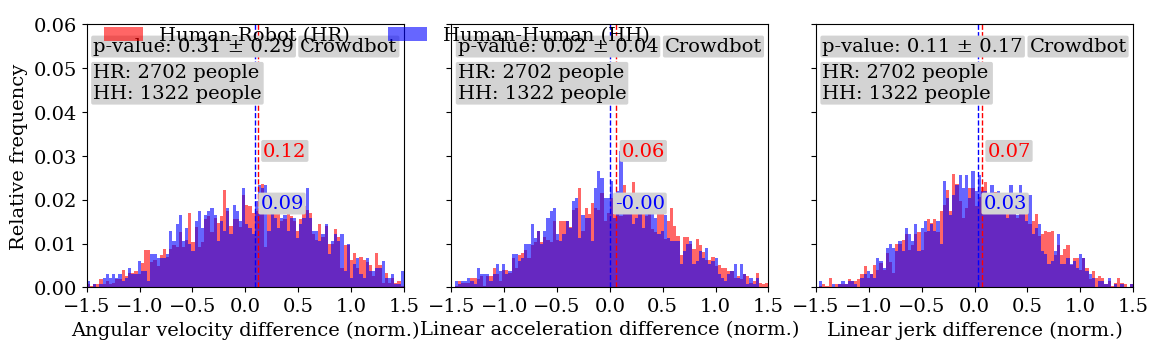

In [35]:
# --- Plotting constants ---
num_bins = 100
angular_velocity_limit = (-1.5, 1.5)
linear_acceleration_limit = (-1.5, 1.5)
linear_jerk_limit = (-1.5, 1.5)
fontsize = 14
x_ticks = [-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
y_ticks_sit = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
y_ticks_other = [0, 0.5, 1.0, 1.5]
density_limits = {"SiT": 0.1, "JRDB": 0.06, "Crowdbot": 0.06}

# Datasets
datasets_pd = {
    # "SiT": SiT_normalized_differences_df,
    # "JRDB": JRDB_normalized_differences_df,
    "Crowdbot": CROWDBOT_normalized_differences_df
}

datasets_pp = {
    # "SiT": SiT_normalized_differences_pedestrian_df,
    # "JRDB": JRDB_normalized_differences_pedestrian_df,
    "Crowdbot": CROWDBOT_normalized_differences_pedestrian_df
}

density_groups = {
    "All Density": (0, float('inf')),
}

# --- Plotting function ---
def plot_combined_histograms(axs, row, dataset_name, pd_data, pp_data, min_density, max_density, density_limits):
    pd_filtered = pd_data[(pd_data['track_crowd_density'] >= min_density) & (pd_data['track_crowd_density'] < max_density)]
    pp_filtered = pp_data[(pp_data['track_crowd_density'] >= min_density) & (pp_data['track_crowd_density'] < max_density)]
    y_ticks = y_ticks_sit if dataset_name == "SiT" else y_ticks_other
    y_max = density_limits[dataset_name]

    metrics = [
        ("angular_velocity_normalized", angular_velocity_limit, "Angular velocity"),
        ("acc_normalized", linear_acceleration_limit, "Linear acceleration"),
        ("jerk_normalized", linear_jerk_limit, "Linear jerk"),
    ]

    for col, (colname, xlim, label) in enumerate(metrics):
        bins = np.linspace(xlim[0], xlim[1], num_bins + 1)  # Equal bin edges from 0 to 1
        pd_vals = pd_filtered[colname].dropna()
        pp_vals = pp_filtered[colname].dropna()
        mean_pval, std_pval = bootstrap_mannwhitneyu(pd_vals, pp_vals, n_iterations=100, seed=9331)

        pd_mean = pd_vals.mean()
        pp_mean = pp_vals.mean()

        # Histograms
        # axs[row, col].hist(pd_vals, bins=bins, alpha=0.6, color='red', density=True, label='Human-Robot (HR)')
        # axs[row, col].hist(pp_vals, bins=bins, alpha=0.6, color='blue', density=True, label='Human-Human (HH)')
        axs[row, col].hist(pd_vals, bins=bins, alpha=0.6, color='red', label='Human-Robot (HR)', weights=np.ones_like(pd_vals) / len(pd_vals),)
        axs[row, col].hist(pp_vals, bins=bins, alpha=0.6, color='blue', label='Human-Human (HH)', weights=np.ones_like(pp_vals) / len(pp_vals),)

        # Mean lines
        axs[row, col].axvline(pd_mean, color='red', linestyle='--', linewidth=1)
        axs[row, col].axvline(pp_mean, color='blue', linestyle='--', linewidth=1)

        # Annotate means
        axs[row, col].annotate(f'{pd_mean:.2f}', xy=(pd_mean, y_max*0.7),
            xytext=(pd_mean + 0.05, y_max*0.5), fontsize=fontsize, color='red',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

        axs[row, col].annotate(f'{pp_mean:.2f}', xy=(pp_mean, y_max*0.5),
            xytext=(pp_mean + 0.05, y_max*0.3), fontsize=fontsize, color='blue',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

        # Axes formatting
        axs[row, col].set_xlim(xlim)
        # print(y_max)
        axs[row, col].set_ylim(0, y_max)
        axs[row, col].set_xticks(x_ticks)
        # axs[row, col].set_yticks(y_ticks)
        axs[row, col].tick_params(axis='both', labelsize=fontsize)

        if row == len(datasets_pd) - 1:
            axs[row, col].set_xlabel(f'{label} difference (norm.)', fontsize=fontsize)
        if col == 0:
            axs[row, col].set_ylabel('Relative frequency', fontsize=fontsize)

        # Dataset name (top-right)
        axs[row, col].text(0.98, 0.95, dataset_name, transform=axs[row, col].transAxes,
            fontsize=fontsize, ha='right', va='top',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

        # P-value (top-left)
        axs[row, col].text(0.02, 0.95, f"p-value: {mean_pval:.2f} ± {std_pval:.2f}",
            transform=axs[row, col].transAxes, fontsize=fontsize, ha='left', va='top',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

        # HR and HH number of points (bottom-left under p-value)
        axs[row, col].text(
            0.02, 0.85, f"HR: {len(pd_vals)} people\nHH: {len(pp_vals)} people",
            transform=axs[row, col].transAxes,
            fontsize=fontsize, ha='left', va='top',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1')
        )

# --- Main Plotting ---
for density_label, (min_density, max_density) in density_groups.items():
    fig, axs = plt.subplots(len(datasets_pd), 3, figsize=(13.5, 3.33 * len(datasets_pd)), sharex='col', sharey='row')
    if(len(axs.shape) == 1):
        axs = axs.reshape((1,3))
    
    # fig.suptitle(f'{density_label} - Normalized Differences (HR vs HH)', fontsize=fontsize)

    for row, dataset_name in enumerate(datasets_pd.keys()):
        plot_combined_histograms(
            axs, row, dataset_name,
            datasets_pd[dataset_name],
            datasets_pp[dataset_name],
            min_density, max_density, 
            density_limits
        )

    # --- Legend above top-left subplot ---
    handles, labels = axs[0, 0].get_legend_handles_labels()
    bbox = axs[0, 0].get_position()
    legend_ax = fig.add_axes([
        bbox.x0,           # align left with subplot
        bbox.y1 + 0.015,   # slightly above top of subplot
        0.3,               # width
        0.05               # height
    ])
    legend_ax.axis('off')
    legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=2)

    plt.subplots_adjust(wspace=0.15, hspace=0.1, top=0.9)
    plt.show()


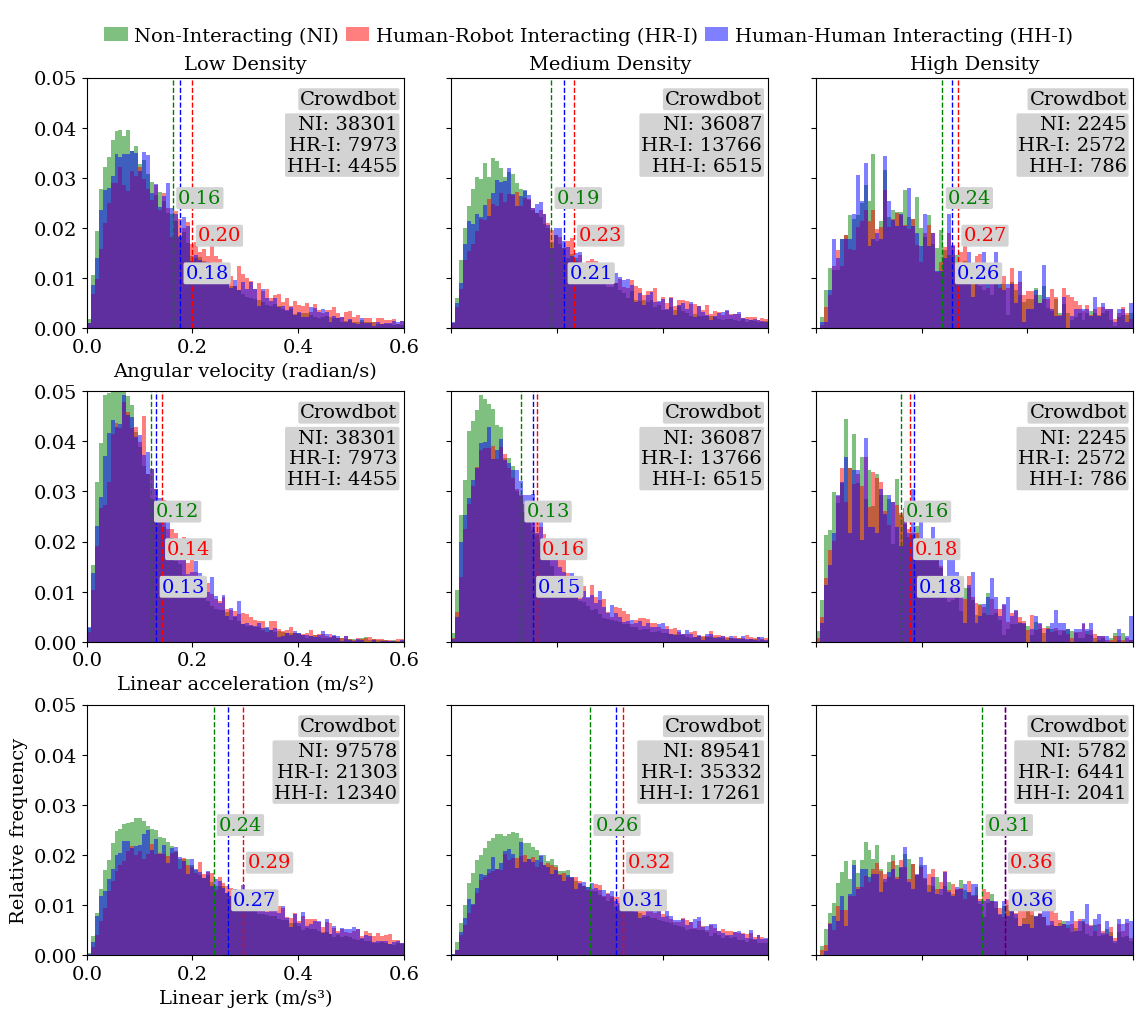

    Dataset  Density            Metric     HRI vs HHI HRI vs Non-Int HHI vs Non-Int
0  Crowdbot        0  angular_velocity  0.000 ± 0.000  0.000 ± 0.000  0.255 ± 0.273
1  Crowdbot        0               acc  0.122 ± 0.192  0.001 ± 0.003  0.081 ± 0.159
2  Crowdbot        0              jerk  0.033 ± 0.078  0.000 ± 0.000  0.134 ± 0.220
3  Crowdbot        1  angular_velocity  0.016 ± 0.034  0.000 ± 0.000  0.083 ± 0.146
4  Crowdbot        1               acc  0.289 ± 0.286  0.000 ± 0.001  0.003 ± 0.018
5  Crowdbot        1              jerk  0.294 ± 0.289  0.000 ± 0.000  0.000 ± 0.000
6  Crowdbot        2  angular_velocity  0.070 ± 0.104  0.000 ± 0.001  0.131 ± 0.189
7  Crowdbot        2               acc  0.163 ± 0.235  0.130 ± 0.232  0.002 ± 0.010
8  Crowdbot        2              jerk  0.410 ± 0.268  0.000 ± 0.001  0.000 ± 0.002


In [57]:
# Colors
color_non_interacting = 'green'
color_pd = 'red'
color_pp = 'blue'

# Results storage
mean_results = []
u_test_results = []

# --- Plotting constants ---
num_bins = 80
metric_limit = (0, 0.6)
fontsize = 14
density_normalized_limit = (0, 0.05)

# Metric configurations
metrics = [
    ("angular_velocity", metric_limit, "Angular velocity (radian/s)"),
    ("acc", metric_limit, "Linear acceleration (m/s²)"),
    ("jerk", metric_limit, "Linear jerk (m/s³)"),
]

# Datasets
datasets_pd = {
    # "SiT": (SiT_all_valid_vel_filtered, SiT_frequency),
    # "JRDB": (JRDB_all_valid_vel_filtered, JRDB_frequency),
    "Crowdbot": (CROWDBOT_all_valid_vel_filtered, CROWDBOT_frequency),
}

datasets_pp = {
    # "SiT": (SiT_all_valid_pedestrian_vel_filtered, SiT_frequency),
    # "JRDB": (JRDB_all_valid_pedestrian_vel_filtered, JRDB_frequency),
    "Crowdbot": (CROWDBOT_all_valid_pedestrian_vel_filtered, CROWDBOT_frequency),
}

density_groups = {
    "Low Density": 0,
    "Medium Density": 1,
    "High Density": 2,
}

# Plotting function
def plot_combined_rolling(axs, row, dataset_name, pd_data, pp_data, freq, density_cluster):
    pd_filtered = pd_data[pd_data['density_cluster'] == density_cluster]
    pp_filtered = pp_data[pp_data['density_cluster'] == density_cluster]

    non_int = pd_filtered[pd_filtered[f'Non-interacting Pedestrians under {non_interacting_distance_limit}m']]
    int_pd = pd_filtered[pd_filtered['Interacting Pedestrians']]
    int_pp = pp_filtered[pp_filtered['Pedestrian-Centered Interacting']]

    for col, (colname, xlim, label) in enumerate(metrics):
        bins = np.linspace(xlim[0], xlim[1], num_bins + 1)  # Equal bin edges from 0 to 1
        # Get values
        time_window_s = rolling_average_thresholds[colname]['time_window_s']
        step_size_s = rolling_average_thresholds[colname]['step_size_s']

        x_nonint = compute_rolling_averages(non_int, colname, frequency=freq, pedestrian_centered=False, time_window_s=time_window_s, step_size_s=step_size_s)
        x_int_pd = compute_rolling_averages(int_pd, colname, frequency=freq, pedestrian_centered=False, time_window_s=time_window_s, step_size_s=step_size_s)
        x_int_pp = compute_rolling_averages(int_pp, colname, frequency=freq, pedestrian_centered=True, time_window_s=time_window_s, step_size_s=step_size_s)

        # Compute means
        mean_nonint = x_nonint.mean() if len(x_nonint) > 0 else np.nan
        mean_pd = x_int_pd.mean() if len(x_int_pd) > 0 else np.nan
        mean_pp = x_int_pp.mean() if len(x_int_pp) > 0 else np.nan

        # Plot vertical mean lines
        if not np.isnan(mean_nonint):
            axs[row, col].axvline(mean_nonint, color=color_non_interacting, linestyle='--', linewidth=1)
        if not np.isnan(mean_pd):
            axs[row, col].axvline(mean_pd, color=color_pd, linestyle='--', linewidth=1)
        if not np.isnan(mean_pp):
            axs[row, col].axvline(mean_pp, color=color_pp, linestyle='--', linewidth=1)

        # Add annotated mean values (offset vertically to avoid overlap)
        mean_annot_y_positions = [0.5, 0.35, 0.2]  # Stagger vertically

        for mean_val, color, y_frac in zip(
            [mean_nonint, mean_pd, mean_pp],
            [color_non_interacting, color_pd, color_pp],
            mean_annot_y_positions
        ):
            if not np.isnan(mean_val):
                axs[row, col].annotate(
                    f'{mean_val:.2f}',
                    xy=(mean_val, density_normalized_limit[1] * y_frac),
                    xytext=(mean_val + 0.01, density_normalized_limit[1] * y_frac),
                    fontsize=fontsize,
                    color=color,
                    bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1')
                )

        # Plot
        # axs[row, col].hist(x_nonint, bins=bins, range=xlim, alpha=0.5, color=color_non_interacting, label="Non-Interacting (NI)", density=True)
        # axs[row, col].hist(x_int_pd, bins=bins, range=xlim, alpha=0.5, color=color_pd, label="Human-Robot Interacting (HR-I)", density=True)
        # axs[row, col].hist(x_int_pp, bins=bins, range=xlim, alpha=0.5, color=color_pp, label="Human-Human Interacting (HH-I)", density=True)
        axs[row, col].hist(x_nonint, bins=bins, range=xlim, alpha=0.5, color=color_non_interacting, label="Non-Interacting (NI)", weights=np.ones_like(x_nonint) / len(x_nonint),)
        axs[row, col].hist(x_int_pd, bins=bins, range=xlim, alpha=0.5, color=color_pd, label="Human-Robot Interacting (HR-I)", weights=np.ones_like(x_int_pd) / len(x_int_pd),)
        axs[row, col].hist(x_int_pp, bins=bins, range=xlim, alpha=0.5, color=color_pp, label="Human-Human Interacting (HH-I)", weights=np.ones_like(x_int_pp) / len(x_int_pp),)

        axs[row, col].set_xlim(xlim)
        axs[row, col].set_ylim(density_normalized_limit)

        # Axis labels
        if row == len(datasets_pd) - 1:
            axs[row, col].set_xlabel(label, fontsize=fontsize)
        if col == 0:
            axs[row, col].set_ylabel("Relative frequency", fontsize=fontsize)

        # Text
        axs[row, col].text(0.98, 0.95, dataset_name, transform=axs[row, col].transAxes,
                           fontsize=fontsize, ha='right', va='top',
                           bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
        # Sample counts (below dataset name)
        axs[row, col].text(
            0.98, 0.85,
            f"NI: {len(x_nonint)}\nHR-I: {len(x_int_pd)}\nHH-I: {len(x_int_pp)}",
            transform=axs[row, col].transAxes,
            fontsize=fontsize, ha='right', va='top',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1')
        )

        x_nonint_ds = downsample(x_nonint, max_samples=1000)
        x_int_pd_ds = downsample(x_int_pd, max_samples=1000)
        x_int_pp_ds = downsample(x_int_pp, max_samples=1000)

        # Statistical tests with downsampled values
        # Safe U-test computation
        def safe_mwu(arr1, arr2):
            if len(arr1) > 0 and len(arr2) > 0:
                mean_p, std_p = bootstrap_mannwhitneyu(arr1, arr2, n_iterations=100)
                return f"{mean_p:.3f} ± {std_p:.3f}"
            else:
                return "N/A"

        # Run statistical tests safely
        pd_vs_pp = safe_mwu(x_int_pd_ds, x_int_pp_ds)
        pd_vs_nonint = safe_mwu(x_int_pd_ds, x_nonint_ds)
        pp_vs_nonint = safe_mwu(x_int_pp_ds, x_nonint_ds)

        u_test_results.append({
            "Dataset": dataset_name,
            "Density": density_cluster,
            "Metric": colname,
            "HRI vs HHI": pd_vs_pp,
            "HRI vs Non-Int": pd_vs_nonint,
            "HHI vs Non-Int": pp_vs_nonint,
        })

# --- Helper: statistical test (kept simple) ---
def _safe_mwu(arr1, arr2):
    if len(arr1) > 0 and len(arr2) > 0:
        mean_p, std_p = bootstrap_mannwhitneyu(arr1, arr2, n_iterations=100)
        return f"{mean_p:.3f} ± {std_p:.3f}"
    return "N/A"

# --- New plotting function (different name) ---
def plot_by_dataset_across_densities(axs, col, dataset_name, pd_data, pp_data, freq, density_cluster):
    pd_filtered = pd_data[pd_data['density_cluster'] == density_cluster]
    pp_filtered = pp_data[pp_data['density_cluster'] == density_cluster]

    non_int = pd_filtered[pd_filtered[f'Non-interacting Pedestrians under {non_interacting_distance_limit}m']]
    int_pd  = pd_filtered[pd_filtered['Interacting Pedestrians']]
    int_pp  = pp_filtered[pp_filtered['Pedestrian-Centered Interacting']]

    for row, (colname, xlim, label) in enumerate(metrics):
        bins = np.linspace(xlim[0], xlim[1], num_bins + 1)
        time_window_s = rolling_average_thresholds[colname]['time_window_s']
        step_size_s   = rolling_average_thresholds[colname]['step_size_s']

        # Rolling averages
        x_nonint = compute_rolling_averages(non_int, colname, frequency=freq, pedestrian_centered=False,
                                            time_window_s=time_window_s, step_size_s=step_size_s)
        x_int_pd = compute_rolling_averages(int_pd, colname, frequency=freq, pedestrian_centered=False,
                                            time_window_s=time_window_s, step_size_s=step_size_s)
        x_int_pp = compute_rolling_averages(int_pp, colname, frequency=freq, pedestrian_centered=True,
                                            time_window_s=time_window_s, step_size_s=step_size_s)

        # Means
        mean_nonint = x_nonint.mean() if len(x_nonint) > 0 else np.nan
        mean_pd     = x_int_pd.mean() if len(x_int_pd) > 0 else np.nan
        mean_pp     = x_int_pp.mean() if len(x_int_pp) > 0 else np.nan

        # Histograms (labels only on top-left so legend is simple)
        if len(x_nonint) > 0:
            axs[row, col].hist(x_nonint, bins=bins, range=xlim, alpha=0.5, color=color_non_interacting,
                               weights=np.ones_like(x_nonint) / len(x_nonint),
                               label="Non-Interacting (NI)" if (row == 0 and col == 0) else None)
        if len(x_int_pd) > 0:
            axs[row, col].hist(x_int_pd, bins=bins, range=xlim, alpha=0.5, color=color_pd,
                               weights=np.ones_like(x_int_pd) / len(x_int_pd),
                               label="Human-Robot Interacting (HR-I)" if (row == 0 and col == 0) else None)
        if len(x_int_pp) > 0:
            axs[row, col].hist(x_int_pp, bins=bins, range=xlim, alpha=0.5, color=color_pp,
                               weights=np.ones_like(x_int_pp) / len(x_int_pp),
                               label="Human-Human Interacting (HH-I)" if (row == 0 and col == 0) else None)

        # Mean lines + annotations
        for m, c, y_frac in zip([mean_nonint, mean_pd, mean_pp],
                                [color_non_interacting, color_pd, color_pp],
                                [0.5, 0.35, 0.2]):
            if not np.isnan(m):
                axs[row, col].axvline(m, color=c, linestyle='--', linewidth=1)
                axs[row, col].annotate(
                    f'{m:.2f}',
                    xy=(m, density_normalized_limit[1] * y_frac),
                    xytext=(m + 0.01, density_normalized_limit[1] * y_frac),
                    fontsize=fontsize, color=c,
                    bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1')
                )

        # Limits
        axs[row, col].set_xlim(xlim)
        axs[row, col].set_ylim(density_normalized_limit)

        # Axis labels (as requested):
        # - X label only on the first-from-left plot of each row (col == 0)
        if col == 0:
            axs[row, col].set_xlabel(label, fontsize=fontsize)
        # - Y label only on the bottom-left plot
        if row == (len(metrics) - 1) and col == 0:
            axs[row, col].set_ylabel("Relative frequency", fontsize=fontsize)

        # Dataset & counts
        axs[row, col].text(0.98, 0.95, f"{dataset_name}", transform=axs[row, col].transAxes,
                           fontsize=fontsize, ha='right', va='top',
                           bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
        axs[row, col].text(0.98, 0.85,
                           f"NI: {len(x_nonint)}\nHR-I: {len(x_int_pd)}\nHH-I: {len(x_int_pp)}",
                           transform=axs[row, col].transAxes,
                           fontsize=fontsize, ha='right', va='top',
                           bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

        # Stats (downsampled)
        x_nonint_ds = downsample(x_nonint, max_samples=1000)
        x_int_pd_ds = downsample(x_int_pd, max_samples=1000)
        x_int_pp_ds = downsample(x_int_pp, max_samples=1000)

        u_test_results.append({
            "Dataset": dataset_name,
            "Density": density_cluster,
            "Metric": colname,
            "HRI vs HHI": _safe_mwu(x_int_pd_ds, x_int_pp_ds),
            "HRI vs Non-Int": _safe_mwu(x_int_pd_ds, x_nonint_ds),
            "HHI vs Non-Int": _safe_mwu(x_int_pp_ds, x_nonint_ds),
        })


# --- Plot: one figure per dataset; rows=metrics, cols=densities ---
try:
    u_test_results.clear()
except NameError:
    u_test_results = []

for dataset_name in datasets_pd.keys():
    pd_data, freq = datasets_pd[dataset_name]
    pp_data, _    = datasets_pp[dataset_name]

    fig, axs = plt.subplots(
        len(metrics), 3,
        figsize=(13.5, 3.8 * len(metrics)),  # a touch taller per row
        sharex='row',                        # share x within each metric row
        sharey='all'                         # share y across the entire grid
    )
    if len(metrics) == 1:  # ensure 2D indexing for single-row case
        axs = axs.reshape((1, 3))

    # Show x-tick labels only on the first (left) plot in each row
    for r in range(axs.shape[0]):          # each metric row
        axs[r, 0].tick_params(axis='x', labelbottom=True)   # left column: show labels
        for c in range(1, axs.shape[1]):                    # other columns: hide labels
            axs[r, c].tick_params(axis='x', labelbottom=False)

    # fig.suptitle(f'{dataset_name} – Angular velocity, Linear acceleration, and Linear jerk (HR-I + HH-I)', fontsize=fontsize)

    # Exact titles as requested
    axs[0, 0].set_title('Low Density', fontsize=fontsize)
    axs[0, 1].set_title('Medium Density', fontsize=fontsize)
    axs[0, 2].set_title('High Density', fontsize=fontsize)

    # Always Low -> Medium -> High
    for col, density_name in enumerate(['Low Density', 'Medium Density', 'High Density']):
        density_int = density_groups[density_name]
        plot_by_dataset_across_densities(axs, col, dataset_name, pd_data, pp_data, freq, density_int)

    # Legend from top-left (single set of labels)
    handles, labels = axs[0, 0].get_legend_handles_labels()
    bbox = axs[0, 0].get_position()
    legend_ax = fig.add_axes([bbox.x0, bbox.y1 + 0.010, 0.3, 0.05])
    legend_ax.axis('off')
    legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False,
                     ncol=3, handlelength=1.2, handletextpad=0.35, columnspacing=0.35)

    for ax in axs.flat:
        ax.tick_params(axis='both', labelsize=fontsize)

    # More vertical space between rows so x-labels are visible
    plt.subplots_adjust(wspace=0.15, hspace=0.25)
    plt.show()

# Summary U-test results
u_test_df = pd.DataFrame(u_test_results)
with pd.option_context('display.max_columns', None, 'display.width', 3000):
    print(u_test_df)


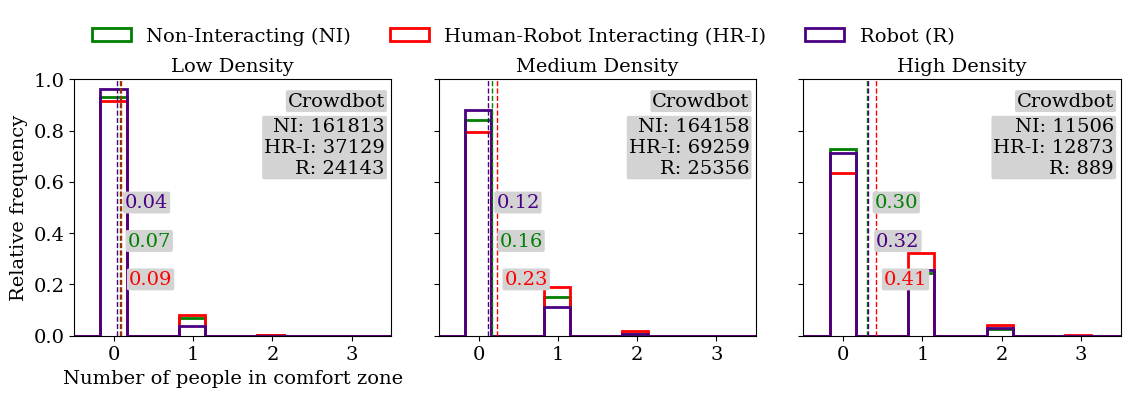

In [42]:
# --- Plotting constants ---
fontsize = 14
count_limit = 3
y_max_limit = 1

# Datasets dictionary
datasets = {
    # "SiT": (SiT_device_metrics_valid_vel_df, SiT_all_valid_vel_filtered),
    # "JRDB": (JRDB_device_metrics_valid_vel_df, JRDB_all_valid_vel_filtered),
    "Crowdbot": (CROWDBOT_device_metrics_valid_vel_df, CROWDBOT_all_valid_vel_filtered)
}

density_groups = {
    f"Low Density": (0,),
    f"Medium Density": (1,),
    f"High Density": (2,)
}

compared_group = f'Non-interacting Pedestrians under {non_interacting_distance_limit}m'
compared_group2 = 'Interacting Pedestrians'

# --- Plotting function ---
def plot_people_count_comparison(ax, dataset_name, dmvvel_df, avvel_filtered, density_int):
    # Compute counts from density by multiplying with comfort area
    device_counts = (dmvvel_df[dmvvel_df['density_cluster'] == density_int]['device_density_passes_var_vel_comfort_ppsm'] * comfort_area_device_band).round()
    ped_counts_nonint = (avvel_filtered[(avvel_filtered[compared_group]) & 
                                        (avvel_filtered['density_cluster'] == density_int)]['crowd_density_group_comfort_ppsm'] * comfort_area_pedestrian_band).round()
    ped_counts_int = (avvel_filtered[(avvel_filtered[compared_group2]) & 
                                     (avvel_filtered['density_cluster'] == density_int)]['crowd_density_group_comfort_ppsm'] * comfort_area_pedestrian_band).round()

    # Compute means
    mean_device = device_counts.mean()
    mean_nonint = ped_counts_nonint.mean()
    mean_int = ped_counts_int.mean()

    # Clip to 0–3 range for consistent visualization
    device_counts_plot = device_counts[device_counts <= count_limit]
    ped_counts_nonint_plot = ped_counts_nonint[ped_counts_nonint <= count_limit]
    ped_counts_int_plot = ped_counts_int[ped_counts_int <= count_limit]

    # Binning centered over 0–3, padded on both sides
    bins = np.arange(-0.5, count_limit + 1.5, 0.33)

    # Plot histograms
    # ax.hist(ped_counts_nonint_plot, bins=bins, alpha=1, label='Non-Interacting (NI)', color='g', density=True, histtype='step', linewidth=2.)
    # ax.hist(ped_counts_int_plot, bins=bins, alpha=1, label='Human-Robot Interacting (HR-I)', color='r', density=True, histtype='step', linewidth=2.)
    # ax.hist(device_counts_plot, bins=bins, alpha=1, label='Robot (R)', color='indigo', density=True, histtype='step', linewidth=2.)

    ax.hist(ped_counts_nonint_plot, bins=bins, alpha=1, label='Non-Interacting (NI)', color='g', histtype='step', linewidth=2., weights=np.ones_like(ped_counts_nonint_plot) / len(ped_counts_nonint_plot),)
    ax.hist(ped_counts_int_plot, bins=bins, alpha=1, label='Human-Robot Interacting (HR-I)', color='r', histtype='step', linewidth=2., weights=np.ones_like(ped_counts_int_plot) / len(ped_counts_int_plot),)
    ax.hist(device_counts_plot, bins=bins, alpha=1, label='Robot (R)', color='indigo', histtype='step', linewidth=2., weights=np.ones_like(device_counts_plot) / len(device_counts_plot),)

    # Mean lines
    ax.axvline(mean_nonint, color='g', linestyle='dashed', linewidth=1)
    ax.axvline(mean_int, color='r', linestyle='dashed', linewidth=1)
    ax.axvline(mean_device, color='indigo', linestyle='dashed', linewidth=1)

    # Annotations
    heights = [0.5, 0.35, 0.2]  # Stagger vertically
    for (mean, color), height in zip(sorted([(mean_nonint, 'g'), (mean_int, 'r'), (mean_device, 'indigo')]), heights):
        ax.annotate(f'{mean:.2f}', xy=(mean, y_max_limit * height), xytext=(mean + 0.1, y_max_limit * height),
                    fontsize=fontsize, color=color,
                    bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

    # Dataset label
    ax.text(0.98, 0.95, dataset_name, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

    # total_points = len(device_counts) + len(ped_counts_nonint) + len(ped_counts_int)
    # ax.text(0.98, 0.60, f"{total_points} pts", transform=ax.transAxes,
    #         fontsize=fontsize, ha='right', va='top', color='black')
    # Sample counts (below dataset name)
    ax.text(
        0.98, 0.85,
        f"NI: {len(ped_counts_nonint)}\nHR-I: {len(ped_counts_int)}\nR: {len(device_counts)}",
        transform=ax.transAxes,
        fontsize=fontsize, ha='right', va='top',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1')
    )

    ax.set_ylim((0, y_max_limit))
    ax.set_xlim((-0.5, count_limit + 0.5))
    ax.set_xticks([0, 1, 2, 3])

# --- Plotting setup ---
fig, axs = plt.subplots(len(datasets), len(density_groups), figsize=(4.5 * len(density_groups), 3.33 * len(datasets)), sharex=True, sharey='row')
if(len(axs.shape) == 1):
        axs = axs.reshape((1,3))

for col, density_int in enumerate(density_groups.values()):
    for row, (dataset_name, (dmvvel_df, avvel_filtered)) in enumerate(datasets.items()):
        plot_people_count_comparison(axs[row, col], dataset_name, dmvvel_df[dmvvel_df['minimum_distance_interact'].fillna(False)], avvel_filtered[avvel_filtered['minimum_distance_interact'].fillna(False)], density_int)

# Titles
axs[0, 0].set_title('Low Density', fontsize=fontsize)
axs[0, 1].set_title('Medium Density', fontsize=fontsize)
axs[0, 2].set_title('High Density', fontsize=fontsize)

# Axis labels
axs[-1, 0].set_xlabel('Number of people in comfort zone', fontsize=fontsize)
axs[-1, 0].set_ylabel('Relative frequency', fontsize=fontsize)

# Legend
# axs[0, 0].legend(loc='upper right', fontsize=fontsize)
# Legend above upper-left plot
handles, labels = axs[0, 0].get_legend_handles_labels()
bbox = axs[0, 0].get_position()
legend_ax = fig.add_axes([
    bbox.x0,           # align left with subplot
    bbox.y1 + 0.160,   # slightly above top of subplot
    0.3,               # width
    0.05               # height
])
legend_ax.axis('off')
# legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3, handlelength=1.5, handletextpad=0.4, columnspacing=0.6)
legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3,)

# Style
for ax_row in axs:
    for ax in ax_row:
        ax.tick_params(axis='both', labelsize=fontsize)

# plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.1)
plt.show()


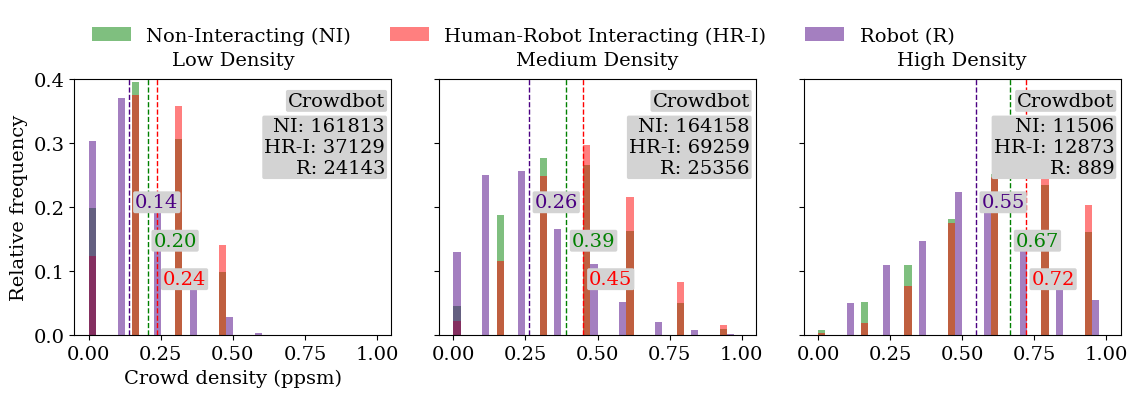

In [45]:
# Plotting constants
num_bins = 40
fontsize = 14

# Datasets dictionary
datasets = {
    # "SiT": (SiT_device_metrics_valid_vel_df, SiT_all_valid_vel_filtered),
    # "JRDB": (JRDB_device_metrics_valid_vel_df, JRDB_all_valid_vel_filtered),
    "Crowdbot": (CROWDBOT_device_metrics_valid_vel_df, CROWDBOT_all_valid_vel_filtered)
}

density_groups = {
    f"Low Density": (0,),
    f"Medium Density": (1,),
    f"High Density": (2,)
}

# Maximum density limits for each dataset
density_limit = 0.4

# Comparison groups
compared_group = f'Non-interacting Pedestrians under {non_interacting_distance_limit}m'
compared_group2 = 'Interacting Pedestrians'

# Calculate global bin edges
all_densities = []

# Collect densities for global bin range
for device_metrics, all_valid_vel in datasets.values():
    all_densities.extend(device_metrics['device_density_social_ppsm'])
    all_densities.extend(all_valid_vel[all_valid_vel[compared_group] == True]['crowd_density_social_ppsm'])
    all_densities.extend(all_valid_vel[all_valid_vel[compared_group2] == True]['crowd_density_social_ppsm'])

# Limit densities to 1 for bin calculation
all_densities = [d for d in all_densities if d <= 1]
bins = np.linspace(0, 1, num_bins + 1)  # Equal bin edges from 0 to 1

# Shared plotting function
def plot_density_comparison_social(ax, dataset_name, dmvvel_df, avvel_filtered, density_int):
    # Calculate means
    mean_device_density = dmvvel_df[dmvvel_df['density_cluster'] == density_int]['device_density_social_ppsm'].mean()
    mean_compared_density = avvel_filtered[(avvel_filtered[compared_group] == True) & (avvel_filtered['density_cluster'] == density_int)]['crowd_density_social_ppsm'].mean()
    mean_compared2_density = avvel_filtered[(avvel_filtered[compared_group2] == True) & (avvel_filtered['density_cluster'] == density_int)]['crowd_density_social_ppsm'].mean()

    # Filter values
    filtered_device_density = dmvvel_df[dmvvel_df['density_cluster'] == density_int]['device_density_social_ppsm']
    filtered_device_density_thresh = filtered_device_density[filtered_device_density <= 1]
    filtered_compared_density = avvel_filtered[(avvel_filtered[compared_group] == True) & (avvel_filtered['density_cluster'] == density_int)]['crowd_density_social_ppsm']
    filtered_compared_density_thresh = filtered_compared_density[filtered_compared_density <= 1]
    filtered_compared2_density = avvel_filtered[(avvel_filtered[compared_group2] == True) & (avvel_filtered['density_cluster'] == density_int)]['crowd_density_social_ppsm']
    filtered_compared2_density_thresh = filtered_compared2_density[filtered_compared2_density <= 1]

    # Plot histograms with global bins
    # ax.hist(filtered_compared_density_thresh, bins=bins, alpha=0.5, label='Non-Interacting (NI)', color='g', density=True,)
    # ax.hist(filtered_compared2_density_thresh, bins=bins, alpha=0.5, label='Human-Robot Interacting (HR-I)', color='r', density=True,)
    # ax.hist(filtered_device_density_thresh, bins=bins, alpha=0.5, label='Robot (R)', color='indigo', density=True,)

    ax.hist(filtered_compared_density_thresh, bins=bins, alpha=0.5, label='Non-Interacting (NI)', color='g', weights=np.ones_like(filtered_compared_density_thresh) / len(filtered_compared_density_thresh),)
    ax.hist(filtered_compared2_density_thresh, bins=bins, alpha=0.5, label='Human-Robot Interacting (HR-I)', color='r', weights=np.ones_like(filtered_compared2_density_thresh) / len(filtered_compared2_density_thresh),)
    ax.hist(filtered_device_density_thresh, bins=bins, alpha=0.5, label='Robot (R)', color='indigo', weights=np.ones_like(filtered_device_density_thresh) / len(filtered_device_density_thresh),)

    ax.set_ylim((0, density_limit))

    # Add vertical dashed lines for the means
    ax.axvline(mean_compared_density, color='g', linestyle='dashed', linewidth=1)
    ax.axvline(mean_compared2_density, color='r', linestyle='dashed', linewidth=1)
    ax.axvline(mean_device_density, color='indigo', linestyle='dashed', linewidth=1)

    # num_points = len(filtered_device_density) + len(filtered_compared_density) + len(filtered_compared2_density) 
    # ax.text(0.98, 0.60, f"{num_points} pts", transform=ax.transAxes,
    #                  fontsize=fontsize, color='black', va='top', ha='right', bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    ax.text(
        0.98, 0.85,
        f"NI: {len(filtered_compared_density)}\nHR-I: {len(filtered_compared2_density)}\nR: {len(filtered_device_density)}",
        transform=ax.transAxes,
        fontsize=fontsize, ha='right', va='top',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1')
    )

    # Determine y-axis maximum for annotation positioning
    y_max = ax.get_ylim()[1]
    mean_values = sorted([
        (mean_compared_density, 'g'),
        (mean_compared2_density, 'r'),
        (mean_device_density, 'indigo'),
    ])
    # Smallest at 2/3 height, second at 1/2 height, largest at 1/3 height
    heights = [y_max * 0.5, y_max * 0.35, y_max* 0.2]
    for (mean, color), height in zip(mean_values, heights):
        ax.annotate(f'{mean:.2f}', xy=(mean, height), 
                    xytext=(mean + 0.02, height), fontsize=fontsize, color=color,
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'), # Add a white background
        zorder=10  # Bring the annotation to the foreground
        )

    # Add dataset name inside the subplot (left top corner)
    ax.text(0.98, 0.95, dataset_name, transform=ax.transAxes, fontsize=fontsize, 
            verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

# Create the figure and axes
fig, axs = plt.subplots(len(datasets.keys()), len(density_groups), figsize=(4.5*len(density_groups), 3.33*len(datasets.keys())), sharex=True, sharey='row')
if(len(axs.shape) == 1):
        axs = axs.reshape((1,3))

for column, density_int in enumerate(density_groups.values()):
    for row, (dataset_name, (dmvvel_df, avvel_filtered)) in enumerate(datasets.items()):
        plot_density_comparison_social(axs[row, column], dataset_name, dmvvel_df[dmvvel_df['minimum_distance_interact'].fillna(False)], avvel_filtered[avvel_filtered['minimum_distance_interact'].fillna(False)], density_int)

axs[0, 0].set_title('Low Density', fontsize=fontsize, pad=10)
axs[0, 1].set_title('Medium Density', fontsize=fontsize, pad=10)
axs[0, 2].set_title('High Density', fontsize=fontsize, pad=10)

axs[0, 0].set_title('Low Density', fontsize=fontsize, pad=10)
axs[0, 1].set_title('Medium Density', fontsize=fontsize, pad=10)
axs[0, 2].set_title('High Density', fontsize=fontsize, pad=10)

# Shared x-axis label
axs[-1, 0].set_xlabel('Crowd density (ppsm)', fontsize=fontsize)
axs[-1, 0].set_ylabel('Relative frequency', fontsize=fontsize)

# Legend only for the top subplot
# axs[0, 0].legend(loc='upper right', fontsize=fontsize)
handles, labels = axs[0, 0].get_legend_handles_labels()
bbox = axs[0, 0].get_position()
legend_ax = fig.add_axes([
    bbox.x0,           # align left with subplot
    bbox.y1 + 0.160,   # slightly above top of subplot
    0.3,               # width
    0.05               # height
])
legend_ax.axis('off')
# legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3, handlelength=1.5, handletextpad=0.4, columnspacing=0.6)
legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3,)

# Adjust ticks font size for all subplots
for ax_col in axs:
    for ax in ax_col:
        ax.tick_params(axis='both', labelsize=fontsize)

# Adjust layout
# plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.1)
plt.show()


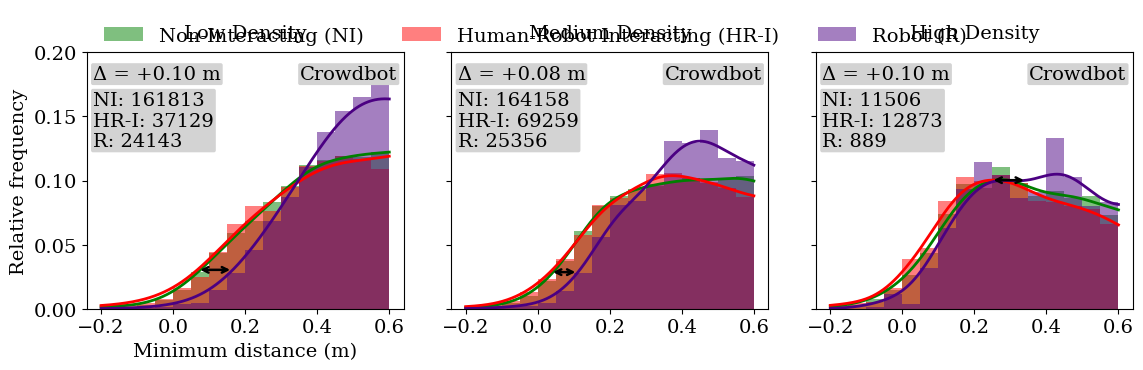

In [47]:
# Plotting constants
plotting_min_threshold = -0.2
plotting_threshold = .6 # Cutoff distance for plotting
num_bins = int(20*(plotting_threshold+ abs(plotting_min_threshold)))
fontsize = 14

# ---- shared bins (for the hist overlays only) ----
bins = np.linspace(plotting_min_threshold, plotting_threshold, num_bins + 1)
x_grid = np.linspace(bins[0], bins[-1], 1000)  # grid for KDE curves
bin_width = np.diff(bins)[0]

# Datasets dictionary
datasets = {
    # "SiT": (SiT_device_metrics_valid_vel_df, SiT_all_valid_vel_filtered),
    # "JRDB": (JRDB_device_metrics_valid_vel_df, JRDB_all_valid_vel_filtered),
    "Crowdbot": (CROWDBOT_device_metrics_valid_vel_df, CROWDBOT_all_valid_vel_filtered)
}

density_groups = {
    f"Low Density": 0,
    f"Medium Density": 1,
    f"High Density": 2
}

dataset_bw_scale = {
        'Crowdbot': 1.,
        'JRDB': 0.5,
        'SiT': 0.5,
    }

density_limit = 0.20
frac = 0.5

# Comparison groups
compared_group = f'Non-interacting Pedestrians under {non_interacting_distance_limit}m'
compared_group2 = 'Interacting Pedestrians'

# --- NEW knobs for the gap finder / segment selection ---
gap_threshold_m = 0.03 # minimum horizontal gap (meters) 
min_rel_freq_start = 0.025 # start scanning rel. frequency from here 
scan_levels = 600 # resolution of y scanning

kde_dict = {}

def find_gap_segment_robot_vs_pedestrians(
    dens_robot_scaled, dens_ni_scaled, dens_hri_scaled,
    xg, y_max_scan, y_start, thr_x, n_levels=400
):
    """
    Computes iso-density left-branch crossings for Robot and the furthest of {NI,HRI}.
    Finds the first contiguous segment (from y_start) where |Δ| >= thr_x,
    centers the arrow at the rounded max gap inside that segment, and then
    EXTENDS that segment outward in y until the first sign change of Δ (both directions).
    Returns:
        y_line, x_lo_line, x_hi_line, delta_signed_at_line,
        y_seg_ext, xR_seg_ext, xO_seg_ext, gap_seg_signed_ext
    """
    max_supported = np.nanmax([
        np.nanmax(dens_robot_scaled) if dens_robot_scaled is not None else 0.0,
        np.nanmax(dens_ni_scaled)    if dens_ni_scaled    is not None else 0.0,
        np.nanmax(dens_hri_scaled)   if dens_hri_scaled   is not None else 0.0,
    ])
    y_cap = float(min(y_max_scan, max_supported))
    if not np.isfinite(y_cap) or y_cap <= 0 or y_start >= y_cap:
        return (None, None, None, None, np.array([]), np.array([]), np.array([]), np.array([]))

    y_start = max(1e-9, float(y_start))
    y_levels = np.linspace(y_start, y_cap, n_levels)

    gaps = np.full(n_levels, np.nan); sgn = np.full(n_levels, np.nan)
    x_lo = np.full(n_levels, np.nan); x_hi = np.full(n_levels, np.nan)
    xR  = np.full(n_levels, np.nan);  xO  = np.full(n_levels, np.nan)

    def _left_x(dens_scaled, y):
        if dens_scaled is None or dens_scaled.size == 0 or not np.isfinite(y): return np.nan
        if np.nanmax(dens_scaled) < y: return np.nan
        j = int(np.argmax(dens_scaled >= y))
        return float(xg[j]) if dens_scaled[j] >= y else np.nan

    for j, y in enumerate(y_levels):
        xr = _left_x(dens_robot_scaled, y)
        xi = _left_x(dens_ni_scaled,    y)
        xh = _left_x(dens_hri_scaled,   y)
        if not np.isfinite(xr) or (not np.isfinite(xi) and not np.isfinite(xh)):
            continue
        cand = []; xoth = []; signs = []
        if np.isfinite(xi): cand.append(abs(xr - xi)); xoth.append(xi); signs.append(np.sign(xr - xi))
        if np.isfinite(xh): cand.append(abs(xr - xh)); xoth.append(xh); signs.append(np.sign(xr - xh))
        if not cand: continue
        k = int(np.nanargmax(cand))
        gaps[j] = float(cand[k]); xR[j] = xr; xO[j] = float(xoth[k]); sgn[j] = float(signs[k])
        x_lo[j] = min(xr, xoth[k]); x_hi[j] = max(xr, xoth[k])

    valid = np.isfinite(gaps)
    if not np.any(valid):
        return (None, None, None, None, np.array([]), np.array([]), np.array([]), np.array([]))

    first_valid = int(np.argmax(valid))

    use_full = False
    if gaps[first_valid] >= thr_x:
        seg_start = first_valid
    else:
        above = valid & (gaps >= thr_x)
        if not np.any(above): use_full = True
        else: seg_start = int(np.argmax(above))

    if use_full:
        idx_seg = np.where(valid)[0]
        if idx_seg.size == 0:
            return (None, None, None, None, np.array([]), np.array([]), np.array([]), np.array([]))
        j_star = int(idx_seg[np.nanargmax(gaps[idx_seg])])
        y_seg_ext   = y_levels[idx_seg]
        xR_seg_ext  = xR[idx_seg]
        xO_seg_ext  = xO[idx_seg]
        gap_seg_ext = np.sign(xR_seg_ext - xO_seg_ext) * np.abs(xR_seg_ext - xO_seg_ext)
        return (float(y_levels[j_star]), float(x_lo[j_star]), float(x_hi[j_star]),
                float(np.sign(xR[j_star]-xO[j_star]) * gaps[j_star]),
                y_seg_ext, xR_seg_ext, xO_seg_ext, gap_seg_ext)

    j = seg_start; n = len(y_levels)
    while j < n and (np.isfinite(gaps[j]) and gaps[j] >= thr_x): j += 1
    seg_end = j - 1

    seg_idx = np.arange(seg_start, seg_end + 1, dtype=int)
    j_star  = seg_idx[int(np.nanargmax(gaps[seg_idx]))]
    gap_star_round = np.round(gaps[j_star], 2)
    eq_mask = (np.round(gaps[seg_idx], 2) == gap_star_round)
    eq_idx  = seg_idx[eq_mask]
    if eq_idx.size == 0: eq_idx = np.array([j_star], dtype=int)

    splits = np.where(np.diff(eq_idx) > 1)[0]
    starts = np.r_[0, splits + 1]; ends = np.r_[splits, len(eq_idx) - 1]
    block = None
    for s, e in zip(starts, ends):
        blk = eq_idx[s:e+1]
        if (blk[0] <= j_star) and (j_star <= blk[-1]): block = blk; break
    j_mid = int(block[len(block)//2]) if block is not None else j_star

    # EXTEND to first sign change both directions
    s_ref = np.sign(xR[j_mid] - xO[j_mid])
    if s_ref == 0 or not np.isfinite(s_ref):
        s_ref = np.sign(xR[seg_start] - xO[seg_start]) if np.isfinite(xR[seg_start]) and np.isfinite(xO[seg_start]) else 1.0

    left = j_mid
    while left-1 >= 0 and valid[left-1] and np.isfinite(sgn[left-1]) and sgn[left-1] == s_ref:
        left -= 1
    right = j_mid
    while right+1 < n and valid[right+1] and np.isfinite(sgn[right+1]) and sgn[right+1] == s_ref:
        right += 1

    ext_idx = np.arange(left, right+1, dtype=int)

    y_seg_ext   = y_levels[ext_idx]
    xR_seg_ext  = xR[ext_idx]
    xO_seg_ext  = xO[ext_idx]
    gap_seg_ext = sgn[ext_idx] * gaps[ext_idx]

    return (float(y_levels[j_mid]), float(x_lo[j_mid]), float(x_hi[j_mid]),
            float(sgn[j_mid] * gaps[j_mid]),
            y_seg_ext, xR_seg_ext, xO_seg_ext, gap_seg_ext)

# Cache to reuse in later cells
results_cache = {}

# -------- Figure 1 (KDEs + max-gap) and cache fill --------
n_rows = len(datasets)
n_cols = len(density_groups)

fig1, axs1 = plt.subplots(n_rows, n_cols,
                          figsize=(4.5*n_cols, 3.33*n_rows),
                          sharex=True, sharey='row')
if len(np.shape(axs1)) == 1:
    axs1 = axs1.reshape((1, n_cols))

for col, density_int in enumerate(density_groups.values()):
    for row, (dataset_name, (dmvvel_df, avvel_filtered)) in enumerate(datasets.items()):
        ax = axs1[row, col]

        # Filter like before
        dmv = dmvvel_df[dmvvel_df['minimum_distance_interact'].fillna(False)]
        avv = avvel_filtered[avvel_filtered['minimum_distance_interact'].fillna(False)]

        # Data by group
        ped_ni  = avv[(avv[compared_group]  == True) & (avv['density_cluster'] == density_int)]['minimum_distance']
        ped_hri = avv[(avv[compared_group2] == True) & (avv['density_cluster'] == density_int)]['minimum_distance']
        rob     = dmv[dmv['density_cluster'] == density_int]['minimum_distance']

        n1, n2, nd = len(ped_ni), len(ped_hri), len(rob)

        # Hists (relative frequency)
        if n1 > 0:
            ped1_th = ped_ni[ped_ni <= plotting_threshold]
            ax.hist(ped1_th, bins=bins, alpha=0.5, label='Non-Interacting (NI)', color='g',
                    weights=np.ones_like(ped1_th) / len(ped1_th))
        if n2 > 0:
            ped2_th = ped_hri[ped_hri <= plotting_threshold]
            ax.hist(ped2_th, bins=bins, alpha=0.5, label='Human-Robot Interacting (HR-I)', color='r',
                    weights=np.ones_like(ped2_th) / len(ped2_th))
        if nd > 0:
            dev_th = rob[rob <= plotting_threshold]
            ax.hist(dev_th,  bins=bins, alpha=0.5, label='Robot (R)', color='indigo',
                    weights=np.ones_like(dev_th)  / len(dev_th))

        # KDEs
        bw_scale = dataset_bw_scale.get(dataset_name, 1.0)
        dens1_scaled = dens2_scaled = densd_scaled = None

        if n1 >= 2:
            d1, _ = kde_unimodal_density(ped_ni,  x_grid, bw=silverman_bw(ped_ni)  * bw_scale)
            kde_dict[f'NI_{dataset_name}_{density_int}'] = d1
            dens1_scaled = d1 * bin_width
            ax.plot(x_grid, dens1_scaled, color='g', linewidth=2)
        if n2 >= 2:
            d2, _ = kde_unimodal_density(ped_hri, x_grid, bw=silverman_bw(ped_hri) * bw_scale)
            kde_dict[f'HR-I_{dataset_name}_{density_int}'] = d2
            dens2_scaled = d2 * bin_width
            ax.plot(x_grid, dens2_scaled, color='r', linewidth=2)
        if nd >= 2:
            dd, _ = kde_unimodal_density(rob,     x_grid, bw=silverman_bw(rob)     * bw_scale)
            kde_dict[f'R_{dataset_name}_{density_int}'] = dd
            densd_scaled = dd * bin_width
            ax.plot(x_grid, densd_scaled, color='indigo', linewidth=2)

        # Max-gap + segment (cached)
        y_line = x_lo_line = x_hi_line = delta_signed_at_line = None
        y_seg = xR_seg = xO_seg = gap_seg_signed = np.array([])

        if densd_scaled is not None and (dens1_scaled is not None or dens2_scaled is not None):
            (y_line, x_lo_line, x_hi_line, delta_signed_at_line,
             y_seg, xR_seg, xO_seg, gap_seg_signed) = find_gap_segment_robot_vs_pedestrians(
                dens_robot_scaled=densd_scaled,
                dens_ni_scaled=dens1_scaled,
                dens_hri_scaled=dens2_scaled,
                xg=x_grid,
                y_max_scan=density_limit,
                y_start=min_rel_freq_start,
                thr_x=gap_threshold_m,
                n_levels=scan_levels
            )

            if y_line is not None and np.isfinite(delta_signed_at_line):
                ax.annotate('', xy=(x_hi_line, y_line), xytext=(x_lo_line, y_line),
                            arrowprops=dict(arrowstyle='<->', lw=1.8, color='k'), zorder=5)
                ax.text(0.02, 0.95, f"Δ = {delta_signed_at_line:+.2f} m",
                        transform=ax.transAxes, ha='left', va='top', fontsize=fontsize,
                        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
            else:
                ax.text(0.02, 0.95, "Δ = N/A",
                        transform=ax.transAxes, ha='left', va='top', fontsize=fontsize,
                        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
        else:
            ax.text(0.02, 0.95, "Δ = N/A",
                    transform=ax.transAxes, ha='left', va='top', fontsize=fontsize,
                    bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

        # Dataset + counts
        ax.text(0.02, 0.85, f"NI: {n1}\nHR-I: {n2}\nR: {nd}",
                transform=ax.transAxes, fontsize=fontsize, ha='left', va='top',
                bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
        ax.text(0.98, 0.95, dataset_name, transform=ax.transAxes, fontsize=fontsize,
                bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'),
                va='top', ha='right')

        ax.set_ylim((0, density_limit))

        # ---- cache everything for reuse in later cells ----
        results_cache[(dataset_name, density_int)] = {
            'counts': {'NI': n1, 'HRI': n2, 'R': nd},
            'dens_scaled': {'NI': dens1_scaled, 'HRI': dens2_scaled, 'R': densd_scaled},
            'gap_line': {'y': y_line, 'x_lo': x_lo_line, 'x_hi': x_hi_line, 'delta': delta_signed_at_line},
            'segment': {'y': y_seg, 'x_robot': xR_seg, 'x_ped': xO_seg, 'delta_signed': gap_seg_signed},
        }

# Labels & titles
axs1[-1, 0].set_xlabel('Minimum distance (m)', fontsize=fontsize)
axs1[-1, 0].set_ylabel('Relative frequency', fontsize=fontsize)
titles = list(density_groups.keys())
axs1[0, 0].set_title(titles[0], fontsize=fontsize, pad=10)
axs1[0, 1].set_title(titles[1], fontsize=fontsize, pad=10)
axs1[0, 2].set_title(titles[2], fontsize=fontsize, pad=10)

# Legend
handles, labels = axs1[0, 0].get_legend_handles_labels()
bbox = axs1[0, 0].get_position()
legend_ax1 = fig1.add_axes([bbox.x0, bbox.y1 + 0.080, 0.3, 0.05])
legend_ax1.axis('off')
legend_ax1.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3)

for ax in axs1.flat:
    ax.tick_params(axis='both', labelsize=fontsize)

fig1.subplots_adjust(wspace=0.15, hspace=0.1)
plt.show()


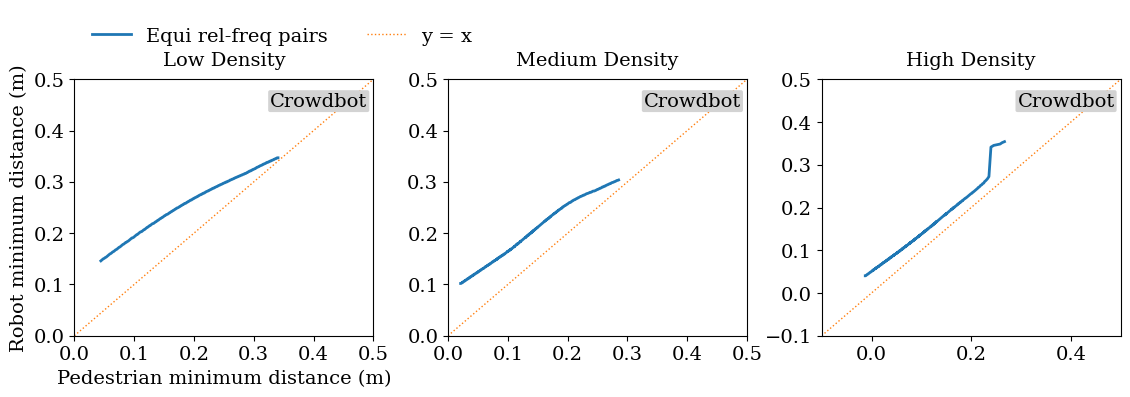

In [48]:
# Figure 2: Robot-min-distance vs Pedestrian-min-distance (equi rel-freq pairs)
n_rows = len(datasets)
n_cols = len(density_groups)

fig2, axs2 = plt.subplots(n_rows, n_cols,
                          figsize=(4.5*n_cols, 3.33*n_rows),
                          sharex=False, sharey=False)
if len(np.shape(axs2)) == 1:
    axs2 = axs2.reshape((1, n_cols))

for col, density_int in enumerate(density_groups.values()):
    for row, dataset_name in enumerate(datasets.keys()):
        ax = axs2[row, col]
        key = (dataset_name, density_int)
        entry = results_cache.get(key, None)

        if entry is None:
            ax.text(0.5, 0.5, "N/A (no cache)", ha='center', va='center', transform=ax.transAxes)
            continue

        seg = entry['segment']
        x_ped = seg['x_ped']
        y_rob = seg['x_robot']

        m = np.isfinite(x_ped) & np.isfinite(y_rob)
        x_ped = x_ped[m]; y_rob = y_rob[m]

        if x_ped.size >= 2:
            ax.plot(x_ped, y_rob, linewidth=2, label='Equi rel-freq pairs')

            # limits from data (rounded outward to 1 decimal)
            lo_raw = np.nanmin([np.nanmin(x_ped), np.nanmin(y_rob)])
            hi_raw = np.nanmax([np.nanmax(x_ped), np.nanmax(y_rob)]) + 0.1
            lo = np.floor(lo_raw * 10.0) / 10.0
            hi = np.ceil(hi_raw * 10.0) / 10.0
            if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
                lo, hi = 0.0, plotting_threshold
            ax.set_xlim(lo, hi)
            ax.set_ylim(lo, hi)

            # diagonal
            ax.plot([lo, hi], [lo, hi], linestyle=':', linewidth=1, label='y = x')

            # dataset label
            ax.text(0.98, 0.95, dataset_name, transform=ax.transAxes, fontsize=fontsize,
                    bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'),
                    va='top', ha='right')
        else:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center', transform=ax.transAxes)

# Labels & titles
axs2[-1, 0].set_xlabel("Pedestrian minimum distance (m)", fontsize=fontsize)
axs2[-1, 0].set_ylabel("Robot minimum distance (m)", fontsize=fontsize)
titles = list(density_groups.keys())
axs2[0, 0].set_title(titles[0], fontsize=fontsize, pad=10)
axs2[0, 1].set_title(titles[1], fontsize=fontsize, pad=10)
axs2[0, 2].set_title(titles[2], fontsize=fontsize, pad=10)

for ax in axs2.flat:
    ax.tick_params(axis='both', labelsize=fontsize)

# --- Shared legend above the entire figure (same pattern as Cell 1) ---
# Collect unique handles/labels across subplots
uniq_labels, uniq_handles = [], []
for ax in axs2.flat:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in uniq_labels:
            uniq_labels.append(li)
            uniq_handles.append(hi)

# Place the legend above the first axes
bbox = axs2[0, 0].get_position()
legend_ax2 = fig2.add_axes([bbox.x0, bbox.y1 + 0.160, 0.3, 0.05])
legend_ax2.axis('off')
legend_ax2.legend(uniq_handles, uniq_labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3)

fig2.subplots_adjust(wspace=0.25, hspace=0.25)
plt.show()


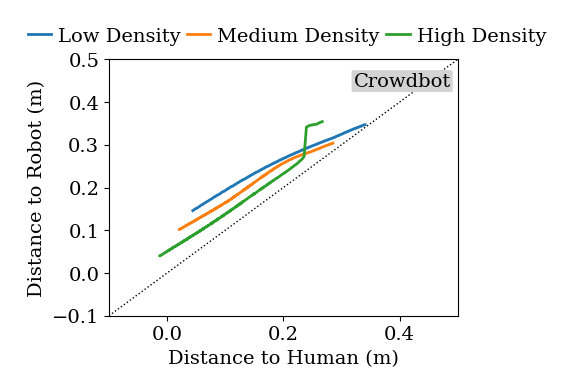

In [49]:
# Figure 3: For each dataset, overlay all densities (equi rel-freq pairs) — one row
density_labels = list(density_groups.keys())           # ['Low Density','Medium Density','High Density']
density_colors = {0: 'C0', 1: 'C1', 2: 'C2'}          # color per density-int

n_rows = len(datasets)  # number of datasets = number of columns in this single row
fig3, axs3 = plt.subplots(1, n_rows, figsize=(4.5*n_rows, 3.33), sharex=False, sharey=False)
if n_rows == 1:
    axs3 = np.array([axs3])  # ensure iterable

for col, dataset_name in enumerate(datasets.keys()):
    ax = axs3[col]
    all_x = []; all_y = []

    for density_label, density_int in density_groups.items():
        entry = results_cache.get((dataset_name, density_int), None)
        if entry is None:
            continue
        seg = entry['segment']
        x_ped = seg['x_ped']
        y_rob = seg['x_robot']
        m = np.isfinite(x_ped) & np.isfinite(y_rob)
        x_ped = x_ped[m]; y_rob = y_rob[m]
        if x_ped.size < 2:
            continue

        ax.plot(x_ped, y_rob, linewidth=2,
                color=density_colors.get(density_int, None),
                label=density_label)
        all_x.append(x_ped)
        all_y.append(y_rob)

    # limits per dataset panel (based on all densities), symmetric and rounded to 1 decimal
    if len(all_x) > 0:
        all_xc = np.concatenate(all_x)
        all_yc = np.concatenate(all_y)
        lo_raw = np.nanmin([np.nanmin(all_xc), np.nanmin(all_yc)])
        hi_raw = np.nanmax([np.nanmax(all_xc), np.nanmax(all_yc)]) + 0.1
        lo = np.floor(lo_raw * 10.0) / 10.0
        hi = np.ceil(hi_raw * 10.0) / 10.0
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            lo, hi = 0.0, plotting_threshold
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.plot([lo, hi], [lo, hi], linestyle=':', linewidth=1, color='k')  # diagonal

    # dataset label (top-right)
    ax.text(0.98, 0.95, dataset_name, transform=ax.transAxes, fontsize=fontsize,
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'),
            va='top', ha='right')

    # labels per panel (you can reduce clutter if you want)
    ax.set_xlabel("Distance to Human (m)", fontsize=fontsize)
    if col == 0:
        ax.set_ylabel("Distance to Robot (m)", fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize)

# --- Shared legend above the entire row (densities) ---
uniq_labels, uniq_handles = [], []
for ax in axs3.flat:
    h, l = ax.get_legend_handles_labels()
    for hi, li in zip(h, l):
        if li not in uniq_labels:
            uniq_labels.append(li)
            uniq_handles.append(hi)

bbox = axs3.flat[0].get_position()
legend_ax3 = fig3.add_axes([bbox.x0 - 0.22, bbox.y1 + 0.10, 0.5, 0.05])
legend_ax3.axis('off')
legend_ax3.legend(uniq_handles, uniq_labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3, handlelength=1.2, handletextpad=0.35, columnspacing=0.35)

fig3.subplots_adjust(wspace=0.25)
plt.show()


Crowdbot
                 test   mean_p    std_p
Energy (multivariate) 0.327143 0.283115


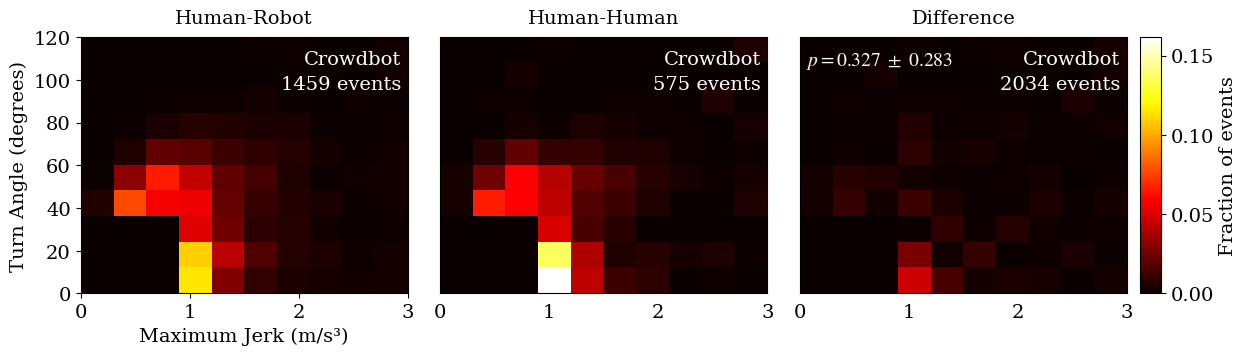

    Dataset  Mean Jerk (Human-Robot)  Std Jerk (Human-Robot)  Mean Orientation Change (Human-Robot)  Std Orientation Change (Human-Robot)  Mean Jerk (Human-Human)  Std Jerk (Human-Human)  Mean Orientation Change (Human-Human)  Std Orientation Change (Human-Human)
0  Crowdbot                 1.261077                0.591547                              40.750499                             24.400342                 1.253685                0.608192                              37.665655                             25.389918


In [50]:
def _standardize_xy(X, Y):
    """Joint z-score standardization to keep jerk/orientation on comparable scales."""
    XY = np.vstack([X, Y]).astype(float)
    mu = XY.mean(axis=0)
    sd = XY.std(axis=0, ddof=1)
    sd[sd == 0] = 1.0
    return (X - mu)/sd, (Y - mu)/sd

def _energy_distance_stat(X, Y):
    """
    Energy distance (sample version; constants cancel under permutation).
    E ~ 2*E||X-Y|| - 2*E||X-X'|| - 2*E||Y-Y'||
    """
    if len(X) == 0 or len(Y) == 0:
        return np.nan
    d_xy = cdist(X, Y).mean()
    d_xx = 0.0 if len(X) < 2 else pdist(X).mean()
    d_yy = 0.0 if len(Y) < 2 else pdist(Y).mean()
    return 2*d_xy - 2*d_xx - 2*d_yy

def energy_test_permutation(X, Y, n_perm=500, seed=0, standardize=True):
    """
    Permutation test p-value for equality of multivariate distributions using energy distance.
    """
    rng = np.random.default_rng(seed)
    X = np.asarray(X, float); Y = np.asarray(Y, float)

    # drop rows with any NaNs
    X = X[np.isfinite(X).all(axis=1)]
    Y = Y[np.isfinite(Y).all(axis=1)]
    if len(X) == 0 or len(Y) == 0:
        return np.nan, np.nan, np.nan  # stat, p, n_perm_used

    if standardize:
        X, Y = _standardize_xy(X, Y)

    Z = np.vstack([X, Y])
    n1 = len(X)
    stat_obs = _energy_distance_stat(X, Y)

    perm_stats = np.empty(n_perm, float)
    for b in range(n_perm):
        idx = rng.permutation(len(Z))
        Xb = Z[idx[:n1]]
        Yb = Z[idx[n1:]]
        perm_stats[b] = _energy_distance_stat(Xb, Yb)

    p = (1 + np.sum(perm_stats >= stat_obs)) / (1 + n_perm)
    return stat_obs, p, n_perm

def bootstrap_energy_permutation(X, Y, n_boot=100, n_perm=300, seed=9331, standardize=True):
    """
    Bootstrap (within-group resampling) of permutation p-values for energy distance.
    Returns mean p and std p over bootstrap replications.
    """
    rng = np.random.default_rng(seed)
    X = np.asarray(X, float); Y = np.asarray(Y, float)
    # drop NaNs
    X = X[np.isfinite(X).all(axis=1)]
    Y = Y[np.isfinite(Y).all(axis=1)]
    n1, n2 = len(X), len(Y)
    if n1 < 2 or n2 < 2:
        return np.nan, np.nan

    pvals = np.empty(n_boot, float)
    for b in range(n_boot):
        # resample within groups
        idx1 = rng.integers(0, n1, size=n1)
        idx2 = rng.integers(0, n2, size=n2)
        Xb = X[idx1]
        Yb = Y[idx2]
        _, pb, _ = energy_test_permutation(Xb, Yb, n_perm=n_perm, seed=rng.integers(0, 2**31-1), standardize=standardize)
        pvals[b] = pb
    return float(np.nanmean(pvals)), float(np.nanstd(pvals, ddof=1))


# ============================
# Your original code starts here; only the testing block changes
# ============================

# Plotting constants
fontsize = 14
heatmap_size = 10
jerk_max = 3
orientation_max = 120
plot_difference_column = True  # Toggle this to include/exclude difference column

# Datasets dictionary
datasets = {
    # "SiT": (SiT_all_interact_noninteract_vel_filtered, SiT_all_interact_pedestrian, SiT_frequency),
    # "JRDB": (JRDB_all_interact_noninteract_vel_filtered, JRDB_all_interact_pedestrian, JRDB_frequency),
    "Crowdbot": (CROWDBOT_all_interact_noninteract_vel_filtered, CROWDBOT_all_interact_pedestrian, CROWDBOT_frequency)
}

# Storage containers
heatmap_results = []
cached_pd_heatmaps = []
cached_pp_heatmaps = []
cached_diff_heatmaps = []
event_counts_pd = []
event_counts_pp = []
total_events = []
pval_labels = []  # (mean_p, std_p) per dataset, in the same order as plotting rows

# Process datasets and cache everything
for dataset_name, (all_interact_noninteract, ainteract_pedestrian, freq) in datasets.items():
    orient_change_time = [int(2 * fr) for fr in freq]
    event_prolong_time = [int(0.75 * fr) for fr in freq]

    _, pd_heatmap, _, jerks_pd, _, orientations_pd, _, _, mean_jerk_pd, mean_orientation_pd, _, _, std_jerk_pd, std_orientation_pd, _, count_pd, _ = generate_heatmaps_with_density(
        all_interact_noninteract,
        significant_jerk_threshold,
        significant_orientation_change,
        orient_change_time,
        event_prolong_time,
        ainteract_pedestrian,
        use_interact_pedestrian=False,
        calculation_mode="maximum",
        jerk_max=jerk_max,
        orientation_max=orientation_max,
        heatmap_size=heatmap_size,
        low_cluster_values=[],
        velocity_for_angular_velocity_threshold=velocity_for_angular_velocity_threshold
    )

    _, pp_heatmap, _, jerks_pp, _, orientations_pp, _, _, mean_jerk_pp, mean_orientation_pp, _, _, std_jerk_pp, std_orientation_pp, _, count_pp, _ = generate_heatmaps_with_density(
        all_interact_noninteract,
        significant_jerk_threshold,
        significant_orientation_change,
        orient_change_time,
        event_prolong_time,
        ainteract_pedestrian,
        use_interact_pedestrian=True,
        calculation_mode="maximum",
        jerk_max=jerk_max,
        orientation_max=orientation_max,
        heatmap_size=heatmap_size,
        low_cluster_values=[],
        velocity_for_angular_velocity_threshold=velocity_for_angular_velocity_threshold
    )

    # --- NEW: multivariate Energy test with bootstrap (jerk & orientation jointly) ---
    X_hr = np.column_stack([np.asarray(jerks_pd, float),        np.asarray(orientations_pd, float)])
    X_hh = np.column_stack([np.asarray(jerks_pp, float),        np.asarray(orientations_pp, float)])

    # Cache points for KDE later (once per dataset)
    if 'kde_points_cache' not in globals():
        kde_points_cache = {}

    kde_points_cache[dataset_name] = {
        'HR': np.asarray(X_hr, float),   # shape (n_hr, 2): [jerk, orientation]
        'HH': np.asarray(X_hh, float),   # shape (n_hh, 2)
    }

    mean_p_energy, std_p_energy = bootstrap_energy_permutation(
        X_hr, X_hh,
        n_boot=100,     # match your previous n_iterations
        n_perm=300,     # permutation count per bootstrap (tune for speed/accuracy)
        seed=9331,
        standardize=True
    )
    pval_labels.append((mean_p_energy, std_p_energy))  # keep numeric; format later

    # --- pack results into a DataFrame and print (energy only now) ---
    results_df = pd.DataFrame([
        {"test": "Energy (multivariate)", "mean_p": mean_p_energy, "std_p": std_p_energy},
    ])

    print(dataset_name)
    print(results_df.to_string(index=False))

    # Cache values
    cached_pd_heatmaps.append(pd_heatmap)
    cached_pp_heatmaps.append(pp_heatmap)
    event_counts_pd.append(count_pd)
    event_counts_pp.append(count_pp)
    total_events.append(count_pd + count_pp)

    if plot_difference_column:
        cached_diff_heatmaps.append(np.abs(pp_heatmap - pd_heatmap))

    # Save stats (unchanged descriptive stats)
    heatmap_results.append({
        "Dataset": dataset_name,
        "Mean Jerk (Human-Robot)": mean_jerk_pd,
        "Std Jerk (Human-Robot)": std_jerk_pd,
        "Mean Orientation Change (Human-Robot)": mean_orientation_pd,
        "Std Orientation Change (Human-Robot)": std_orientation_pd,
        "Mean Jerk (Human-Human)": mean_jerk_pp,
        "Std Jerk (Human-Human)": std_jerk_pp,
        "Mean Orientation Change (Human-Human)": mean_orientation_pp,
        "Std Orientation Change (Human-Human)": std_orientation_pp,
    })

# Global normalization (based on Crowdbot only)
crowdbot_index = list(datasets.keys()).index("Crowdbot")
max_val = max(
    cached_pd_heatmaps[crowdbot_index].max(),
    cached_pp_heatmaps[crowdbot_index].max()
)
global_norm = colors_mpl.Normalize(vmin=0, vmax=max_val)

# Plotting setup
n_cols = 3 if plot_difference_column else 2
fig, axs = plt.subplots(len(datasets), n_cols, figsize=(4.5 * n_cols, 3.33 * len(datasets)), sharex=True, sharey=True)

if(len(axs.shape) == 1):
    if plot_difference_column:
        axs = axs.reshape((1,3))
    else:
        axs = axs.reshape((1,2))

for row, dataset_name in enumerate(datasets.keys()):
    pd_heatmap = cached_pd_heatmaps[row]
    pp_heatmap = cached_pp_heatmaps[row]
    count_pd = event_counts_pd[row]
    count_pp = event_counts_pp[row]

    # HR
    axs[row, 0].imshow(pd_heatmap, extent=[0, jerk_max, 0, orientation_max],
                       origin="lower", aspect="auto", cmap="hot", interpolation="nearest", norm=global_norm)
    axs[row, 0].text(0.98, 0.95, f"{dataset_name}", transform=axs[row, 0].transAxes,
                     fontsize=fontsize, color='white', va='top', ha='right')
    axs[row, 0].text(0.98, 0.85, f"{count_pd} events", transform=axs[row, 0].transAxes,
                     fontsize=fontsize, color='white', va='top', ha='right')

    # HH
    axs[row, 1].imshow(pp_heatmap, extent=[0, jerk_max, 0, orientation_max],
                       origin="lower", aspect="auto", cmap="hot", interpolation="nearest", norm=global_norm)
    axs[row, 1].text(0.98, 0.95, f"{dataset_name}", transform=axs[row, 1].transAxes,
                     fontsize=fontsize, color='white', va='top', ha='right')
    axs[row, 1].text(0.98, 0.85, f"{count_pp} events", transform=axs[row, 1].transAxes,
                     fontsize=fontsize, color='white', va='top', ha='right')

    # Diff
    if plot_difference_column:
        diff_heatmap = cached_diff_heatmaps[row]
        axs[row, 2].imshow(
            diff_heatmap, extent=[0, jerk_max, 0, orientation_max],
            origin="lower", aspect="auto", cmap="hot", interpolation="nearest", norm=global_norm
        )
        axs[row, 2].text(
            0.98, 0.95, f"{dataset_name}", transform=axs[row, 2].transAxes,
            fontsize=fontsize, color='white', va='top', ha='right'
        )
        axs[row, 2].text(
            0.98, 0.85, f"{total_events[row]} events", transform=axs[row, 2].transAxes,
            fontsize=fontsize, color='white', va='top', ha='right'
        )

        # --- Energy p-value in the upper-left corner of the DIFF subplot ---
        mean_p, std_p = pval_labels[row]
        p_text = rf"$p={mean_p:.3f}\ \pm\ {std_p:.3f}$"
        axs[row, 2].text(
            0.02, 0.95, p_text,
            transform=axs[row, 2].transAxes,
            fontsize=fontsize, color='white', va='top', ha='left'
        )

# Axis labels and cleanup
axs[-1, 0].set_xlabel("Maximum Jerk (m/s³)", fontsize=fontsize)
axs[-1, 0].set_ylabel("Turn Angle (degrees)", fontsize=fontsize)

for ax in axs.flat:
    if ax != axs[-1, 0]:
        ax.tick_params(left=False, bottom=False,)
    ax.tick_params(axis='both', labelsize=fontsize)

# Column titles
axs[0, 0].set_title('Human-Robot', fontsize=fontsize, pad=10)
axs[0, 1].set_title('Human-Human', fontsize=fontsize, pad=10)
if plot_difference_column:
    axs[0, 2].set_title('Difference', fontsize=fontsize, pad=10)

# Shared colorbar
bbox_top = axs[0, n_cols - 1].get_position()
bbox_bottom = axs[-1, n_cols - 1].get_position()
cbar_width = 0.015
cbar_pad = 0.01
cbar_ax = fig.add_axes([
    bbox_top.x1 + cbar_pad,
    bbox_bottom.y0,
    cbar_width,
    bbox_top.y1 - bbox_bottom.y0
])
sm = plt.cm.ScalarMappable(cmap="hot", norm=global_norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Fraction of events', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplots_adjust(wspace=0.10, hspace=0.1)
plt.show()

# Result table
heatmap_results_df = pd.DataFrame(heatmap_results)
with pd.option_context('display.max_columns', None, 'display.width', 3000):
    print(heatmap_results_df)

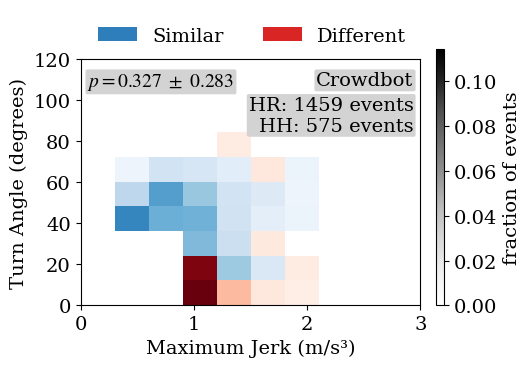

In [51]:
# --- settings ---
tau_rel        = 0.20     # relative difference threshold for similarity (used only in mask)
fine_n         = 400      # KDE evaluation grid per axis
bandwidth      = None     # None => Scott's rule in pooled z-space
low_mass_floor = 0.005     # pooled original fraction threshold to blank bins

# --- helper: KDE→coarse masses & similarity (only used to build sim mask) ---
if '_kde_coarse_from_points' not in globals():
    def _kde_coarse_from_points(X_hr, X_hh, xlim, ylim, heatmap_size=10, tau=0.20, fine_n=400, bandwidth=None):
        X_hr = np.asarray(X_hr, float); X_hh = np.asarray(X_hh, float)

        def _clip(X):
            j = X[:, 0]; o = X[:, 1]
            m = np.isfinite(j) & np.isfinite(o) & (j>=xlim[0]) & (j<=xlim[1]) & (o>=ylim[0]) & (o<=ylim[1])
            return np.column_stack((j[m], o[m]))
        X_hr = _clip(X_hr); X_hh = _clip(X_hh)

        ny = nx = int(heatmap_size)
        x_edges = np.linspace(xlim[0], xlim[1], nx + 1)
        y_edges = np.linspace(ylim[0], ylim[1], ny + 1)

        if X_hr.shape[0] < 5 or X_hh.shape[0] < 5:
            Pz = np.zeros((ny, nx), float)
            return Pz.copy(), Pz.copy(), np.zeros_like(Pz, bool), x_edges, y_edges

        XY = np.vstack([X_hr, X_hh])
        mu = XY.mean(axis=0)
        sd = XY.std(axis=0, ddof=1); sd[sd==0] = 1.0
        def _z(X): return (X - mu) / sd
        Z_hr = _z(X_hr); Z_hh = _z(X_hh)

        if bandwidth is None:
            n_tot = XY.shape[0]
            bw = n_tot ** (-1.0/6.0)  # Scott in d=2
        else:
            bw = float(bandwidth)

        nx_f = ny_f = int(fine_n)
        x_f = np.linspace(xlim[0], xlim[1], nx_f)
        y_f = np.linspace(ylim[0], ylim[1], ny_f)
        dx = (x_f[-1] - x_f[0]) / (nx_f - 1)
        dy = (y_f[-1] - y_f[0]) / (ny_f - 1)
        Xg, Yg = np.meshgrid(x_f, y_f)
        Zq = np.column_stack(((Xg.ravel()-mu[0])/sd[0], (Yg.ravel()-mu[1])/sd[1]))

        kde_hr = KernelDensity(kernel='gaussian', bandwidth=bw).fit(Z_hr)
        kde_hh = KernelDensity(kernel='gaussian', bandwidth=bw).fit(Z_hh)
        D_hr = np.exp(kde_hr.score_samples(Zq)).reshape(ny_f, nx_f)
        D_hh = np.exp(kde_hh.score_samples(Zq)).reshape(ny_f, nx_f)

        s_hr = D_hr.sum()*dx*dy; s_hh = D_hh.sum()*dx*dy
        if s_hr>0: D_hr /= s_hr
        if s_hh>0: D_hh /= s_hh

        ix = np.searchsorted(x_edges, Xg.ravel(), side='right') - 1
        iy = np.searchsorted(y_edges, Yg.ravel(), side='right') - 1
        valid = (ix>=0)&(ix<nx)&(iy>=0)&(iy<ny)

        P_hr_bin = np.zeros((ny,nx), float)
        P_hh_bin = np.zeros((ny,nx), float)
        np.add.at(P_hr_bin, (iy[valid], ix[valid]), (D_hr.ravel()[valid] * dx * dy))
        np.add.at(P_hh_bin, (iy[valid], ix[valid]), (D_hh.ravel()[valid] * dx * dy))

        if P_hr_bin.sum()>0: P_hr_bin /= P_hr_bin.sum()
        if P_hh_bin.sum()>0: P_hh_bin /= P_hh_bin.sum()

        avg  = 0.5*(P_hr_bin + P_hh_bin)
        diff = np.abs(P_hr_bin - P_hh_bin)
        sim_mask = diff <= (tau * np.maximum(avg, 1e-15))
        return P_hr_bin, P_hh_bin, sim_mask, x_edges, y_edges

# --- build SIMILAR/DIFFERENT from KDE, but INTENSITY from ORIGINAL heatmaps ---
kde_sim_mask_cache = {}
xlim = (0.0, float(jerk_max))
ylim = (0.0, float(orientation_max))

for row, dataset_name in enumerate(datasets.keys()):
    entry = kde_points_cache.get(dataset_name, None)
    if entry is None:
        continue
    _, _, sim_mask_kde, x_edges, y_edges = _kde_coarse_from_points(
        entry['HR'], entry['HH'],
        xlim=xlim, ylim=ylim,
        heatmap_size=int(heatmap_size),
        tau=tau_rel, fine_n=fine_n, bandwidth=bandwidth
    )
    kde_sim_mask_cache[dataset_name] = {
        'sim_mask': sim_mask_kde,
        'x_edges': x_edges,
        'y_edges': y_edges
    }

# --- plotting using ORIGINAL heatmaps for intensity ---
dataset_names = list(datasets.keys())
n_rows = len(dataset_names)
fig, axs = plt.subplots(n_rows, 1, figsize=(4.5, 3.33 * n_rows), sharex=True, sharey=True)
if n_rows == 1:
    axs = np.array([axs])

# color norm from original HR fractions
global_vmax = 0.0
P_hr_orig_list = []
empty_mask_list = []
for row, dataset_name in enumerate(dataset_names):
    # original coarse maps
    D_hr = np.asarray(cached_pd_heatmaps[row], float)
    D_hh = np.asarray(cached_pp_heatmaps[row], float)
    s_hr = D_hr.sum(); s_hh = D_hh.sum()
    P_hr = D_hr / s_hr if s_hr>0 else np.zeros_like(D_hr, float)
    P_hh = D_hh / s_hh if s_hh>0 else np.zeros_like(D_hh, float)

    # (1) blank bins below both thresholds (upper-edge test)
    x_edges = kde_sim_mask_cache[dataset_name]['x_edges']
    y_edges = kde_sim_mask_cache[dataset_name]['y_edges']
    x_hi = x_edges[1:]; y_hi = y_edges[1:]
    mask_below_both = (x_hi[np.newaxis, :] <= significant_jerk_threshold) & \
                      (y_hi[:, np.newaxis]  <= significant_orientation_change)

    # (2) blank bins with pooled original fraction < 0.01
    pooled_avg_orig = 0.5*(P_hr + P_hh)
    mask_low_mass = pooled_avg_orig < low_mass_floor

    empty_mask = mask_below_both | mask_low_mass

    P_hr_orig_list.append(P_hr)
    empty_mask_list.append(empty_mask)
    global_vmax = max(global_vmax, float(np.nanmax(P_hr)))

norm = mpl.colors.Normalize(vmin=0.0, vmax=(global_vmax if np.isfinite(global_vmax) and global_vmax>0 else 1.0))

for row, dataset_name in enumerate(dataset_names):
    ax = axs[row]
    if dataset_name not in kde_sim_mask_cache:
        ax.text(0.5, 0.5, "No KDE mask", ha='center', va='center', transform=ax.transAxes)
        continue

    P_hr = P_hr_orig_list[row]
    empty = empty_mask_list[row]
    sim_mask = kde_sim_mask_cache[dataset_name]['sim_mask']

    # overlay: similar (blue), different (red), using ORIGINAL HR fraction as intensity
    sim_vals  = np.where((~empty) &  sim_mask, P_hr, np.nan)
    diff_vals = np.where((~empty) & (~sim_mask), P_hr, np.nan)

    ax.imshow(sim_vals,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
              origin='lower', aspect='auto', cmap='Blues', interpolation='nearest', norm=norm)
    ax.imshow(diff_vals, extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
              origin='lower', aspect='auto', cmap='Reds',  interpolation='nearest', norm=norm)

    # annotations
    ax.text(0.98, 0.95, f"{dataset_name}", transform=ax.transAxes,
            fontsize=fontsize, va='top', ha='right',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    ax.text(0.98, 0.85, f"HR: {event_counts_pd[row]} events\nHH: {event_counts_pp[row]} events",
            transform=ax.transAxes, fontsize=fontsize, va='top', ha='right',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    mean_p, std_p = pval_labels[row]
    ax.text(0.02, 0.95, rf"$p={mean_p:.3f}\ \pm\ {std_p:.3f}$",
            transform=ax.transAxes, fontsize=fontsize, va='top', ha='left',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.tick_params(axis='both', labelsize=fontsize)

# labels
axs[-1].set_xlabel("Maximum Jerk (m/s³)", fontsize=fontsize)
axs[0].set_ylabel("Turn Angle (degrees)", fontsize=fontsize)

# shared colorbar (original HR fraction)
bbox_top = axs[0].get_position(); bbox_bottom = axs[-1].get_position()
cbar_width = 0.018; cbar_pad = 0.015
cax = fig.add_axes([bbox_top.x1 + cbar_pad, bbox_bottom.y0, cbar_width, bbox_top.y1 - bbox_bottom.y0])
sm = mpl.cm.ScalarMappable(norm=norm, cmap='Greys'); sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('fraction of events', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# legend (no τ in text)
legend_handles = [
    Patch(facecolor=mpl.cm.Blues(0.7), label='Similar'),
    Patch(facecolor=mpl.cm.Reds(0.7),  label='Different')
]
bbox0 = axs[0].get_position()
legend_ax = fig.add_axes([bbox0.x0, bbox0.y1 + 0.06, 0.75, 0.06])
legend_ax.axis('off')
legend_ax.legend(legend_handles, [h.get_label() for h in legend_handles],
                 loc='upper left', fontsize=fontsize, frameon=False, ncol=2)

plt.subplots_adjust(hspace=0.12, right=0.88, top=0.85)
plt.show()

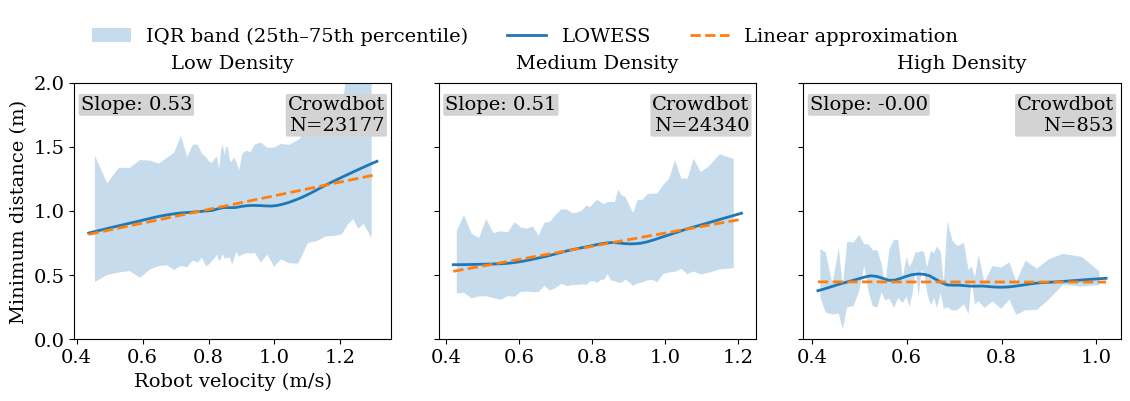

Crowdbot — Δ Minimum distance per 1 m/s (linear approx of LOWESS)
       Density     N  Delta (m per m/s)
   Low Density 23177             0.5348
Medium Density 24340             0.5139
  High Density   853            -0.0027


In [54]:
# =========================
# Helpers
# =========================
def lowess_curve(x, y, x_grid, frac=0.3, it=0):
    """LOWESS fit interpolated to x_grid (no CI)."""
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 5:
        return np.full_like(x_grid, np.nan, dtype=float)
    order = np.argsort(x)
    xs, ys = x[order], y[order]
    sm = lowess(endog=ys, exog=xs, frac=frac, it=it, return_sorted=True)  # (n_s, 2): [x, yhat]
    if sm.shape[0] < 2 or np.allclose(sm[:, 0].ptp(), 0):
        return np.full_like(x_grid, np.nan, dtype=float)
    return np.interp(x_grid, sm[:, 0], sm[:, 1])

def binned_quantile_band(x, y, n_bins=20, q_lo=0.25, q_hi=0.75, min_per_bin=10, use_quantile_bins=True):
    """
    Compute per-bin quantile band for y across x.
    Returns centers, qlo_vals, qhi_vals (each length = #valid bins).
    """
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < min_per_bin:
        return np.array([]), np.array([]), np.array([])

    if use_quantile_bins:
        edges = np.quantile(x, np.linspace(0, 1, n_bins + 1))
        edges = np.unique(edges)
        if edges.size < 3:
            return np.array([]), np.array([]), np.array([])
    else:
        edges = np.linspace(np.min(x), np.max(x), n_bins + 1)

    centers, lo_vals, hi_vals = [], [], []
    for lo, hi in zip(edges[:-1], edges[1:]):
        mask = (x >= lo) & (x < hi) if hi < edges[-1] else (x >= lo) & (x <= hi)
        if mask.sum() >= min_per_bin:
            centers.append(0.5 * (lo + hi))
            lo_vals.append(np.quantile(y[mask], q_lo))
            hi_vals.append(np.quantile(y[mask], q_hi))

    return np.asarray(centers), np.asarray(lo_vals), np.asarray(hi_vals)

# =========================
# Config
# =========================
fontsize = 14
dataset_name = "Crowdbot"

# LOWESS settings
LOWESS_FRAC = 0.3
LOWESS_IT   = 2
LOWESS_GRID = 50  # number of x-points to evaluate the LOWESS curve

# Bands settings (quantile bins)
NBINS_BANDS   = 50     # number of velocity bins to compute 25th/75th percentiles
MIN_PER_BIN   = 15     # skip very sparse bins
TRIM_X_QUANT  = (0.02, 0.98)   # e.g., (0.01, 0.99); None = no trim

# Data (interacting frames only)
df = CROWDBOT_device_metrics_valid_vel_df[
    CROWDBOT_device_metrics_valid_vel_df['minimum_distance_interact'].fillna(False)
].copy()
df = df[['density_cluster', 'device_velocity', 'minimum_distance']].replace([np.inf, -np.inf], np.nan).dropna()

density_groups = {
    "Low Density": 0,
    "Medium Density": 1,
    "High Density": 2
}

# Colors for densities
density_colors = {0: 'C0', 1: 'C1', 2: 'C2'}

# =========================
# Plot + compute slopes
# =========================
fig, axs = plt.subplots(1, 3, figsize=(4.5*3, 3.33), sharey=True)

rows = []
slope_by_cluster = {0: np.nan, 1: np.nan, 2: np.nan}  # store per-density slopes

# We'll collect legend handles from the first subplot and then put a shared legend on top
legend_handles = None
legend_labels  = None

for ax, (density_label, cluster_val) in zip(axs, density_groups.items()):
    sub = df[df['density_cluster'] == cluster_val]
    ax.set_title(density_label, fontsize=fontsize, pad=10)

    if sub.empty:
        continue

    vx = sub['device_velocity'].to_numpy()
    vy = sub['minimum_distance'].to_numpy()

    # Optional trimming of extreme velocities
    if TRIM_X_QUANT is not None:
        q_lo, q_hi = np.quantile(vx, TRIM_X_QUANT)
        keep = (vx >= q_lo) & (vx <= q_hi)
        vx, vy = vx[keep], vy[keep]

    if vx.size < 5:
        continue

    # ---- IQR band (25th–75th percentile) via x-quantile bins ----
    centers, q25, q75 = binned_quantile_band(vx, vy, n_bins=NBINS_BANDS, q_lo=0.25, q_hi=0.75,
                                             min_per_bin=MIN_PER_BIN, use_quantile_bins=True)
    band_handle = None
    if centers.size > 2:
        band_handle = ax.fill_between(centers, q25, q75, alpha=0.25, linewidth=0,
                                      label="IQR band (25th–75th percentile)")

    # ---- LOWESS (frac=0.3, it=2) on a 50-point grid ----
    xg = np.linspace(vx.min(), vx.max(), LOWESS_GRID)
    yhat = lowess_curve(vx, vy, xg, frac=LOWESS_FRAC, it=LOWESS_IT)
    lowess_handle = ax.plot(xg, yhat, linewidth=2, label="LOWESS")[0]

    # ---- Linear approximation of LOWESS ----
    mfin = np.isfinite(xg) & np.isfinite(yhat)
    if mfin.sum() >= 2:
        slope, intercept = np.polyfit(xg[mfin], yhat[mfin], 1)  # slope in meters per (m/s)
        yg_lin = intercept + slope * xg
        lin_handle = ax.plot(xg, yg_lin, linestyle='--', linewidth=2, label="Linear approximation")[0]
        slope_by_cluster[cluster_val] = float(slope)
        rows.append({"Density": density_label, "N": int(vx.size), "Delta (m per m/s)": float(slope)})
    else:
        lin_handle = None
        rows.append({"Density": density_label, "N": int(vx.size), "Delta (m per m/s)": np.nan})

    # collect legend handles once (from the first subplot)
    if legend_handles is None:
        handles = []
        labels  = []
        if band_handle is not None:
            handles.append(band_handle); labels.append("IQR band (25th–75th percentile)")
        handles.append(lowess_handle); labels.append("LOWESS")
        if lin_handle is not None:
            handles.append(lin_handle); labels.append("Linear approximation")
        legend_handles, legend_labels = handles, labels

    # Cosmetics
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.text(0.98, 0.95, f"{dataset_name}\nN={len(vx)}", transform=ax.transAxes,
            fontsize=fontsize, va='top', ha='right',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    ax.set_ylim(0, 2)

# Y label only on leftmost; X label only on leftmost (per your request)
axs[0].set_ylabel("Minimum distance (m)", fontsize=fontsize)
axs[0].set_xlabel("Robot velocity (m/s)", fontsize=fontsize)
for ax in axs[1:]:
    ax.set_xlabel("")

# Per-subplot slope annotation (upper-left): only this density's slope
y = 0.95
x = 0.25
for ax, (_, cid) in zip(axs, density_groups.items()):
    # Upper-left “Slope” annotation (multi-line, colored values)
    v = slope_by_cluster.get(cid, np.nan)
    ax.text(0.02, 0.95, f"Slope: {v:.2f}", transform=ax.transAxes,
            ha='left', va='top', fontsize=fontsize,
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))
    

# Legend above the row
bbox = axs[0].get_position()
legend_ax = fig.add_axes([bbox.x0, bbox.y1 + 0.17, 0.6, 0.05])
legend_ax.axis('off')
legend_ax.legend(legend_handles, legend_labels, loc='upper left',
                 fontsize=fontsize, frameon=False, ncol=3,)
                #  handlelength=1.2, handletextpad=0.35, columnspacing=0.35)

plt.subplots_adjust(wspace=0.15, hspace=0.1)
plt.show()

# =========================
# Print slopes table
# =========================
slopes_df = pd.DataFrame(rows)
with pd.option_context('display.max_columns', None, 'display.precision', 4):
    print(f"{dataset_name} — Δ Minimum distance per 1 m/s (linear approx of LOWESS)")
    print(slopes_df.to_string(index=False))


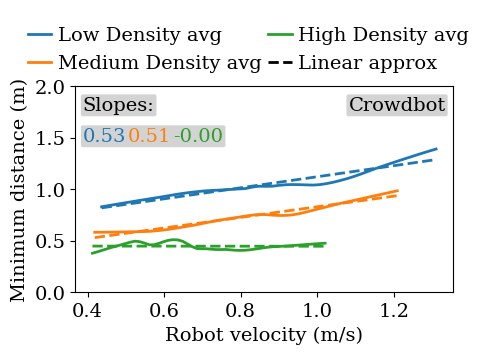

Crowdbot — Δ Minimum distance per 1 m/s (linear approx of LOWESS)
       Density     N  Delta (m per m/s)
   Low Density 23177             0.5348
Medium Density 24340             0.5139
  High Density   853            -0.0027


In [55]:
# === One-figure version: all densities in one axes ===

fig, ax = plt.subplots(figsize=(4.5, 3.33))

density_colors = {0: 'C0', 1: 'C1', 2: 'C2'}  # Low/Med/High

rows = []
density_lowess_handles = []
slope_by_cluster = {0: np.nan, 1: np.nan, 2: np.nan}

total_N = 0
for density_label, cluster_val in density_groups.items():
    sub = df[df['density_cluster'] == cluster_val]

    if sub.empty:
        continue

    vx = sub['device_velocity'].to_numpy()
    vy = sub['minimum_distance'].to_numpy()

    # optional trimming in x (velocity)
    if TRIM_X_QUANT is not None:
        q_lo, q_hi = np.quantile(vx, TRIM_X_QUANT)
        keep = (vx >= q_lo) & (vx <= q_hi)
        vx, vy = vx[keep], vy[keep]

    if vx.size < MIN_PER_BIN or vx.size < 5:
        continue

    total_N += vx.size

    c = density_colors.get(cluster_val, None)

    # --- LOWESS curve ---
    xg = np.linspace(vx.min(), vx.max(), LOWESS_GRID)
    yhat = lowess_curve(vx, vy, xg, frac=LOWESS_FRAC, it=LOWESS_IT)
    lh, = ax.plot(xg, yhat, linewidth=2, color=c, label=f"{density_label} avg")
    density_lowess_handles.append(lh)

    # --- Linear approximation of LOWESS ---
    mfin = np.isfinite(xg) & np.isfinite(yhat)
    if mfin.sum() >= 2:
        slope, intercept = np.polyfit(xg[mfin], yhat[mfin], 1)
        slope_by_cluster[cluster_val] = slope  # store slope for this density
        yg_lin = intercept + slope * xg
        ax.plot(xg, yg_lin, linestyle='--', linewidth=2, color=c)
        rows.append({"Density": density_label, "N": int(vx.size), "Delta (m per m/s)": float(slope)})
    else:
        rows.append({"Density": density_label, "N": int(vx.size), "Delta (m per m/s)": np.nan})

# Axes labels and limits
ax.set_xlabel("Robot velocity (m/s)", fontsize=fontsize)
ax.set_ylabel("Minimum distance (m)", fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylim(0, 2)

# Dataset annotation (top-right)
ax.text(0.98, 0.95, f"{dataset_name}", transform=ax.transAxes,
        fontsize=fontsize, va='top', ha='right',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

# Upper-left “Slope” annotation (multi-line, colored values)
ax.text(0.02, 0.95, "Slopes:", transform=ax.transAxes,
        ha='left', va='top', fontsize=fontsize,
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

# Upper-left, three colored values (Low/Med/High), side-by-side
dx = 0.12  # starting x and spacing in axes coords
vals = [
    (slope_by_cluster[0], density_colors.get(0, 'C0')),  # Low
    (slope_by_cluster[1], density_colors.get(1, 'C1')),  # Medium
    (slope_by_cluster[2], density_colors.get(2, 'C2')),  # High
]
for i, (v, col) in enumerate(vals):
    txt = f"{v:.2f}" if np.isfinite(v) else "N/A"
    ax.text(0.02 + i*dx, 0.80, txt, transform=ax.transAxes,
            ha='left', va='top', fontsize=fontsize, color=col,
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

# Density entries (LOWESS lines collected)
handles = list(density_lowess_handles)
labels  = [h.get_label() for h in handles]

# Style keys
handles += [
    Line2D([0],[0], color='k', linestyle='--', linewidth=2, label='Linear approx'),
]
labels  += ['Linear approx']

bbox = ax.get_position()
legend_ax = fig.add_axes([bbox.x0 - 0.15, bbox.y1 + 0.1, 0.6, 0.05])
legend_ax.axis('off')
# legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=2)
legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False,
                     ncol=2, handlelength=1.2, handletextpad=0.35, columnspacing=0.35)

plt.subplots_adjust(top=0.80, right=0.96, left=0.12, bottom=0.18)
plt.show()

# (Optional) print slopes table
slopes_df = pd.DataFrame(rows)
with pd.option_context('display.max_columns', None, 'display.precision', 4):
    print(f"{dataset_name} — Δ Minimum distance per 1 m/s (linear approx of LOWESS)")
    print(slopes_df.to_string(index=False))


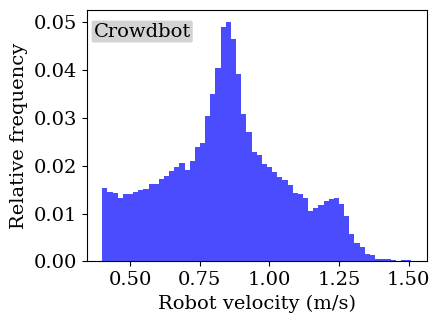

In [56]:
# --- Velocity Distribution Plot (One Histogram, Custom Bar Colors) ---

# Plotting constants
bins_velocity = 60
fontsize = 14

# Dataset
dataset_name = "Crowdbot"
# df = CROWDBOT_device_metrics_valid_vel_df
df = CROWDBOT_device_metrics_valid_vel_df[CROWDBOT_device_metrics_valid_vel_df['minimum_distance_interact'].fillna(False)]

# Create figure
fig, ax = plt.subplots(figsize=(4.5, 3.33))

# Velocities
velocities = df["device_velocity"].dropna()

# Create the histogram
# counts, bin_edges, patches = ax.hist(velocities, bins=bins_velocity, color='gray', alpha=0.7, density=True)
counts, bin_edges, patches = ax.hist(velocities, bins=bins_velocity, color='blue', alpha=0.7, weights=np.ones_like(velocities) / len(velocities))


ax.text(0.02, 0.95, dataset_name, transform=ax.transAxes,
            fontsize=fontsize, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

# Labels and title
ax.set_xlabel('Robot velocity (m/s)', fontsize=fontsize)
ax.set_ylabel('Relative frequency', fontsize=fontsize)

# Customize ticks
ax.tick_params(axis='both', labelsize=fontsize)

# Layout
plt.tight_layout()
plt.show()


#### Sensitivity analysis plots

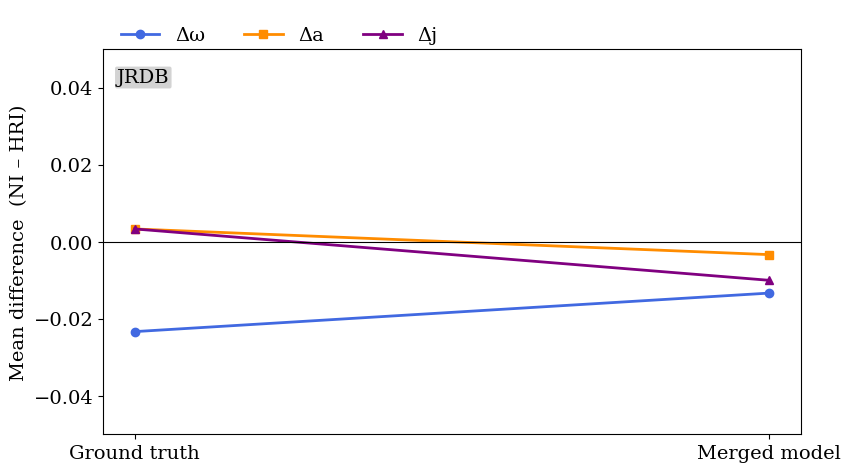

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) DATA  (already provided)
# ─────────────────────────────────────────────────────────────────────────────
# JRDB_gt_ang_vel_NI   = np.array([0.18, 0.21, 0.26])
# JRDB_gt_ang_vel_HRI  = np.array([0.21, 0.22, 0.27])

# JRDB_gt_lin_acc_NI   = np.array([0.13, 0.15, 0.16])
# JRDB_gt_lin_acc_HRI  = np.array([0.13, 0.15, 0.15])

# JRDB_gt_lin_jerk_NI  = np.array([0.31, 0.34, 0.37])
# JRDB_gt_lin_jerk_HRI = np.array([0.30, 0.29, 0.34])

# JRDB_merged_ang_vel_NI   = np.array([0.16, 0.21, 0.28])
# JRDB_merged_ang_vel_HRI  = np.array([0.19, 0.21, 0.26])

# JRDB_merged_lin_acc_NI   = np.array([0.13, 0.15, 0.17])
# JRDB_merged_lin_acc_HRI  = np.array([0.13, 0.14, 0.17])

# JRDB_merged_lin_jerk_NI  = np.array([0.25, 0.30, 0.29])
# JRDB_merged_lin_jerk_HRI = np.array([0.26, 0.27, 0.31])

JRDB_gt_ang_vel_NI   = np.array([0.19, 0.21, 0.24])
JRDB_gt_ang_vel_HRI  = np.array([0.23, 0.24, 0.24])

JRDB_gt_lin_acc_NI   = np.array([0.16, 0.16, 0.15])
JRDB_gt_lin_acc_HRI  = np.array([0.15, 0.15, 0.16])

JRDB_gt_lin_jerk_NI  = np.array([0.25, 0.25, 0.22])
JRDB_gt_lin_jerk_HRI = np.array([0.24, 0.23, 0.24])

JRDB_merged_ang_vel_NI   = np.array([0.16, 0.21, 0.26])
JRDB_merged_ang_vel_HRI  = np.array([0.20, 0.23, 0.24])

JRDB_merged_lin_acc_NI   = np.array([0.13, 0.15, 0.15])
JRDB_merged_lin_acc_HRI  = np.array([0.13, 0.15, 0.16])

JRDB_merged_lin_jerk_NI  = np.array([0.21, 0.23, 0.23])
JRDB_merged_lin_jerk_HRI = np.array([0.23, 0.23, 0.24])

# ─────────────────────────────────────────────────────────────────────────────
# 2)  DIFFERENCES  (NI – HRI)  &  DENSITY-AVERAGED VALUES
# ─────────────────────────────────────────────────────────────────────────────
Δ_gt_ang_vel   = (JRDB_gt_ang_vel_NI   - JRDB_gt_ang_vel_HRI).mean()
Δ_gt_lin_acc   = (JRDB_gt_lin_acc_NI   - JRDB_gt_lin_acc_HRI).mean()
Δ_gt_lin_jerk  = (JRDB_gt_lin_jerk_NI  - JRDB_gt_lin_jerk_HRI).mean()

Δ_mm_ang_vel   = (JRDB_merged_ang_vel_NI   - JRDB_merged_ang_vel_HRI).mean()
Δ_mm_lin_acc   = (JRDB_merged_lin_acc_NI   - JRDB_merged_lin_acc_HRI).mean()
Δ_mm_lin_jerk  = (JRDB_merged_lin_jerk_NI  - JRDB_merged_lin_jerk_HRI).mean()

# Pack into one dictionary for neat looping
metrics = {
    'Δω': dict(col='royalblue', m='o',
                                  y=[Δ_gt_ang_vel, Δ_mm_ang_vel]),
    'Δa': dict(col='darkorange', m='s',
                                     y=[Δ_gt_lin_acc, Δ_mm_lin_acc]),
    'Δj': dict(col='purple', m='^',
                             y=[Δ_gt_lin_jerk, Δ_mm_lin_jerk]),
}

# ─────────────────────────────────────────────────────────────────────────────
# 3)  PLOT  (x-axis: 0 = GT, 1 = MM)
# ─────────────────────────────────────────────────────────────────────────────
x = np.array([0, 1])
x_labels = ['Ground truth', 'Merged model']

fontsize = 14
fig, ax = plt.subplots(figsize=(9, 5))

for name, meta in metrics.items():
    plt.plot(x, meta['y'],
             color=meta['col'], marker=meta['m'], linewidth=2,
             label=name)

# Axis styling
# plt.xlabel('Metric source', fontsize=fontsize)
ax.set_ylabel('Mean difference  (NI – HRI)', fontsize=fontsize)
ax.set_xticks(x, x_labels)
ax.axhline(0, color='black', linewidth=0.8)
ax.tick_params(axis='both', labelsize=fontsize)

# Dataset label
ax.text(0.02, 0.95, 'JRDB',
        transform=ax.transAxes,
        fontsize=fontsize,
        ha='left', va='top',
        bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.1'))

# Legend
ax.set_ylim(-0.05, 0.05)
# ax.legend(fontsize=fontsize)
handles, labels = ax.get_legend_handles_labels()
bbox = ax.get_position()
legend_ax = fig.add_axes([
bbox.x0,           # align left with subplot
bbox.y1 + 0.03,   # slightly above top of subplot
0.3,               # width
0.05               # height
])
legend_ax.axis('off')
legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=3,)

# plt.tight_layout()
plt.show()

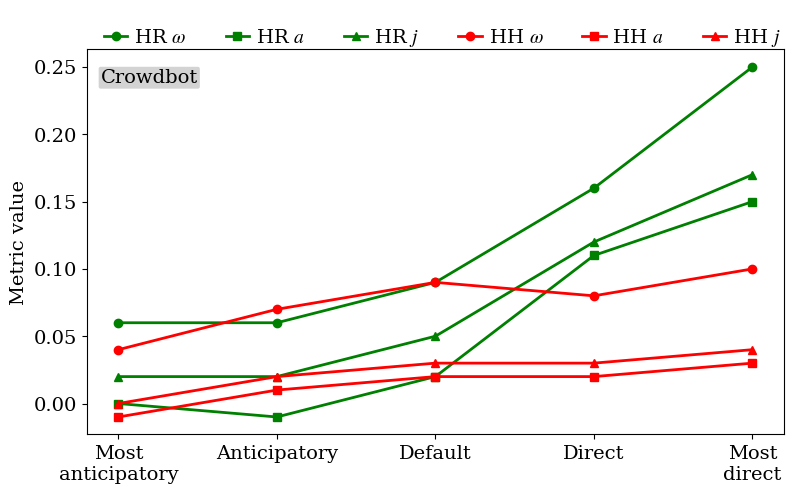

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 1)  DATA  – one value per parameter set (replace the placeholder numbers)
# ─────────────────────────────────────────────────────────────────────────────
param_sets   = np.arange(5)     # x-axis indices
param_labels = ['Most\nanticipatory', 'Anticipatory', 'Default', 'Direct', 'Most\ndirect']

# Crowdbot_HR_ang_vel  = np.array([0.06, 0.06, 0.09, 0.15, 0.25])
# Crowdbot_HR_lin_acc  = np.array([0.01, 0.00, 0.02, 0.09, 0.15])
# Crowdbot_HR_lin_jerk = np.array([0.02, 0.02, 0.04, 0.11, 0.18])

# Crowdbot_HH_ang_vel  = np.array([0.05, 0.07, 0.10, 0.09, 0.12])
# Crowdbot_HH_lin_acc  = np.array([0.00, 0.02, 0.03, 0.03, 0.06])
# Crowdbot_HH_lin_jerk = np.array([0.00, 0.03, 0.04, 0.04, 0.06])

Crowdbot_HR_ang_vel  = np.array([0.06, 0.06, 0.09, 0.16, 0.25])
Crowdbot_HR_lin_acc  = np.array([0.00, -0.01, 0.02, 0.11, 0.15])
Crowdbot_HR_lin_jerk = np.array([0.02, 0.02, 0.05, 0.12, 0.17])

Crowdbot_HH_ang_vel  = np.array([0.04, 0.07, 0.09, 0.08, 0.10])
Crowdbot_HH_lin_acc  = np.array([-0.01, 0.01, 0.02, 0.02, 0.03])
Crowdbot_HH_lin_jerk = np.array([0.00, 0.02, 0.03, 0.03, 0.04])

# ─────────────────────────────────────────────────────────────────────────────
# 2)  PLOT
# ─────────────────────────────────────────────────────────────────────────────
fontsize = 14
fig, ax = plt.subplots(figsize=(9, 5))

# --- HR curves  (green family, solid) ---------------------------------------
ax.plot(param_sets, Crowdbot_HR_ang_vel,  color='green', marker='o', linewidth=2,
         label=r'HR $\omega$')
ax.plot(param_sets, Crowdbot_HR_lin_acc,  color='green',   marker='s', linewidth=2,
         label=r'HR $a$')
ax.plot(param_sets, Crowdbot_HR_lin_jerk, color='green',   marker='^', linewidth=2,
         label=r'HR $j$')

# --- HH curves (red family, dashed) -----------------------------------------
ax.plot(param_sets, Crowdbot_HH_ang_vel,  color='red',  marker='o', linewidth=2,
         label=r'HH $\omega$')
ax.plot(param_sets, Crowdbot_HH_lin_acc,  color='red',  marker='s', linewidth=2,
         label=r'HH $a$')
ax.plot(param_sets, Crowdbot_HH_lin_jerk, color='red', marker='^', linewidth=2,
         label=r'HH $j$')

# --- Axis styling -----------------------------------------------------------
# plt.xlabel('Interaction-algorithm parameter set', fontsize=fontsize)
ax.set_ylabel('Metric value', fontsize=fontsize)
ax.set_xticks(param_sets, param_labels)
ax.set_ylim(min(plt.ylim()[0], 0), max(plt.ylim()[1], 0))
ax.tick_params(axis='both', labelsize=fontsize)

# --- Dataset label ----------------------------------------------------------
ax.text(0.02, 0.95, 'Crowdbot',
        transform=ax.transAxes,
        fontsize=fontsize,
        ha='left', va='top',
        bbox=dict(facecolor='lightgrey',
                  edgecolor='none',
                  boxstyle='round,pad=0.1'))

# --- Legend (standard upper-right) -----------------------------------------
# ax.legend(fontsize=fontsize)     # default loc='best'→upper right here

handles, labels = ax.get_legend_handles_labels()
bbox = ax.get_position()
legend_ax = fig.add_axes([
bbox.x0,           # align left with subplot
bbox.y1 + 0.03,   # slightly above top of subplot
0.3,               # width
0.05               # height
])
legend_ax.axis('off')
legend_ax.legend(handles, labels, loc='upper left', fontsize=fontsize, frameon=False, ncol=6, handlelength=1.2, handletextpad=0.35,)

plt.show()

